<a href="https://colab.research.google.com/github/amura/xray-machinelearning/blob/resnet50/resnet50_ct_scans_2b.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

Thu Jun 10 14:34:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    25W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# Import required dependencies
import pandas as pd
from io import BytesIO
import numpy as np
import os
import shutil
import pprint
import json
from PIL import Image
from PIL.ImageStat import Stat
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
import pathlib
import cv2

In [3]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


## Data setup

In [4]:
# setup drive
from google.colab import drive
drive.mount('/content/gdrive')


Mounted at /content/gdrive


In [5]:
# install utility for converting to dicom
!pip install simpleitk  > /dev/null 2>&1

# RESNET50

In [6]:
# Load the csv back in to a dataframe

data = pd.read_csv('/content/gdrive/MyDrive/dicom/ctscans.csv')
# convert label from string to int
mapping = {'non-covid': '0', 'covid': '1'}
data = data.replace({'label': mapping})
data.head()

,Unnamed: 0,paths,label
0,0,/content/gdrive/MyDrive/dicom/covid/c_0.dcm,1
1,1,/content/gdrive/MyDrive/dicom/covid/c_1.dcm,1
2,2,/content/gdrive/MyDrive/dicom/covid/c_2.dcm,1
3,3,/content/gdrive/MyDrive/dicom/covid/c_3.dcm,1
4,4,/content/gdrive/MyDrive/dicom/covid/c_4.dcm,1


In [7]:
from sklearn.model_selection import train_test_split
# split data 20% test

train_set, test_set = train_test_split(data, test_size=0.2)

In [8]:
# Data augmentation
# use image augmentation
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255., 
                                                                rotation_range = 40, width_shift_range = 0.2, 
                                                                height_shift_range = 0.2, shear_range = 0.2, 
                                                                zoom_range = 0.2, horizontal_flip = True,  validation_split = 0.2)

validation_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1./255., 
                                                              validation_split = 0.2)

test_datagen =  tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1.0/255.0
)

In [9]:
# install pydicom
!pip install pydicom

     |████████████████████████████████| 1.9MB 4.1MB/s 


In [10]:
from keras_preprocessing.image.dataframe_iterator import DataFrameIterator
import pydicom

#DICOM image reader
# https://gist.github.com/ReemRashwan/8c92086d3104d01978a16e05ca93a165
class DCMDataFrameIterator(DataFrameIterator):
    def __init__(self, *arg, **kwargs):
        self.white_list_formats = ('dcm')
        super(DCMDataFrameIterator, self).__init__(*arg, **kwargs)
        self.dataframe = kwargs['dataframe']
        self.x = self.dataframe[kwargs['x_col']]
        self.y = self.dataframe[kwargs['y_col']]
        self.color_mode = kwargs['color_mode']
        self.target_size = kwargs['target_size']

    def _get_batches_of_transformed_samples(self, indices_array):
        # get batch of images
        batch_x = np.array([self.read_dcm_as_array(dcm_path, self.target_size, color_mode=self.color_mode)
                            for dcm_path in self.x.iloc[indices_array]])

        batch_y = np.array(self.y.iloc[indices_array].astype(np.uint8))  # astype because y was passed as str

        # transform images
        if self.image_data_generator is not None:
            for i, (x, y) in enumerate(zip(batch_x, batch_y)):
                transform_params = self.image_data_generator.get_random_transform(x.shape)
                batch_x[i] = self.image_data_generator.apply_transform(x, transform_params)
                # you can change y here as well, eg: in semantic segmentation you want to transform masks as well 
                # using the same image_data_generator transformations.

        return batch_x, batch_y

    @staticmethod
    def read_dcm_as_array(dcm_path, target_size=(224, 224), color_mode='rgb'):
        image_array = pydicom.dcmread(dcm_path).pixel_array
        image_array = cv2.resize(image_array, target_size, interpolation=cv2.INTER_NEAREST)  #this returns a 2d array
        image_array = np.expand_dims(image_array, -1)
        if color_mode == 'rgb':
            image_array = cv2.cvtColor(image_array, cv2.COLOR_GRAY2RGB)

        return image_array

In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

batch_size = 32
img_height = 224
img_width = 224
class_mode = 'binary'
colour_mode = 'rgb'
seed = 1234
num_epochs = 100

train_consts = {
    'seed': seed,
    'batch_size': batch_size,
    'class_mode': class_mode,
    'color_mode': colour_mode,
    'target_size': (img_height, img_width),  
    'subset': 'training'
}

valid_consts = {
   'seed': seed,
    'batch_size': batch_size,
    'class_mode': class_mode,
    'color_mode': colour_mode,
    'target_size': (img_height, img_width),  
    'subset': 'validation'
}

test_consts = {
    'batch_size': 1,  
    'class_mode': class_mode,
    'color_mode': colour_mode,
    'target_size': (img_height, img_width), 
    'shuffle': False
}

train_generator = DCMDataFrameIterator(dataframe=train_set,
                             x_col='paths',
                             y_col='label',                      
                             image_data_generator=train_datagen,
                             **train_consts)

validation_generator = DCMDataFrameIterator(dataframe=train_set,
                            x_col='paths',
                             y_col='label',                            
                             image_data_generator=validation_datagen,
                             **valid_consts)



Found 477 validated image filenames belonging to 2 classes.
Found 119 validated image filenames belonging to 2 classes.


### Build up the layers


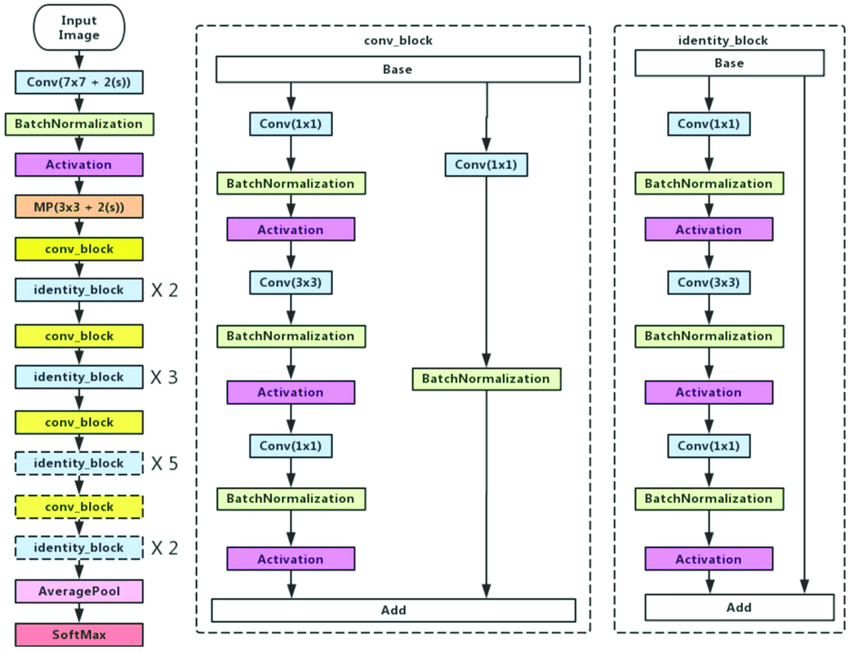

In [29]:
from IPython import display
from IPython.display import Image
from IPython.core.display import HTML 
im = 'iVBORw0KGgoAAAANSUhEUgAAA1IAAAKMCAMAAADWu3neAAAABGdBTUEAALGPC/xhBQAAAAFzUkdCAK7OHOkAAAAJdnBBZwAABfwAAAh3AEvX9UUAAAMAUExURf///9H4//X/SPX/RdT1/+WP/9P3/////f39/eWR//v9/RwlJuSP/+n/w/3//+n/vuj/wJqjo+iT/9/n5uz/wufs69H2/uiP/6axsef/u+mX/9f5//j6+uf/vh4rMv3//u7/xz5JSdT5/8vW1IiVlWJycfP/HbvIx2t5eaStre3z8VJgYBohJOz/vvL/z0FPUSIkJf/Gky46PN77/+vv79Hw+//+/yMrJ/98uv/E/0lVVfX39ys0N+GP/jxGSCgyL42cmv/9/er/yLO/vtj1//Hz9EtZWPH/ytf8/zZBQbG6uqa0sN///xoiEMjr9sHMzO//HNni3ra/wR8tGnGAfeWN/xsfHuL/vISRkff/VcbOzfH29nieZyQtMHKVpSg6Fpajnuua/9DZ2C5DU77e67LZmpm3hs3yr2dzc9v6/2yJlXOEhun/u9v+t/b/TtXc3P+//yISQdzj41l2iSw9MOn/UbXZ511pbUJUQf9+tdX6sVJyRTAaVRcjLv/LnKq3tv+AvmqNWH2MjEJccDZNXabJknuHhywtHU5oeNv2/0xsQaHAydr4vTZRKmKAjZ6rq6XH1daC/2R7C9v//4ilro+doDxVYktaXz0iZLhr7PyHusZw/sXprI9NziQeMtB3/8Ll8FZrXUNRBpC0wvT/K4iqvbrjm4+0fXGPZyUdPr/bMcTtoP6//8fS0oewbzg7EEYieb5r+4ekClw4jE0kh5egnqvM39+I/zArNSkzQDQ9MIKjd86vhFtkZV5+Up1b0p25IXR3hkNWMUViPPrIj7PV3ay6udL3/i85TMzW2KDIhbKkxuz+MtHtOqli6dCC/qO5v6G1vNbxR26KDuO37qFQ6YmmLdN7ozcmVkJBQ+jv73Q4t3V9WsfSz8ParoM80XJDV4VPvvq5/mh0RFknnGc6n0g+VX6Qk/TMok5jEI1QYs/wF1tpZOW5imZeY390q6F/YKvBq8mno6q1U3tYc63ZirrcVa52gv/UmZ2KrGGKTPfG/rWRxebB8Pfjm//T/65EWNwAACAASURBVHgB7P17UFRX1jeOH6oQGhAEuYjQ0lwfEBAYhKaK5tpcBC8wgoKlAgooolJUwELLSygBDcjVUTGWGkkYRMfS6MTgEKNmNF7ib77JOzXltxIdk/EXfZI8Sd7XeZ+ynvnlj6d+n7VPd9OX083pprvFJ+6Gc/Zl7X32WWuvs/Zee+29Oe61e42B1xh4aRiQySRTdTLZS6v96we/xsA0w4CVuEEmn2bv9bo6rzHwUjAgl3HZ0d6NYefPnw+z0J0P+2y5r/Sl1P71Q19jYHphgASLtHHJlpiMxMS0xDQLXWJiYfymdY/zUNhrSTW9CPy6NvbGAESUb39+WkZMRNSUXMT2+MTCtmpXlPfavcbArxgDMom8MSotdVVJU7RCOgWnUPg+9tqemJqjeM1Tv+Lm9PrVObnM9fG1xC1hbBjkzDlPCSUyX6+QjP48uceUSnmd+TUGXmUMyLiwmMSsJLDW1N/Cg/OQRuYX9iu415q/qWPzdQmvKga8Iwq91nASK3AUMCCTyB4fDYmUv1ZRvKrN4XW9p4wBRVbaqjxOZiUekGNkFpkRs9xKxU357V4X8BoDdsdASUZEk9U4Cpwky1asS2wjJn3tXmPg14iBpBUZkRKJNeeSoJLfHnL+NUv9GlvT63dGu88pXJEnrJmQSVxdLesPyu8UtkFDIZO/nvN93cZ+XRgAK0VvKYyUQUgZOp4dhLkNQg2DJplRVbnvtVSIqezXHGWI1tcx/6MxAH55HBL1kBNmjaSc+f7VgtymRoqx4ZLcdUli1msjCjWaXt9/PRiQy2T9if3ooAm8sozz3u6W6G+MpTw4ReRjY4kyrjEkIun1aEoAra+j/mdjQMIlrYhfbewdpetirzXJXaWcqxS8g3GVhO7ZLIBLWPyKJIkQM2JyikuKSn38mqWMYfZ1/P9YDEi4z+I3PTTyejIuMnO/q2xxW07//vm+3Oo2f/82f1+usS1HJp2/ytd3RVnhitVGpp/kkv5EL2PdQiPPex39GgOvPgYkzjlp4cZavkweWbHC1XVLWUxUYWK/fF1ZSFR8oZckxy1KEh1TUe27ya1we6QRHEjkxYkrpEbGaEbyvI5+jYFXHwMSzitxvjGWknBgKZnr/rJVTf2ZEa5eblGNkYkx0ZEpWyR519KquZyK7U0K4Z6fXMI1pkY8NKYtfPUR9/oNXmNAEAMyTtEWUiKYhEhJdmTFFrBURY5HWNo1Dy83L5lvarwvWMp5zfa0MG515gpXI9ax4CXviKPVVrHENVa91/GvMTD9MAAzB2r4RpyMW5wQpXDdUpHDnWcstcU7J/GnvMiKCN/q1LRqeXHm9kapsHoCiok1JpjVyAOnRbSRF9KrGw9FV314cWtj9HPpFT8R1DzIdA7TqRPFTeqzrKAJgwB1fvXd2AOFjQAmy4XSRIAYe6aZ8RY9SSZvyt/ubeRJMrlvRFlhjusKtzvc+cwY1343jKVC/F2XX0tc0ZaWGSZfHpN5rdjIK8rkrh8m+hsp2cxo9aup76az69BKXBbjBeoUpg1mfoKu+lM7v/FK6k5uGOugy8Vx8VSrj7UFxqxhtN9G8xjBSE2qCI8WXrS8yKgb0ipJB0M6UMZTtLJbw4sRT3xEtNGSvFdFbMqRtq5o5Jr2e6HjF5W1ojWPc129v601fL+3XBq5ZcVjI5mBz/40LyOJZkWjD5lXHbk4p8Q3m8tbvZh3q2GU61uyOCcnB2GsnXRtzEEA/pwmSbbiPAEhFOkrlydFqgLYE0PizbIAtFGKvTYY/OLFJd5yuargnMXFSZzEF09jpYUpONcmQDHAxmxOEQY/PTPSN1seXcw/ZHFxHifn64Jc1XxdWPaSJol8DerCKhaZJHfm64JsVJcm1IVVjepSrSoYdWEvyV6sOEku166LhOpCmXKWu8pZXSh/pC8sYIpZdM5iwgtekj2T6kIvyWpc4i3hFI/ZU5AlyZnHC9XsvAJ1ARRVk+GF6kLFURbgharC8KLTRHVIKOcUoBAyZMvz2DNQgWLgHpUnl7P4sUKui3s8gyWU+OIZqDyrIyGSVZ6qGSaVSxuJXAS3HJVnREWA3pcQSQmESHpfdeWzpY0Ejh9Vfs1qKgihSKwFZIik4tREZXCNrnJpGJ8DBWvqshiIRPX51pKT85kUTac6SeedjQWgQ8/YtMYo18sUCoVU7qrAiEmh4D6M9ZLCi2+VYo2rVJGNLZUUCldj3yIJNz9tnbBRhrHaCMdLspevis9MiS1sdeXCjsampLilpMQe/YxzbS2MTXFzQ3CFL5cXXgEf/tLWSTGKo1i3lFis2pKvjo+leDe37cs5aX8aPHAVbUlcUhviCS5xvlTeeI2V5FaGyTRJTkYsK8AtyptTHMlkULEVWQrON4pKSnCLLbwjyUZdeKiYajnVhRWcsiKJiw6voIq5uSV6KbKbIugpKW6x8ahLcXwZqok0vi58/opV0VzSFlZuiluhvyvXGMNqnBKbf15OdaEMbhN1QTDzyBrOO4qvcWxGjoQ7n09lJbi5xVRz0tZECiB1y0N59Hd4wwSgItFLKm/azhCWgro4yyPj+YJjsQpB6pXG8OpWgUU+D1cgM2GvsFXK6kI4ik0N42TLS9A0BYnknZWamVKW2C/llm9XVSu+WJ4dGcIX66Z6Br0He4bvFhUUEbU6hkeX29EwznVxIUN3itsKby4vqwJgqE3mEQXnvSnWjWgcm1Eika1ORUGUcq2Rky5JpMLwv5+ISrWl952Pyv8ERNLLpxbLsd4ITyGwCBB1HYhKmTLD8zjfFSw73vcOplqPlhEMEPmZs+sdFVHd0MDWHEnd36gj6gQRAQUE9zgxCuatRpI10RD40A26qaQO0CqHMyGAkVHCtVZkCRNAU6wYj0yetD8ldf+qVR82SuS+/auYa5vv6yxp/LCND+XkcdLicN4fft5VnneH96/yWi6Te/eroPyTONfqLFUgUsEpSniotqzqbHnSElWg3xvf7HWq/HdQ8GpVlvBiKZeXo0o40uiMuvBlYapOLtEUXKKQK4rDWUpb1nkpF92qKtirSS739lI9nuoSpqmLVK5VFwxv/VUF93vLJcvVdVlMdVG/5GrUZbGq4HX4hKvxsmo+hGz1EVUtSxTO0kiVPyvMlUtS1WWVl3e2rEldl1aqi6rgVZFSDV5WHYEtmu98Vf5+X4m0jRje0HnQBy1ky6pVWWGwHJh4Br7smmdEc67n1ZXHM9aUqCp/hIg6X4UVzH1KGo+oAtpEzXqM91URtU2fqBO4J6Kq3rct6zNXeVKrqiwgUr58oi5y6WN1XUBUxQRRqYFp10XTwNYAK/luKx5Ozilo96uJpYy1fLkHtsvkxRA81f2NGnzKPBCNP+NiSMItrsCMl7GiNSVN5sF8c0ZqsSvHb2bhzNdmIpNuWP00Fsvb7Mqd8VPDU7x8Isx/GPhEDQwFtQPIQ7lURdBbs7ELewT7sKhTUC5BYfMOOf5UGdjT1JlVkNnsThDa+XUCmgR45Nn40zyE1UZdkPopKAlP5N8TD89WB/hRFkIq+2XAa0pGGRTUpNCT1E+hNDZAk3Nqy2esSliSFuOrgtC+oWXEh5RItW2kJzCuDYgSJ3BPCernsUrJnVVfdqqIOgWvPlHj7Inc6nRWPAITOTRvxB7Acmiwxx7Il615AiuB8qsHpLop9HwCkbmujiksEcVS5xOjpCiQL9jwajzFEFY3hqRUuMcE1nRTxYdknH/aOlcOG0sTxrHDNNtlmvweWD4MY3g4SoCDwSLCDIrFM0N5QDHHoDzk2dnZyKSGAhiC6oJZ0awsepqmrGyJnAVZwSweFwpkZwMom5Ull1C52aqC+UdOFIyayclon98gG5lYduQhr/rxqAp+RAmZBIVK+MZOtWDZWBYGrqmYqi4omF6SPZSg2BsDkrEhH0uFsIJVNUAWQhbVnkcFC6gL5oH4ZQZUMKsCWlNSTEijwEdUwpUktkmBIwl9YAHM6sLXhPJSCSwB78sIRgFWJi6sJoDIJjAkeDjz1NJUCzQGGJ+FSmJ+4B5eVcADhCAgHoqyozT1IwlMIiF2UT1RXRZFq7JQVvKz6lPBqgRGCLkaRZxXxTrIoMkcPjA0lhJ0kuiHvtHaRXjQi4l2Mn4sZZRZxRYkk4etwjIRGS+lPIA/mczDg96esRFaBV8thkaksXIJ3QRHAUha5jQJCLEE0GUihUGps7Bo7bImnsKXqymYcmgClE37KeoAe4wWlLrGACcu4rPgzdT51TVWZ2H5eSiCz1ZXn9VF6yWRj2VhBWmqz6NM9RRWlAqKSoLTLpgPsGhkoxQ+Nz0SWqKIDKF1pRLuTmYWdi7hi1VRhQ948M9TPYPVS/1A9iIqKD5Bm6hqKK36omBGfL5aPOomCiZA9iYegKJE/rWYV/0U/oVVCcigekW+xshFKbixZ04gUlWwxMM/BW/Jcpu6wGA8Hgbjhg4NWJF1NAZDcleZDH/gXHoieQiY7nyY/2gYFoDPrReMmAwTzI+RJr3eFNp8rFk9B1hqkxGWwqhZRJfI6jWya4Ey6nVxTBCbfK6Ma4r5SWheCj1I6bqUFKiJGLsaKYSxl3CajHM9Yq15KeEnvI61LwYweR8luPuBROZfFv4rYKklbqtEsZTvpvzPBEkDbguJb+KSzvv6hi1X5DWGYTpAklR93hsiQ9oU5t1YDbVGdHWYt5ASCHKMy9sfHzn1oRTqpnioEKzh60i7YgAUjcoQWq8DBVJMq1Uobdf3MfNhcq54e6uIDwds/FaF5AgW7iH3DYn35hZnRLSlHs3K+ilkfxMXvS4mdXukRFoSkx8Vj23FGttiYqKgExVwEqxfjGm0AqJBMKPzyQLPndZR0CqpV3uqev7a1dU1ldBOmRZ+oyzFydc00dESU3HqcTqhxXC0wJAmmOKhstqG/kf/8QIY1gcxIww9ncJXzKcdb4JFvWr1oc4TYPdKLDXfLaS/LS1ty7qjafO56DvroiqiFI0xGeGrMhMbsWtFRETiNdqwzMCRZtUay3pRww/d/A3wZfC8VyGCfwvj76LR407Ll/HgpIvXwbjDiBNsREZghaKpYGMIUimy9Y2wJzTnwpgzWleh508WJ7owUoCuEui60YyTb0iqt4d/xX6Fd37iY4/+lHBZXk5/W0XMw5yKLYqH+YVN1RmZMdcyE1cL6UEgXNL2S4WYbbK666Z7yOQfxlrJVlC3ZJuE+E8jr/zC14B9fOmDw7RZMK1acyeHNo7ipJFLSCuk/pKSsuc8ZpnVYZvUbeqFssXdAsXIhVf4CEAaiZJGYpoWixokkVjiKgMaaASvxh8aM7Yb8r6DPg+2ECLVI0vDVS4P68cHHRHL+8n4G9o+XOEQ5euPyUyBbz0PYP4VbG1MFadTGIhcnRqBUZKhk3Pe8fG+zqQ5jI7JWC5fUhEubw1ZcQTTfYtT2lx98xObwgoLw/uPUEsQyO7qVdgvIMMNIU3H8FLKNMy0SeUJyrAhgBLQBDhNJcbJXvNT4mc82iiPMzUfrKERQuS0eTlVRQy/1ujPzDe6mkFM9TH86D8STcuEFBFp5zndLzwQGZYTLeeqv8PInHw6mF1V0Urqe3SmsrAlq+phuMu44kwxZkFiqsfDyLnlXmGaR5jIJ5PnbQmJFATIzklLy/Hoh5oD7NMon++2yqMtdkV4Sr5vWEaIV1ZiYaPv9owjOYurdVHAl4V5QdJ7qF9S8AGiImUSD3T8RIG+dCA5J1EoMHMhY6aQMqkUHglHAfhpRgPmUZD8EizbXHMN6804CQNEghSmlFvccgjWsMm+9PdSV0CiyBOiNeal0tZNjdSuvtByZbtKo7enwcYSaMP4XC6Vekil2EcyelPGY9dsRVOePHpTSJiUcCaXKtC0gKq2lFaOcDY/FpY6fD7U1hUWqZEpUQr5GmNrj9SvJP7uwSvRRbRoCRknELn1HK13SkPX7U7iOo+k7anLudbCDz1K8o+uKIzwVfSn4l7YyBVHpB7dniO0HJ7NIePDo1eq+UGIfLDUVDvq5j/X/BwwnvD137I/UqrIaVvh5c2t+bBtcfiWxWtWt+VIoz/M8sXnFd/z+Iz+VW3FrmuuJYZhaLp/C2zn5NLiVSv6fSGlfMPDYQlo/qPtkoNkSdtygdrBTiYlS1d4mFchKD6OhEfDAnL/kdTEx2SntwUWkXlZbTnAnwK2zinX+qVhW0qc+zMrrvUX72+VKPpX8VM/4W7fea3oT2JSClaEW8LPS+UwX1yxqrG4YkVezpZIqbXwiXmpTMxLiWjRtM8RbHMNIeWu1ZEl1a6+xVjE8dljWGGvboIJ/2Pv1dXSbN/HkXcy8r3lrt7FkWFJAljGh6I/8UNr7OPnwVjKPBK9HGgZ9zC8MD+qNXpJfP61jC2+SamxEZsSQ4qLM7YnVRfCOo6xVGrKpoi0mDAFNhpQ9Ifkx2S0+Uoij2ZsD2/aX3HHK3GLkBHdy3kf/aei4UcUrhYySJK3phwRaEH6BRgNA3Mhhd554YVHN2Umnpe35gMt+319490iNqXFF7v2p1XEeLnOLwuX9adlxvSXFF7zbcxXzaaGl+WvCCns95jvFi47fy3kp5Brq7mmLYUxK4ojM6OKU+NXq8wojD5bdAJYKk0cS6Hn11a4WBghkA0G4kHuIeei/VdlxWR4MQt2ZyNHvHnH5DeywbnoOgsDooys2PnCadMrFjt1JG6v9s3zjsmIbIrKLMnLT1vi3ZbwYXRURlhrRj9MUKjjl5qY07Q/pR8s1bg8Nf7x8p8SV+dtT1zi66toS9mUSh83wS/UNHhVo0p0tuZAuAWJqzZYKjUEw4mYsOrUxDDfmMztUYmZxUmpiXe89yd4cb4xicUKzt8tHCOQwkhp0paQYv8Mf37cGu623/tO2jUFxlLStrR13l4Vq1znp61Y7quITEvdHp8jbL8rrlq6UOKlFAR2JG03qy+moFxhxoPM2FACjY7a6hAHEqzp/ykmYkk0+rLMwFCoDXjMLwyHCNatlUUhibw/cbFFOe2cCRVlH+vlGUejuSw3/7z8jOWwCwt39cpYF5VfzQGHpPJJ9ZX1x34oBUuFpUUouDZ09+IxWSHBsKAwMQvWp3autujHEUsJW0+g4zdVKZWagS1N9rtKI9Kql2ekbY+IuRaWFB/iLQNKPfKuFS7nOP+ELC4vprCJ4xYXfrciXzXluSql1WN5Yf4a/9gsRURisUdxWpQi3M0f01XFaYmFMYLzO6LfWAeQWIosGXUijQXy9mPxlVr9aAyIxauYR67w9k4yTnpSvTTFpFpDOYGnyrmmxUImUyYr+jISJVxO4vYw72hIqZLlUYmR0amFy8Fl4dxnMakZW/IgfkgVDCm1PCqzlVgKUqq4+lrh4+hriUu8vRX7K/bH5NPg/GVUXsQzySBJ0HrCKlIqw/tx4rWw1SGQUqmF/mGrP1P4hoR4y73ArNHXMhcnMSkVHZO4OFrivakwYxWWIlOTXeXW1uSftkk6PzbLtS3tQ++szCzX/swtjd6KyMxrWwrXKTj0qqzixHf86HHF8bBzMM4i5tYIsxR54YmwuOVls7nZDeB5E3yD6OkWgamQ/Wws1ZqaGhPSloSOS6NHf2w4t2Z/WWIOW9Yg4Zriy7ZfK4zyXhNTEabwwlgqPjzJdXEqjaWg8WtN3N5opRZgfewwKSVkkCThlkzNbBaYiy/0TtqfeDQqM+2xa3/80RUr7kh9QzKaPLxiszhFeFrIEVeyIyTfOoVsfkVhJIQ+FA8e35XFR2SklnD9GGlhLBUTv/0zCb5nR6OKofHD96pVKnyChvnoEd/xo7Kl/YlbsBrUSsREhxHqQaObxJj9MvhqW6lmZj/avAwyiXf/ilWrJXklbfv7sbT6w/AkLmxLpFxSvD8LWge8BKYWstr627KWZ0u92nzleYvb9tOML6m4/KNz9jdGe7WZPtXBvApZF9oUS2FWaArCFfKPcLU8C1uarILZW04bNHfZeVmIW70lkpM1rVvhD41fZLac+TBmxZiTiQB5yQqvrP0lUufHSJWEhe+nFdqS5UdWZC1v2u8vLd6CrVKmUDFtBMrw4YB6QlxTxFL0FYmovnr9pnZBFvjxPS6JTz0/FRzrPtU3TGj5iS7MdAjR8JPmn+TYRR7fUBnmVBCBSRTEQn2+ZL7//JI8V1dEAcaDJqpkBIhlmsjgmo14yjhtvx9o+JsKHwt0PXB6+v5IgXhzaAI8EJ4kKszRdFQ2XQgpHKGHduLnfdHFKwrnyxWRQGfrcldyEpmc9ulnaAQR5DJXVylDJ0dFWImlOK46vFhsYRgRN0YkYscjc3BgAnZNa0jIHcyxWac8CNz8EhNPmz5JpNAhYQQjTywypX4JrV2HzpSozHm3zl/iX4KpOkqkOHAU7vjngbG+nUmy6fM+ejUBS23JDxNc7IMNf9Qr+fUyiQxi2wW0fVo9TR8aEgVQfPIYBIbAMnIPZyx3Z+lhRwu/881WRPYv8W9djvXPbJE2FvYCj7QCmNCLC/JgwMCwLLIOk4FhGz0mGSeD49NlksaotO2Ra6zBBNLGVYWpMGSzksO8VNarY+PHL8wkpsLrE8dwTO3DeIi+p0inRafqRIDw403KR9HWmHawEuINi8GmNcXRhtECMy1CQNaKc07C9nOsC4S13dZosEYqZlA0sacZYgIf0VWFhVH9Yb5J0aZcUpLJ9CTf5SVt+WnXYLBoJdUEGpn8f4wluhHivTrRJDeEnDTPcIGPXBptsq2YamYm05Ly8pCex5xJwKkkJgnIBGmSwsj7C+EEcXk52wsL4/NjTLrt26+ZTD+ampGYegQ7Qgqj3sijTUXzLGUK4nXaS8YAxlIrBMZS56NMtxWTDellJ27vN1wBtjpqsZkKAlfvyKyI/PgQIy4D8RkJZYksOSNE+Jd6bUvrcsMv1hRojq7Qayk1BfxZM6vEu1Hg4w3dW2tKluHAvb+sAi3GSGsSiFa3KO0kll07QeOHB07VGOnG2if/PB5I00S1CxTlzwhJLMMeo7oOGr+UVR5mzRqi7coVSb7eTcadd/W1tByTAN6+a2jIbTUZRaML6vjpvt3r0MvAANQTq36qFujRS+SC27l4uYWbaisCzYzAdbPwIa14rWR4J5JV/okI5tOACDzMZFRkKtas6zrzpnpVeWlSjEbOxp00ArOXk6g91CNu46WYlUJS6tVRT5j1aq8YMOalNsFs1rCFGJFSXm7zBYBfhZcm4x+DeVXzpno1r8lvFwhNppCDChFmVNWcq1CiOo5pszTlWcEDa61XxGzWCi87PYtQDYyN2/jBEl2g4+fl1o/jndUN41W607b022FMqOMsklI6JegHoOZ3la3ZjlU+NH1mR4dDrmIipzbrYcfa/g9+FLGUOfv4gaWstrLCvmjF7pZWk1LGa44Fq9VZWVkhFSs+DF8sNEY1nnXKKUmN+rMhkMzzP3zt7IQBLyytoBGyCZYSskT3iu23bsePdpG1ei9IqHXKuOXCUkq0JbpQqQZxEBaJZWUJCbFlZVvszFLM0kC7QjD36K8oY2eWvL7YHgNl13CihoqljJjNYuGFQdfFRlLKWhOe2g1Kz89YSn/1A9n4YWtMg9fUy2tGEMLwWmwCucRWKxYrogbU49QFA0sdcYvyf+3sgYHWdYlsORcvpYRZ6k6awHopK0spOXaUWLOGmfzptgbrh2Q431NgLHWnUOAtp/B0mVy6yi0hISWlLF9o/4EplDxp1kb/Jl2tPFgqK+WO4Xdx0pJeA5iPAXk0TjznlcHQ+AmxFNkv6quc8RzrSinQPCdiU1QUDvMiK0pmGsS3CoStZU+qwo7gWIrjfCOb1Of1mI9GoRzU84OYckvAajo7CF9NFWRY1XtHE+I9kFIpS+h8nNfO5hiQ+6aGsKUU2M4la5PQYThGLN8gpcw0NtCjsk4QTN1WlhoVX4hTLnnHM5RmDlT3q6uT19yA4FgKfIulGlZ8CnWll18rS8CJja2TTEyZ+wKm4TEvdaRMf+8JklL+Vlw0aboKv+pULPHCdo4kpbBHmi9tiC/WkZSyXgt0lmAFb79iceb2aE7R1IiKyKXeuME+3LexCdvz6w0OxNZSCE5YSjHmtd4L4cHo+bWh51eGVf9WrL3QG+nECVpPQEpVLLFrNXTq9OsKgKVUC/7w3sKkz2tMMtz4xyvBmho/MDVYKro1PkvqmrMpf/sdqaJ1e/7+RrkiZ1PM9n69HTOnRiEjUiq62te6UgrYbE2EdmKF1dZJintvIesJ7JoEKSVMXnGl2gkKa3fQMxO1r4edamT+Y5JSNSwl/I3GhkD5Ah8460opGO2scsuPyIjAIeaR4VsSU5uaUtPalnjLSlLjo1IzsOescOXMf1/WITOcl/LgSuK9rPkU1Ix4N7YM/T7BVWiWVF1UHqF9/NAZfC2lRGFv6kDyCSnluhrbqhg67D3hlmX4gbOuxo+kVMLRFfmprRJpWH9WRlqYb0Tiqs+k0v1u8dtDyvbzRwoaVs6SGJmHoMYPZrNWVaKDpeSK/QllqdWGyLOk2mLz8JboetsJgqVeCSmF7Vvme/X3Y6pUo9BRL3t5BUSsikSQUr4YyYDseSvizwtQ38gOSdaXUilLXCMTf1oD04Z18diVtjr8aP556YqETeHhq0qsiU+ZXNh6QuTWmGKbNuBkHq1psSuw74sZeaYMisXPHxpsjYmO3yshpSTc4rTEoyHx/erJcb5zomarKSPHHgVopJRq7wnDtiuRCe7jZ3Up1Ra76nxW5qY1i92u9YdkPs6LzPmprN/jw8QVkZHFSQKsbjF2BMdSMpxILG63WfHPhU5leWqFP+2aakfHSym9B746UupOyqYw/8J4qHRcFdjThXbAp31c1De995qWQfVYSmU2q5G3msqSJfoRwxkbq0up8JSM/JDtxfLqmBAo08O8N6XGbw+TNbVh3ex33tZUHAhq/IRYyjmbzuCTSCw3DpbhsNawbMvz0xwKNnw2z+FAx/045ELHkXqi1ZrfJZ3STjFD9wAAIABJREFUrRfAmRYVqzyaYmK8uaZ1+9uKpZy315bwarncd35bW46Zy66tVy3zSvJVqSeYjZ/QVC9jKUNqWFfjh/KX32ltLVmObaSqS6qLS5IUq1tLmrD/lG9x6+JqM5T7k7+9ESlFe6LryhNnifNUlffyxVlTlLDOZrMUthlM0j/S5BWSUhUx66Ji7rhmF6/YXphfrViVmL+lONu3LT4mNbXV1dheDpNT3Y4QNC+lGksZ321WwFTHulJK94Uh79F7ZgLTeoo+zSMYSxna+N0xYCnayUaBVbv4WeiamopLGr0tz4/H5mU7WzCS0EfbKzSWykw7WhifI832juyPcWtVRKV8Vx0tv5OYERUTew07kGnIOG098omOn9ENnP2xp67Bq1jXegL4YZboxEaYllA7TPHSJmMGD58SOo1p/AROlJdxj38K0d5cIj4kXu1ELMoHNFb7a+fnM02UoilEIIo9KrVfaj5LQUrpYehVklJRjTmp+U1Sr4jvYhL8PVZHxUStxm4a8Zsi8tui7avp0UOi2KBaiW6i41eSOh9jXj1HUsogUg/GrCD/Ldb7vFrwgZ70oUY0fpEx+nOhzpDe/gmZqfGDGtcBXwf7aaIEPARFLn6wQ50BefQdYiYi1XATMewp98pw2KOZSBAcSzmTjZ9V6TUpni0BcOXupOyP/iy+sLGpMOROhJu/xPvx/tgtrv6ZmyLPF2MjKUsKtXcejKXUiztwHKEg1vOqkwypyqSUbWikjTdtv5VQIziWws4s3vq7JjGWCtpcVFQ0xP/jNkR+VZDddS5IVQHQjfeyGO0CKAf7o8gJLx+aKJySkrvHIxRmDqZeaY2fK9fqVhiRX7gqryk/MSq1bP6a8O35iUckTSsytq9os/MMn6XtjaQUP5ZStGYZP13GoGlDSjlnqztor9Qduy8bWk9wbN9gXSQ6Z0uy/xoUvnBhYH19V9fCLnL1dOe9qjsLqC4LuxbijwfCtZ65hfX4sczaefkIXJGkStVEqT0Ll96+ZwFLCZwoL4OUehU0fjhedX/Uii1YkCCNbOv32nJeemfL/iUY7Det24IjRScmgHUpNa1CzuqxFDQC2PHdmIZLQEq5zTcGPK1e0LAykFLXDNZLkRU69pnWgcY+0Zz/nspAJz8HPz9H/PiLn5+fk5Ojk+Nd+mlf/O7e9fPDH3MMnvcm43aXh2SZnBzhnFgag2YFU+GqR9x1ZCWjtENjiRFSmXli6pWWUpwz9s3Hvs00aULnCzjTtvmYlsJsBlqnFe20dQht5YBa48cXKzAHQuulMPGm/1iv2P1h1nLnrVWQQDmGZZ+v7s8AS+myDwdLmGq9bwRYSv7XoMr6uw4OxARwfmjr4AbmF7r4hd51DHUKBdQETGAoHGXTc353AwPV0X6qNDAVPUQV9PM7xEspAarok2MibJSlXoWxFKl6QRjs3Q21lDO/cI6oQpvqM6dPtYn3nj4+9bwUaoRz3AVqjNm3xHWGLNUfW5ifagWXz5wVCjJWBJWfmqpV1/yjhWU4bkf3VWmOMYvf4n6CNryUWqhu4o6OuY6OycnarJGMGHIski7JfsnkGG+waBZEipprGDh/UReluTvm6hTv51cwACnlYRZH0cb7hrvNvioaP+Beo+ElZS+YiVmlg1hW1vtOUNnqviSco4umA56R+ocbfruh08Y+rFnqj8TE49HntY6LwIny1ilJuJTUsnjdhE0ItqptyNQvhIUYFeGQSuowf5dz/kHfFeSCHUh0JOfmjlU2N1e2JKPpUwwxTjLi/UiKITW0tnJ4rK+zubmzrzbXzy/Z0cGh6DCCEZ3DTsRSTk7o7pGPchcNbG7efNvJ0XGgcqALPOg0NHK4KBcB4s9cegSk1Ni9CH19uG4NDUPCUuoVGUsZvs4rGKOWUlCi04nyBh08LHgQtPFzzfP2tYZLasTx1w+tUZJwGQ+PuK0yKN7wmAHhrTFlcv+UyoJQcI0j2CbXsbu9Axwy5ucYWFAQetchtCCwq/6QU25ggZNfaH1XbnJlx3BLX3Pz0aDBlqX1uY6Ohw4RS3UWBh3OpTLAUoGBxIeOjg6hLZWd7ePNtYdqO9vHcrsC6wv8KjtGulraO1ty/cBocE5+C8fGIaXMa1VgKcNVvbyUmpjwe6X0Sa9YZTkslFfvPQHrCdBD3wlborPPuRVWisFa9xoOvbZCSfr1ZmGcpzPfzUv3Q4FTdgxhhVhKDiO/JWApkisQLn6OLe0dI7VDLUVOjkMttUWOoUUtQ0UttcnJQ7XJjsm1Q35jHc1FDkNDQ5U1lUVFLUVdSHeAvnxgcHAslzFJsl9REbjTj5hraKx2bHB8rH6kpjIXkC1FoWPtnbXJIzUjJN148KUWSClOlt2f1qr3hrT3xKug8dOr9qsZVGv8TEz1ouOn2yhVb2oNgysJjr/GifLs9DUbIBDrsOa7fSiiHw6WMljcIXeWyecnVB4KBU85oKuWO3Jvc3KoQ2hgcndze3tlbdfAYHNle/vwUGVnd8Fw+0hRZc1hsEt9cnPNgMNwe2XRSPuwg4PDoe6azcm83Fm4cGRk4VJScCAMRmqvGSvq7BgIbNncjux+m2tGusY62odyoWIknoKUorGUmXiRc41L9DfTpb0n+umUodfO5hhYs1xj42fUIEnwmAEz6WwMnEkpAYWiMXhz4wWklGARvJTStQdRSymwlBNES6hTX9BILhp711h7TV/nvc2Of91TU9k83t5SOb65qHL3SHLnvW4HSJjumuahQ4ABu405OIQONXcMQ+sOVzTQ3dnZPTBEMo/GXiM1zUW34wdrHQ4HDVYOFzmNnK0MHOqsGevy48VUMuv4CdbXRCT2b2PLIbRA2D7p8VtWWMftt1ZB1qmORaVs2WKzl9iyKWGyffw8BPdE1yLYVLwyj7wYklJTKcNUXrBUrJeedk8I3oiU4khK3QUDQLEQGrp5fCQQYmfhyHhf8lhHR9FfSzuHagfHb9/u6BzobK9Nbr83EIh+3eZ7I46OXcMd4x3duU6OgQM1nUPI5udX39LcUXOvo30MgzO43IHB9jFM5rYPHRq5d3RkKHnhcFBfaHLn+AB0jA5QbkBK3cZYSqi65sbJuJKj8am8eWIqPFP4pYZUVIRMIf9Unm21vCFpKTZ5B1UF97PlByY6foJms+YS1Qg8Hnut0IZSimMdPz1FnkBdsNssmc3qsDaTUqVQT9DIBiq55JHx5qH6+sBQSJOFQx0dQ/8rqK+rqDNxoKi5fXNHpSNYaqwrOXBscPB2V+6hgY6ymoF66O6Iw0LBUk6ORcMjnZ3Dw7WBKM7Rb6yzfSDw0O3C9iGHoeHOjs1DC4fPbq4v6kQhvJRyskxKcVxStf6e6Jzzmsbi4uLVzBWvnsKv+PydwozF51HUFAp56Xlz8gv7bfEGqwnHxY99WUNC2xY+DEfGnV9RYjMxgo6fTaUUJyP1xOQsJeeqV0XqHZ1GYyl/klJgKVKZQz1Rs7m7e7i2u6Z9uPJec/Jf3Zpzi9rTBpYehvDpzsUYajg317FyvLLIsWuoryPmXt+QYz3E2VigE4QbSunKrax07HLCwMwvt6VzfHP3WHJL++DtgpbhyvGOltzKe5ULa9s7WrqQDkHmQGOpTWaPpdjJHYZvbN7slsBXB3NE9JP7huQ/hB7Y8AmCeaZdJL2CPHpTSDW9jYiWYdYLqJDCaxnQtlekCu09gSlgnNWr8/k26ymmgW09lhIvpST6AxCY/Tk7zyclugN6c+j8OSYPNNd0tDePFVV2dKCvV9Ad1OdAUmXpWPue5qFcx2HoIbpaOmu6Ax39ME4aA4s5OIwgMhQjMF7lMDYGiUVCqGBkfLx9sLMlua9mOHQERumbizDoGlg4XNM3FAhoRyd0FS0ZS0Fpa9vzpbzjiaVMk3V6p2L3yogQ/XMwrVll9ffG9XyJ0A5J/KNs9U2SqTR+1nwhnbIgpT4U8S1SI0E7L86z4ZYkVNajfZOMouFPy/DIyMBQbtHAyHCLI4TLgJPDwPDQoeSBkTHMW9V2Do6FDg0PDKGbNzY8Vn8bsQ5jwy3JDg7Q8UFO+YGZmAPHtIyMHD48PNQ10NE8hGK7hxyGwVZFfR0DZFEIJgY40/iZ+TVjW2Pq7zYrAgPab27S7w0pRYbWr66zPUtNhhuJwtVWHAXph3mp5UINerJaiU0Xx1Kc3HWNoSIA81I8SzlBkUeKbczIFhB/BNZ3QeNQcIguNNbq6mIDru72keTArlxiB8Tjn/iHMhA/ObALf4PhbcGhgoKCQIy1KtsHYOEeGDhU2TzWNdBZWQSBiEeRsS6sJzZZZXGHWGSJgMv2jU99aLNei4gKTB2EWCrellJKXUUj7Vomr24rthkKeSllaO+krtSU7yKllIwLExgxMkv0Q9TA1c6P8QWNdcAjZEeOKeC7UAcCBH/JLS3UwyOmQ1dRJdq0cqtKcWLchSJQAFTrY0OQSxBMYy1+ubVjRZgGZvzEWCoxQmG4069JpAgaJJnMYWYiSSmbtQcz62IZuM2llLpaMl9sPm7oYD2BrTFtJej5sZQNWUq8xg9b8+iaZnp40HqpygJiBJhH5OIfnEIyhyQIBA0YgS5gAfggxUgUMV6DJgLg6h9l4/1UEIphHANwyuDnGArzDMoJceYH4yYnXFEcsWYyb+NnnmIBc1A2PVEe6onXUsqQTQRicHJHeESjQALtkCRsPSEAbHbU9JFSrdjHT9cuCiwFs9lKzBKBCyYcL3XQ5OmPAozVcGdhEjhgFB1+IhBtR4bqxDXkAE8Z6UZMyeKYWETJYCms6jXTEh0GIzZlKc77f0THz6bqCZ4NoEQ3YjZL+/hZebfwCc5TafxsNlYTr/FrzcSHQ8/4Ry7/654jS5cuPIQ/+tUfWrj0EAIUXIgr/eO3dCkFkY40goaf/hG3EAt6kesQclEc+y1FCD5kYo4VTYUuBAQCLFwPEJS09HYNpnrNlFIyeZbBYTgTCJ+6j0kpW/Vapl49ESXYaSzFpnqFlOjCZrMiKi4KZLpo/HjrCV2Wwt4Tcv93Ov86PDKsdvCNsB/FaQIUpfrTiqUYlZvwsXQNMMVrsvIe7fDIX78LMt/GTyZvzS8RhXxLgOQcWMr39VhKBO5MsZTQ8dciihQDMp2klH7Hj7ZzWZxWFrtHy6nOTo6NdeP/1Gcpx7pRxB7AvrNnjzoSUUEVlBlxEy4WUG6Apxvz8vl4AJ2HISp2s6EeclK8+n5mfDZk0swmAKgvIee8aSz1WkqZwJMqyRRLVQhsjTl5iaIgptFYirbG1On4OWNxh29/uMr9/8LDj6j9ou+rvqr4cxZlRG7VP4Ial8WKpGIRy/9RmjqQFZ515LHh3tmiEGsjIKxWxVgKe2oZ0Q/b6LHWLdZOGj8TLLVE6ER5K70kHkvzUmZOZ5rzcHHzUuj40YnyOgXLnDl5NouBgQlW/JLD8me1w9YIaoclWOTwDeed+i5XbErEht5wlJv+synAyqQMFNBzSENB7A8KSA9sIm3eUIqVLdF9ERZntQvr+NnyAVarqbGCpsNYyoZSSkZTvTbsmouel2pN058q0FKpa9q9ikrO0Bngh+ZOP23HLMdYBBmTSSMSG1XMyBfBmG0CXlMueSaiVbZnKN8ShsL28vr7U2sXPRW/LGm5d3FG4Z2mJl8LOqRTebI189pPShk7Ub6pv9qaBi1ayJFLpLKHMYXVnNR29hmipBTas3cODv/WadZ8RZn0YV5Vq+dliEaWMA82mON/6pejs7SlUmn09sTzEpzmolWuSkZpcngw3LJY9iiSXiSksC+LZSwl4/oLF6vrYdU7BG3J9vzUipSQo6lH1li1aLsWZjcppQjfXg1KGjpsTG4jOS8JW+eFIw/bvI5E2soyV5yUYiICzVqr6RviwZwYsJ+k+siRrJCKLUeycIqLOXk1sPoSUJNgykNms7ZSosvkkRllZTjSu6xs1WspZYoKfJrEd7mQ9QRL1O2VTF6WOAgsUkqsyExIyMxMC5dqdbPE5RYJJUpKqcuyrOmrc+vcZfKSjIrMFLxcRZtRvOrksE7AlgZJMnnSprKElISU2AzbqemtgwZTpdhJSpmogqIp2llIepnIIi5JJg+LxzcPX73COxhxiMtkJpQ4KQX5lLc8yXpCCpWkk+H4l0vzt5GQF0YFs56wETIlrlkVjGDYCPHVdXYaSxlFkIwrjrHR5jpyLnpFbEKCW0IZTr0T2pbTaKXMSBAnpWRcZH6/VW1EYOG1KoG+6GUxQnZeZryBeaBscYe/eXlEQ8u41SFlbmCqrFe434evnZ0s0aWfRQrNEBo5UV40FUwByiX9mUSglDaprfToIqWUjPNPWeWhu1DeVM1FpOGs0kT6orutiBYcoooowhIQW3b8qDFuj33V+32Mpexi47dmRXyYAO1ta5D0OBV981hoqGw2MyVWSt3JzJJbmaUaY9D8yhL9XS1hDUvz2FRKeXDSLAx+y7b7Wlq96ZDPTlIKlkHCSnQ6Ud52luhJ1PNj/T4b4Vq0lDLcx2+KNZLJFW0QwWWpNt2txqCSJKVi/W0zlsI0NFecUZaSAm2STUbXBm9jkwg7jaXIeiLEiNmsrWz8oEeUeGG4m7LfhioxsVKKFndYVUpxEucl6PlRv89mIlioxUHTveKxUII14jw43+2xZRkldn0ja1Rcuwy7Sak8Y8dfG9ttVruWFvnBUh6rU8ug77OdSky8lFKxlGXzq0Lvj7PhjpaVJc633jhRpC2FwtfCT5SYuRJpVkXZNWiTXmGmsqeUEjpY1IKxlEjKoxnKuIdRZWX5y8k6TqhVasXp2v1oJUziNVdKTbAU803hIstWbEkoi/8M4mqqTvWO4hA7GSaFEUYsomcVJQQI1Whh2f41VlWOCj3HlnF2k1JGNnB2lS9xg422Oa+IBiQSHMPdDzMTtuifkiuQW3yZuplFSylo/FjHb6qtXyt/tvP8j8qifLVipuLFe4nDq5x2iTPXOZPFuyiW8s7P9HfV3erayMPwtkZSXm60/aQUHX9tOOiUcCUZ/ZawlJz2wZsMdxL544yKO5OCsaY4WVnC6WKlVEmq1ltOpelr522MT1kiJWtyazjh9zOIlXOPV5m//Q8Wh4lzULr81Ch3FQc8KWENam+PCPtJKWMnykeHmbmKkxYaiaSQK/fwWkYjZzsKiZRSci7Pe2JWzkMiEVkjky3L1Tk6qjDMWWqVwiQidSek8Qsyf6p38q+fprFX31kj9hM7fVnKLvNS0vnfNWnQpu2Rc2aeO8xYSrsE434Z59qflScgHHWzsI+8bpTYkFgpNXEeD2td9EQ8gl+9YeEV2e5kPaQ1IOQsLkvsm/JwNC8Va7A15uRlSJeXlOTAlUz2K2n1ukOgJaYdFdVkO7XT5C9kHMJOUgodaanCanOSYKomwjrh1ZRD6p2s71pNEyhnMZEaJTWaP0SgPdFF7TarIQA1/ocl/v7+8+f7T/k3/7sVXlMvxX9+v/9f55c8FKV3sMx6Aqurt1QEWddVZLYpbGUUoyGXJR5+LCUKm5YUr51H8CEyzrdEWHppZ9Xzy7Klq9KsRiK+oIrMFUliOxxa1RHHUhznfUe1Xgo7TpQUurmVurml8BfyWPSfwkpISSnlS6JihEsSjp2ALnUrTXFL7HcVY9drKUslXXNr3mxVF+F2bc203OnZTuoJSClXVyE5LfFYXKh3NKdWgzXilTlLN8VGWJVAm/uC8s0c01HlREopDxjkwUaEaZJh1Vh6a/Tq1QtXL0zVoQRrFEOFvFu6Suo86VQD7BvYifJG6GI0mvYAqaldin2ku/DXVW/yr4s5kzCBoYFLbxfG/KpZCifK3zkiZLFvidksFi1KI8YHQCHg3Sh9GGFUqaaBcgMDA5fWxlvCUqJ3m8WJ8vx2LnIZTui9Ghe3CI4uSp1/PqQVp+XVA6UCeBenxA9epQGEQXETEHHk5f8WBcfFbezNkk0+ezcFlooprF0aGujkFBoaepf981cK3GU/Fk+RLJWPVyXdJQidP4fApS33YhTTVEr52mNPdBgkCZ8vRVO95u49IZNku0YE3V4a6KhNFjX6VbjniaMikYocGuoxGjE68fTDR6+246jtpBTMxjPVe0+QlLoa57Ngq6f7vLme7j6z5s1zd/f0dHdX4sau7vPclUofdwoizt3dx33rAqUSICxEIJRjnqeS4OGUPrNmMQ9dADbPc9YsPmUillKUSirAk57l7kPlqx2eN7otC+ddGRUzmgSSUuarJ2hbnZqWQ7TzLdtMmt8Il9+TmkVgK1x+b2raEZcCiMV28Ko0ulGAT+Qh6m/fg5Sajjo/TFdnhHymwZitPGTjh3kpwyldsFTKEfN2vqI9JSGlxugYGZ4OQLKKIsD93bt3VSRhBJkgEAiCjfeROhFPlOND9UM1+b4WmMGIGkthFM1s/KjJZtMbXw1eMHfurLlz57rHxfn4eLp7zp07z9Nz3rxyMAoYrZw4ZJ57XDAF5vosCt661V0ZHOzuPmsr8sxyJ2gkuLvjPneup+fWrRRRXu7pHuzjM8snGEBbwTkoC5fy8nKUP2/e3K3KYBSAIsDDniyHp2f5XPhnIffotnWuYsiAPdG9Ms1Woss80PFrOUTnYLFN3nO76nEiCVGCUY7tMk17uVMinXhfEArK5CL9LjauZgTzcwLhQgvYKQt0wamo996dlh0/Gfbjjd1utn7AbM5jLGXMbNZMS3SwlLM0Ig3HarLdwEGHu4GHCrqIu+6y0y6caAdxCmHPfhDJzxEHxuDEdrBUci6jCYKAdAgFU7Jt/Z3u+tUPdViyy6m4sZSapdgXReJMLAXemIUG3XPi6xMneiB25nn6oPXP3RoMfzlxy4JZDSd2eirBHeV1JxoWeHrW1ZUj01Yw4lb3uRBS5XMhucApjK1wBaSne8+5BiUAwUzKYIC4zyO+hSgE387deW4nQsRlvKP73HJwJD19tPeIKJbCV7G6f7kIcabTRGiLUp6l6LB7nIpQ29IyRAeM4AwFHFRMV5CCP9SHvC1FXfXJRblgLhxDAhLere9KTvZzGKpNpgPC6QRHYqnpKaVk2dyqBOh6bO1MspSZHT+wlAwsNXboLn3z8J+bPHS7ZYi+bkxo8RQCvRAmcgUm1w4V1OcW4Wgz0IPiGYUc/YpqkQclAAYsBSkl5jOthylRUgrtcGJxhwQHfq8NJsngPk95f0f8gVtnTqOduwe7b507q3xnnScED3plPsEvfljrqZw3d8G5Azs2zgtu2Hvr3IK585SAgqQBN84tV0JcwUHOIABZhRLv996fd2FtXbCnjw8ewaTZPJTdUNegXHDul/sUQ2zEbriSg0SEPBvddkQm8vUNTpTXQ4lAUK6SUsQ4OEartrKzvb1yyBHn/JADj5CDD/Qjoo40D9QOHK6sdcSxP6CPo1MRzkbFkY/DzcO5JMbAfTjt+961aTmWQlcn3M02e0jpYNa6LAUlekTmAE5mwlcM37yhEVBoc0sugsRWdDIFyMPS2Hewu3N4qHuksgWnRNM3zgkHNXVXjiQ7DHSOgKWc/IiWh2ptKKWIpTSLO/iO3yy0f3fP4KvLDlzdVfXLTqVyEbqAc4N3Xj9THjzPPZi0DfeX7YXWwX3R6Y+W7diwqOFA6engrVAkBG9d4OOzCGOxWYuUYJwFCxbFgbfmLVoU7BOM8i4oT78oXxCM4iAJyxFFw7ILB87FLdr54tzcrYjwIV4LVvoE+8wFBGSY+6x57qO9WR6iWMqCzjEUo3JIqVrq+DnScY59NZ2VlSMtjl0Fh+oDnfwCF3bV13flOhXUOzoVFNzFCd/NLSMd4x0DXaEF9Th2rmthbXPNeLNfaEtne0su+oL0KSUpZe55czpN0lYBSKmXzVL+sVnmzdjBBBNSKnNsKbgBRModqiQK4ZvmyCjkmFtfX0+kKijIdQwsCAwEIW4PD47f6w51QBBHDNYP9dWcbR4qGGoeHJuQUmApUW1KlxRipdQSldksx5GUuhoMpQTass+FZaNxX/feqgve+eL+hp2e5aNVvaPn3JU9p++/aNjntvfEvhc9cad73bbt7fHclXl6UXndvn2nG4Lnbdh37sXOE/tOnLu/oafuxb46960N5/bdP10ed9Vt1HPDhvKd9+/v23e/blbD6fv3Tyh9NtwsXYvIF+c8fXo24Dk+C87tO3H6/ukGMNO8ebM8wd+QUuI6fpw8ukmEHbIulngpVcBONM1NPlzTXOuYnAzKDQx3DwU6tgzfHhseSC7Ccd2hY91DRZU1I6FjlR1nBwJxgGotjlsdGhru29OcXOBQWVOZjI8oOIpYanrOS2EsFZ5wR/f9bRGiVb2C6gmZx+qIHAG1hYlKgKWcFWApklLULcBR0C10SBPOuB3urs0FCYhCRUUDA0W5t7tbkkdqKgvGDg+OD4NC3S1dLcO1ycObgzqLCnB2dGVyKAkplZQyn6XEjaWwKeZ5OgWRDUFISq1dRIoGSKkLpWe+Hr11odzz/oHe3rU9O3eVvdV7IbhntLf3wIt/Zvb+gkjl17079vaO9ry77etFG6739t4andtzoGrXLydGS9/9pffmmb03q66fWFC39lbvrRfuV1NGG3b1njh34GZvae+G4HO//NB7/bTyQlVp7y/l+6rWuu+8erO398yJuNHSXSh71B2jMXT92FhKrJTicn6KNEEdwSQtKeWXO4QTvA/dRQewdnNHR8fm2q7NZztx8PdwS3v7mGNzzUBLO7509Tj4e6DeDzx0G0cUO3QNBDUnO4WOdXTi9G7q7FPHbzpLKdurItHxWxF/XtDYThpt5oo2sBR1/MBS1AXITcbJ6o656KEP0UnszS31h4Pam2tqRlo6Bwe6NtcMF3V2DEB73hw0vJAOYm/BCdB0lnrnkENBy2B7Cz6dxFK2HUtBNimkqjG9RM6kFDpfnp6LLiR8tCPzwIng8tMbL/Ru27BoY+aO+zuV93sPjL6o2xe0Y3S0aseJE1UHvj5wa8O7VV/37OoIZRULAAAgAElEQVS9uvFW7+meHaVnNvRcLTuw8WrKtrX3D1Td99m5b+Pe0l/cR91GGw5UnSg/ve/d0rU97nX3R3eVXnU/tyPl6um4+6Vnyjf2vnv/TObauKtl725cW7WrZxFUfzxLiZRSHhLnI+Yr0VVSCmzk6Nc1NBh/O5A66ZX3moebxw8Hbt7TOdIX1DzUd2+4dnBwqKWmcyi0ILlzfKDA4XZ7R+dgZZHjwu6zzckYhHXU1DKWcmRSapqOpbLt0vHjOGlxq/AmHSJW0eh++dRSqp6d/tdV1H5vDJ8tB4eRe6DMeGVX5Z724c3j7UOVuw/Xdna01HZ0tITezW0O6u5yQHh7DU6Axvl/7UUFTkWdNWMLeSnFNH42k1IYTfAnCsCKRDWW4lnqaum7o2cK1/aU71u7NqR0X9yJbe9i3nZt6ca4RXHo+Cl7dm37+uveAz33e6/v+OjrOvjizlTd79nRezou7kLp1UV1O3pPxF0tvRBcN3rmTOz1nqsJYKn3zy1Sbrh5vU7pee7q2ndL97q7Q8LFxe0rPeOOzHFfZ+7yvIqpsbrCm3WLoFvfSjNjYsdSFlpPyNd03sNYChRzKBgarBmrv+sXmNx8tvtQ957m0M1BI4cG7rUnD9+rHOmoLBio6SxyKCgilgoNPZwY1ImMCwcYSw0N3msJpMEyU09MW40fWMr2UgpMYWzAJDd3w3L1WIqkFNR9wH13KMSUQ1/QyFJIn+SsPZUFLRkdQwM1faBQckvNYG0BsdRwvWNu9709R8ccHQ7dHu8sCg2kzgXOymVSitQT5rOUSOsJ2sJctTknJtVaS0mJXj7PfRbYYhRsdLPu3M1bG9996/6i09vye4I9wVLKeT5gAWX5rsSvT3x0oKdh7bbSj+C7Vac8U7qvnBhpEeWtu7mjZ9GFlFHl2m1nrgbtKh9NGPUEF8ad2HXra6VPwy+9V8+4ndlafr10QzBJKeVat41x/6y6rmR5MYZbNGuu5zzW8RMrpWCJ7mb+vJScn5eCdgLMsvne5qLcZMei5vHhruE9mx03owNxu6Y9+bP29vaOgUPwDjkc4lnKL+te0ODtAof6bhDWqat2sAbdCur4OWKqd7pq/OwlpYxMZWDX1PDVulJoshAvpdKg8QNLOeQmV443D3VBs9oXdLgLmPc7sufwwtqa+KGhzsHOjuGFtR2DLY65uc3j3ZjIGql5p2Mg8O7CAbBUILgR30soOWgsRfNS5rOUyLGU3Ll6fyQ/YuSllA9NuHq6x11Ytmv0+rZfejZU9V4NKb2/6Nytqr2n0fHbsfbCOdL49RxI+frrj271xJ04sKzqa+WZqr1neg+c6Lm5rQ5SatmFuLre3rq4taVXlddLr5+J3dVzddloT37VCeXe0gOjG+t2Hig9c70MUmpv6a77yn0ob1/vrbXXe0fjri6DlKK8UN9jfmoWTfWKUqJbdlavjFiq9hCNfB0cQsfaa5oPV47UjtS0b26vGe7q2zMCgrQX5Vbee6N56BB67GO5Y5Uhe/q6i7prOvvG+4aKhpv3dBweWziAsRR66vTrwlhqDRRVk7UWu6fzSnR7SCl5kuABJ+gGmW2QhF6UdFMFumzM5bZ03oPG73DLXzs6KjvvHS6o3FPZVXuvZmjh4fEgDK2GMJbKvX24I7Z5uGhscHDLvc7a5O6+oJrKsa6xdoylqBtB6gkcFWYBgczW+Mmh8XO7CukAUwn3RaO9N2/dAhPV7b11Zlfvi0Xlo7d67/s0jB64eX3Dht61ccpfbp2ou/VLQ3D5/Zu3zsWdOHPr1i8b3Ht2HaiLU472boyr24Xx0Gjv/bh9B3ad6d3rvrF3Y/kvt+pOHOi9devAaeXoret7oeBQvtjVu1eJ8pTlowdu3RrtiRt9735c3YFdOxdhmpeUfvM20ryUCPsemUUnyjOWaiGCkRbdb6B5cLC9snbo8GBH50hRYCU+fLfbm5MXDrcPDmNao/Le4a6RwZqajr4WJNU2t48NNXdk3Gsf7oIukI76ZizFpJSxro/dGWnigTKZfaQU9hvOimqceK7GZ9E+fmSJPj6wkDDrhN9YX/tg+/+pLRpp72gfGaof6Rjpqm3vHDqEr+GIY6jf4ZrKwOH2mhqoJpBUu7m9u6ivAwQb6SKNH9HHyekum5eymZTSmpciKRV0FeZ5ZPfg3nAO5hM97j5bd57rISOJWTCV2Ll1QXnduRPlDed2uivrzpXPPVdXPmtuA5J93BtOnKiD7RFi57nDGmIr0pjHHcYVPSfqKM4d1hPl506c+Po0lPLn6shmwr1857k6WFbs9HRH+XUwUEKscu65cwt8MKRDPWa5izdIsuREeViix9TUkgUZzSU6hBa1jLUMOToWtdxuQdRQS1FgcksLeK2lBfTIHWvvbBkaa2kZq0Wsn1/tWBHgb98eK7qNhFyMx8CZfryUElrcoGlbL8fDz0vZXkpB40cnygvtPUEnypspviXQ+MESHYNUJ/rudYE0Y0OY9Ki93VLk5DTUAkVrbYuDE8xehhz8AmuhnB0ikrQU1bYU5Q6NFSWDoi1jQ7Wd7WO59M1DQYdsaeOH99PsNgsbvyVuV2EE6zl31izY48GCz2fr1q0LgpWLcJ87S0nmf+7BwZjM9Vkwz3MR5nKDYVs0d+siSLZZSAieN3cWstCs7QLE+sDCb8Es2B8pYXABo4kFWwE+i4zSAYPyg6m8ucGsnAWzZqEwmFVQlgU+ixbBIhAaP5oh27gty1XMaQ9Y1XvE/MNwVFKK8QJYCsZ6BQWYiw89dKjACQoL2PvhgviCLjKYcBxuHqg/VFBwKJTFUkrBoYULDzkMNA+gCw8xBZp1saleie2brrmMaT8pha0xjZrNmsdStFBeAYMk9COcqNMG+wkQgEwjQCgyHFNTCLO6ZFHhMNA3XL8QrsAxMJCSiUJd9Qu7xvqGiTz2kVI4q5dt78DGUmsxHwQ5RV0usBO7kO0sBlgwLYIUmlcOHmIGfSTLyAoPN/rHtRy/eWTuB8UC/eNKhnooC5kQgx4lXdzJZqmBElAkwc2ah+JnoXiCgcMDfTx93MFf9ABo/GRiWAqTa/7xOWY3MyalFhIx8A+KQdLAZg831ksgQtK3ESwHCKjai4ow40iOwFmcAzp8DkVFzKqTOhZ+C2leCpuQmFsVm8PbayzFDJKMspSZHS55NpNSC/FFIwoQU2HUywdAD1AClnxECJCKAPzUFCL+IUBwIgEVFYGMPN3Q8bPtWEpjkISxFBZ3wFiccQFxFbMIAgvAUg+G5WRPznMb4yHiL1qDAT4gWOZ4PmFGghB2sI5FGcRadFOXikIYe6EolpPMJFRAxJeAQ6FkqU4OIGLVEzhf2LdYeDbERGPlLdHriUXADzQcAuLpkksXOD4KcUQviC+eozDuIgdSAjIXRAXhWAou6PhdyzOz4ZioofWS7CeljOzjB5Wy2eqJbLJEHx9bCHZg3zBwB3EIz1aMCCpKOBFfgYrsSuTUIibYjXhRxXoOGEtZsgRRpMZPy2wWUgpLEBctWOCDjhrMY1Uromj5ko8nLO98fGhZk08w8REzIaewEusykIKVU7j6wMKWXZFVST9koUVTzDFIdO4QRu+QOoRY74HSKBHZ3Wn5BxkDEgiykR8/Hx9IKVfbffIxlurEqt7c3EDHUCdY7dHEBS01BJ+E0gRIaC5IQS40EPzEHGBzCRSJTqGgFAPF15DlCw11gpRqV5jXvbEe25gqyY5jKWPrpbCBs7l6G7KewFiKVuM65hJjAPugRyCogHWjPHVAvFAY9BEJQJLcQNyccuEciYRORMlAABLBiFyhS4fi8x9iHtNcJ1rjh1W9rOOXTTZ+Z8obGnYyh1sDfvyFbhovH8tHsXhtGObXZGT5WU4ekC9aXb46ROAqSJWXj9i5s6eh4arIeSnML4pZ/KuHRpnHmpiM20tBo1wVSxDb8MzDXzGrW4CfE6MhaBUIIoEyE9CgGGJDQUfQk5ZhM42f+QTTq5n1g/aUUsJjKZjnmLleClT1cI0YB4XAQrCMBSuBPQjV9PEjnKudU6BTLvgFrAdWozv7OoLDAMDy5eYiGtlzbb6qly3uIO1MtqvznaCPrsN9SxfbuV/MKvrmnw5jYCJqZNJUYn7HD/sp7onom3BRE16Vj2IMY7USdXNE9UXsgdnstGQpskQXhckp8TPGUsKH4WCq90iYmUXLZRJpRGyMLo6NhbYYS5iIZ5SMKM33tZmU4rgmf/7wbyz28vhse8iOwoyMjJCMHYX8DwEKh7Abi0KiyoUwGASQp3AHgCisAkwpKwwhp85K0Uhnl0IUQb8MykMwxhxl/yqks1jcWB+nz2VYoJ7I25+WGVRBLoUu8GaWZla8Q35yKYihf/jKYlkMXYLGsXvVOGKD6McyqtIysYHZtrbpaeMnYfNSFsxxmscGsET/7ifhE+WhQzJiWWHsEXJ0/MITCeUgQwpzIEUKUE400ThE4IcjyimaT9ZJVwESpRCfadGmYyLHUhN9fkgCZ0XTZ59Vh33GXFjYZ2FhYdV8QHVFhHa4Wg2hAkNWPr36cUzakkZtUOZnuav1C50AUz2Mbprnhn3WpJCL4SkPnNVrvtksx7k2FUfquRK9MB/0Lwxp5X1IFwZR52siZBprJC8tntf40ePNbdfmVlnSVC28zAb8ZC5LwfbUu9g0utVoX5ya1q9LTKOUWm7JJIe4sRQHOx4ew2gDsBOWY29YY04AGULAcl/syZqamRWZ85nhbN9E2exhWkGNV4/eenAaMH2PZdYTVIoHHDYWzs6WYxIEd9yy5bjxP3o+CybF50dTHLYgxh9FT7hstaPyiJ+mH0fJk86vPh/lFh5WXA3liQAtqeq2dgrfPD3yingij08snGKtzZmoBEc0ITqpXXY29jwo9CZCqBMYnDOjGYvjieTMkTWOUMudpC5ipZRc4Z038eXwwLG9MvrDP3PsTm3OQ+7hQTHYDF2GvdXopwJiN00eidwjJyMtMSUlLTGtTYHd9dQ/vjgCZkWgPLmHBGXiR378wUuReBA9i+LpiYSySd6VJVtmiY6sVB9tp6IJRfE0wFWCeXDvEOwB4qqJQxT5+ZwEQH+qkCUEE/OOU4Dx4MKOFmZkJiRmJG7CKVlTKMnyrDhR/todC54N/lGj1sTdFVsyFjZygODJRqDMJ5DHss6vOCklx4ny/mAPFZ7Ud8vRBgY4j9PocLBoWYUdtg6ZqChY0AJL9In8gj71J1AO1S9jqWloZyRYcYNID67pGk+WMtsfT+nauFpIGsHizc1sjZ/BmxiLgFaEWMp2XwuRUkqGuSj+fCljNTUzHm1vzX6cJ5+SUpYaZvNOu1blbHr8NT3HNyT1oQ0JpvUqtvFK11XgS5cSm5iDnoJtHsGXira9BbQ37PXTxKctWWpNTOFyc6e9zEGEOCmlZTZrTuGmYCWcf1psSkJCbFSSAFpN5ZxSms1ZClLqIffKSingNjIRp5InJNj8WHLae6LQiEFShS1ZClJquQ0/eqKl1B28pcgjnMQ1eeynl1+Gr2FavwUHjoh7hBAUxlIWmM0KlWQkzjv+1ZZSXNN2CKkEOnvTpkIKpa8xbjZrY5ayZcdP5KpeskRXWU8YaUlmR5Pcd0tIKYsPszHp9Gom50o2FevFWTEof9U7fpz0CFiqLO2OLftGhHA0ACMGSTDPsSVLUcfPhm1OtJSa2BrTSu0PPbD+NHQwNllyhM9U6iDP8zZz/x2znvbKSymcdRSbEBtv0w85YZSxlJENnG3a8YMSfVqMpe6oF3fotS8LFPeqEljPr4z6fYYjVL2HvELBV15KOaPnF5uQsj/ahh9yRk/jUorD1pg2ezqda2RTlhItpdQnyk+0bpoIgxM7ITSRUeWTyfNWxJaFnJ/SWB4VMCh4kgi5q/WOsxR4lHdI/rTV+Glji00AGlwgPOTSrNKyzFYcLcTezgBEFSHw6uZFEUsJm81yFhzZJvrZGMJBiW7LXq04jZ8HVxLvxan2SFLVnviJ2rNcbnar5kuQOfenlW3ytTdLZYdlNYomgNmA2b7TWD2hzVJG3kyO2eqcwrL4zyYm9o1ATjWaafxWC0gjD+5hsdBRblN9IJ+fl1ICj7VO8fgmiWMpzjmv+qEekhl9mMWEZZohfCjCQlK8pBKJCEpb633pFESviiVTn6s2WqHpLKVgBKWp98T0tJ5PIm/aXrYlSS9WKKgyqtIUaZ4H27n0719uXh4rQKuklA1bgEiWYu+iWw2epWD6ZuGMINYyRkcUPnZ2lZkwGLQCDnWLIIMkS8xmdUsxHnoVxlKMckI8ApsuGfX82t6ZzydTH8SYIxygJC0uNY4V4RRZXrR6C2NDAN3GZphuacy0kVICgoiwydA98eUz6zWRV9q/xVsuoULMyskD0/PNf7TFNn5iazitNX48xkzhDSyVLb+z/bzH5CRxtpHlrweXtNrXsjYhgki8lNLrcYnIJx5ErJTyjWzS08xRi6YmjQvzmntBLtnyMJwHg0LMzasFL/5VGaRNbPy06jCdpZTmC6TxaFVc5UUS7BQjH4ocIBMhDAsRG+MqFfhUY2xdUthvs8HOdNH48SfK61pPyHCYo/eSdR9+6PXhOktdVrilOdet8/Ly+rA/zNVMivJSavJPsNhWYQA3bcdS4JT5IJaX1xGvDydx4auyJoFgySBBTpLFLOXBSXP6hdQQzMbPZiq56SKlYONXYWA2K3d2vpMWu+cNy9w7b7zxDvvxl7OaUiZ8LIoP6kWqgcv281LOoGEbjbC1lJq2Gj/ahqeibI+Wi91j+EMU/txYCvlM/VBUbEYxZ8kqPSIPlOjGTpRfYtOpXpqXspkQFK3xEzSbBZH8z35w4yW6J2c3KdRrzowykW4CVvXa2MaP5qWmodksqOUV1Nl/eATu8MhhOFwM/9TxxiE0eZB7MChSbqnCllgqw4j1hPm7zepS2URoGkkpQxs/uUz2/wm6sX797PVTcgGW5p79/z32dhRJKXP6ftTxq2g1gfIpJvFSahqyFIye+4MOL8X+uPWHtBwi8Ef/dFO7pTohdSx/18AtXbq0bzxyKlLKyFQvbPzM3sBZNNnYWKrJZv1KM6QUmc3qa8slzv5nT66fPXNG+mwXvV+6i4tLOi7p6XPgc5mRTqH0GfDNSFe5lWoP3V3ohz8AzljJMiMUgHIpEmE8Ak/Q/kOBsy/t3qQg1YZofAJQzoUdaVQflmVORhGwcokrW4Iok+oOO0VktT0ISanD2N0TO6fdpQ0kmfPzw9HBtHMnNom8i3PVWeRdh7twTrgi+S4DvYsU2oSVB0U0fH65gX0VJRZLZBMGSbYzm5VLpNg4GEsQXW1HIXEaP+r4ZXnoWk/gZETOf8/J2S4rZ4BVVGwwcU9fuRIJ6WCcleQFb6wEv4Ct5sxwmYmIlXNWzpg5A/AzWX7inZXpM1bin8CJzeAF38xANvyoYK0/eGekBxwnlgJPmdMe5XKJzQySpGHz/T9MLFy3ZH7Y9JNTEo/+PYfrwTrY8BvMAQaBY5vmgk/ALNjQjvgEF9p1FQfdMgCKg3NCALtVEx8lE1MC7K5faGBfEKSUOdjXgjXBUkvM3m1Wq1yTXnn1/FavkMys1v7VtlpTJNJ6AiwFs1kDKcX5v3Ny9pwZxFJ6bs6MOWAESJw569e7gH0Akr6ScR7YKCDABcnpM2bPcWGsQuwBzlm5cnYA8RQxF3O4zZwxcyVYCdyn9wDwZXrApS8jzGYpm81IYB8B1w/T0jITUtLS0vptqFM02WaMJzIpFUobutPuxX5O9QuX4sAyxlUI4g8brrLdPLHHMYDq653AO/hHEqBp0/DcLjDYwi7KA5ZChFNfRSQMmCxzGNQY6fhx/mVobJaVajoX2nFiZhp2PMlMC3e1VedPrJRa4mag8cPMun/QydnEUeyPv8BP4RnEIxAyB48dOwjJBLk0c+VMcAHJolOXrswhbpkDGMgkAk+fvXLGnCuXTiHZJR1yi2Qa2CoduYjrZs4EJ7Jy1VdixoBLb1vAUlye9xrTiLcsFeLPoySjLJb208iItKwMW+ZiUurQXdqrGFInN7mlu3usiIki4hnaaZ9nKbAPJBYOh0lemDyEcxEYNzn6hXZ1FQ0lOxQNtCCGTrYAtAN1/Cxt+0allExe/JMl27mIQJ6MWx1PFIotK7yDLYBE5DAfRKSU8uBWRy02QB46fryUQvsmQcWu8NCduIW8n7/99gMXlzkr02dC5rikXzo+0+XKgwfHwVLgHPAVeIWY7YtLB+e4nHrwgBhqJsIoDR0+Jq3SEUBhfKm4qj0qKUUTzea8t8x2SxBlnO927NsAnoIx8LRzKikFIeXocDeQDjPraB/A6SOQVGyYdBejKkf8g1fAdwOdlUPDlc04GoZGW3CBYyN9m1sKapubawPpFCcAhpKUsvhbTywlaInOcQpfha06E0krwFFYYhnTZLMt1cRJKRzVm2fY95TrsBTf6lVNH3wygxQTVx7tfufZwQD05gLWB7gEHH/6JD1g5anjV9D3m+lC/+gFBrisnHPy8rGAOVeOn6JBFyIgmAJmIyUATIU+H3Gn5qfxpK+3oONnS4MkmUy6KgU71CSkZBki66WzGC+l0JkjKZVcWdMJffoYhM9CdPGcAru6uuq7uhwDu3A2Qj2OrG3uGBvrvLenEtAF9bm5BfV+Ix1BNQMFDvwxgcSJ2Gt8KiyFE+Uj5/safKdtjCeZVwV99Nz2Sy3+FkxSQ5FSStgID1IKHT8aJ038VF4SNDPADMeffvDvly/NXuly5djJB8evPDr75ZPjM449OHXpwRcQSpeuXLn0AFeXSxcTPnhw5eCDz9NXHvwcgCtdjj+4dOzk51/MRN9vxow5K1l/T+sx9MCZrONnppQilor1nwQrlibLuEisiE2IDYm01UfW0pohn0ZKJTveDRwYbB/rWojN9Iu6KysHkrtqD48MVI7cTu4eaemqHRlO7u5oLioa6MPZ3o4tIyPJtYeHi1qGO+4N1Be04DDbwLtMuDEpZfFYiqrkKhFs2DIb6uPQ84OQKkTP0jb9Pk7k3hNyensDcqqkFNq74W/mTLDaTJeTbz958vbJ9JlXTl6+/OjBqWcJZ59euvLo7UvfvH0j4OTbJ+ec+ubpxYufu3y++617j64c2/0o/eCTty+//fRSwIPdl59d3P3NFYyoaBxGokrvNxNSaneEwgKWMv9EeYNXF4oAkiS+18pSEsoifKcjS5HGr8ABYyk/h4LK3ZXs/Iqiyo6OjsGR+oHxmubBs80tlfcqQ0fOViZvvjfi6LhwOGizo8PYYMf/qqyp9Cvwa783Fujgt3l85BDfXYTGbwpKdB6FAu1aJl/uZbsNSaKjytwSyvJt1+8TJ6Wg6qvOKjbgazaWCtCVUuqGD3WCy8r0g8/e/uLY208PBhy7+PTz46fm3Nj9wbGVV57t/vzS28+uPLp4LODgpQcfvPPM5coHZ298EXBs97Mrn+9+duzJl4/Sb7xz+djnuy8fnE0sNXOmC6kndH8zZ84m9cR0YiksAfoOmwulhEunI0vRvBRYIhk8dagyCCzj6Bc4UNM+PFwzWAuWGu4eHB8Yq+ms3VwzHNo8PlzgVz8ClnJEj2+wpm8IAq1zfCzQL7cy6DBO7KTjH0Op42exEh1CKi9JaHGHRSfKC33jBOMk69DzS8H+T8I9L8E85kWKGkuBpVqh8dNXomdTx2/OHNIx6LsZpHZYOefY27ufPBn/8tjsB288WR8wez2YJiAA46tjBy9/8PnlR1cCjn3z5NnZZ+kBiApgLPVg9431X1y8PPvGOycDDl5++4sAqCvwAJRn4CCleJYyR+dk6338sBdKWUikOTUSppdZKhfhIvRi2ViqAKpwaPmcDo9vTi5wCF06HNS3MLk98fbAeGfR3eag7qLOwcM4eT23c3wg0O/Q8NnNuU5Ote177g3n+tUnQ0rVOwYe3lNZQLNbPEtNZapX4bViud7yBqozWColy3ZjLNL5Jd4hCglISD2cTRoUsN0RJ6XwfnSwqC5LYddy5yWk8YPuDvoDXUdjKbDUk7NfXr587+xJlwe7n31x5SBY6oMvXNKfgX9OXhy8+GB9+iOw3NlnK+c82n0jnVgq/cHuJ+mfv/00/QYyfQGWmk2TU3C6xbPQSpWU0q3WJFjAeQkiNnAmTFniYO0dU1a2HbuJW5JbnQevAK8VCK6DCxpLVUKJDvHi4DTQ0TFclDyU3D3eWXt7sKb29nhn8t2I8e6CysGYmsrQ3L57w1D1HQ7qK3LCuGt8vDL5rmPtu+M4vdsPAm6CpWDjZ+nnAxq/iEShhfLCUkqFnCktBMIRGTLu4aayMuz7qUa2+XdtrLLc2hHwi5JSKpbSteHAWQPYafckJpdWGrR3RKKzln7q6e7/88WxG7svf3Hq2ZcffPN5wLHLux9dIpZaf+niO0+PB6Q/e+PZs3c+uDL7ye63T2Is9Sz9+NOLzy5ffrD+xhuQUhffPhWQTsp2QZZiGj+o1sxiKUipLKMnymtEg/l4VuXgFG0pKasU8unIUrL+lMP1dDYtZEzySE1Nc/P/GWhpvtfZXlOZOxDUWeTXvGd46e2Oso6xQMfDNZWOtZWDe2o2j9W21xxurxn2624e39M5klzUXNNdz07C5a0niKU0eNNrXCaDKiW64fZYwlJKjeAp8AJmW5wl2KewAvt+WkxhmrLR1IX59N5SvJQS2HSMGSQFzDGUIYgBG7i4HP/mm4Pr11/55tFxeD94dOnKzM+fPbq08uSj47MPfvP0AYyOLj365punJ1fOhprim4Onnp6cOfPSo6ePPl+5/tjTB7OR8SAGZFBzCLGUxfNS8wuFj2wjRPHomQK+nXMyC0uc2X4aFpeioZm6PnpEsywIKZVyuABTThBTGBgNN3e2V44lt2zuxAxUV0tnZbJfZefAoaLKwcoip9yx9vbalub29vbOsbHmyqHu9hFMZMFVFg10NNdS3xE9P8fQvvESDEk0eCVLUNAAACAASURBVDOrYkaneomlBMxmCZ1amLEQu6BMcUjKP8l83gpO8GtiuZSiTi8p0cm0Qc9hDpdYKv3KwSvwpF+5coX8B6+gM4irC6JnzrxyhVnLXjkIH+an0g8ifGUlVOOAnjNnDpLnzLhycOVKKgFO7wkIzqCx1HUFFuubRUlO7h0pNBHLTt8ROBDFrCicabQ8Nd/b2dWsXMaBLfr8G0EHLNFTKg85JOcSMzjmhhYNFRWBMZKLiqD78ysqwmRVUTK0F7hgvFXZMVIEiKEhh6Ki5FwCInj8be7ohkkSrAKJqcjGD1uHWMT6JlhK0MYPm50RovC5stQ54yAiHD3/8KeQavJO3aFKhkJ2qlIKSgTqmOn1/EihAIdpW7ASzMxhiQSjcmYxMWc2pnGh0aAJXYKARR9mdmdiapef+wWrwKodozMXlDE7ACWBy0hDofcIBFeyeSmiqJFGZCQamysYSbFGtOLIh1Lbja2nUEM2L3WIOIGUCw5OBQUwRHKADQS708WReCW0C1pBSLGRkaICchSfS1aBBfWBXYGBtZXDRZgqBggKIbNZIHMKLCW8Xkro5A41kdV3izBBPT9naX94nmV9VSPP1KuS5VJKhgPUsLhjzgyyyTNw4BKyhABzwNCPbIoYk5H1ETHIjJlgGvQYwVJM/QApxBLI/Jw05igSeQCJclEIrGyhqtdzK3mWIoLqvZORN1dFC/PT8vlYQm4N92HUn2k1+hRdv5cXlqGXRJsrgk28Oq/xw4wSYwiIGGIW6O2YDSz8EDzgKObYUAk+/k7iiKKJkygHg3KibLnU8ZN5mEkAVR1VYylD7YZELnC+lLOzt9Uo9OdNR6ZIHlX2devuPERz0m1/4qVURTjOPdSmGOSwvPUszGZpLtbAgV3gGP/wnbcZ5KfZJWIeulAyAUDGgbHAPGQkO3Mlk2qsv6gqFhKOXw2i/wws7iAlurksxXmvNuj4Sbh1bmVwy5aV4ccu5LHsZ2E2rYdRVaga90qE+V+bDKL9YCnMKGGRBhgDV8ZA0FOAp4hzKEh/SCLOQSQ5sA9L53mKEoineLt1qOJzMdWLgyktZqlNGUKH4WASNHy1vnLdGaowhhYgZrr8lpUu27aEaaJ0iCBOSnHcci/IaF0CY18ojKXIRo9WCuo7frkglg3Onj1nDl2xgBCGe2wZoToHAjDlI2M+9k/AzOaPgFiACp0N83Vht/74l7BEN5OlcKJ8fIkOCjBBIfNYFXtm48bRjewfN8v/WE7Ls2tVYjTfqsuPJR5eboeXBgbWF4QGBoYWFOCvIBRe6t2RP5C5gsCCQETmBjoG5uZSDIMMBRRM/0KRtQu9P8ThlnsocAumenG2q+5nWg+5xoJY3LH/qLCVhEQqMZw08lr2EyPP6BSIM0HYKZXCkxeF7UrxMmApkVKK73/ochTUE3J/tyfo1pFiQfePIqFguJJ+EHdKwvWgOo6lsFSKVkGpvAD+ggpTFcBudKE47T8e5tg4bz1hRscP+9NlGW6NKeNWpeyLs5JTTrWcRShAuWiRcm1hjj7KjbVPEfESrj+oEnoGOP4q7EUa+4OaQgdQFWBZ6cJSI2CQJLeQpTjOdXlYnrEXNIz3Kt0YF7doESFnqm7KFGIVQCmj25bQ2+u2P5FSyvANQURo/FLOPr0s6C7ysXqpesHLH/ARWtEXLz9lIVX+y+r7ZSH39jJs52LqdHvDloalyQJTvTKurXTfInd3T895nrM8ccVt7ty58JEX//PmzUICbnPnzps1F1GeSJ07l2A9581VweBOcO6zkL6V/gG4dd7WrVs9PWdRZgbHiqQMswCGJ+JHpeCfcgOGB/DcurV87Uf64tTwfcTHQONXljjY3j4Ixy7kUTmE+aijFHGU1OV8DG6IaldnYMlqWKRVZJLGz+KxvjxbeEJbGi1wXJFX2cY4H8IQEcYd+NHgHUifRbgjEhGagUN391lbAQcybp0FOvHZ5gEKMDwhKDeRmRHH3ROgDBwNgCcO6EgAcCiUymUZ+ZIQCahZnuUXtvljnzBdjhIppThn6UPDt5Rwj3/K+OrfM0y4GlVaTYggUFBsoWH8PU3UV19lfCWckYH8e0i8l9n7+AlaT5CUur/IfV55+Vx3VdvmSedZTm18Lq4LgGPPcjAIJXgiHq5h6wIgl7ye88rnlRMYsdncuVvBkIz4s5h3K1EG0eW4EXXKy+EDyWfhYUR94kJGa8oDUqJERDScMTKBJp6NtCAxJRsZk5FRyBBemBFCP7ow91VGBv7UrjCzLBNgBEn/Ezc+wMd+xdIiGq2v3cQ6wU2wc9L/inuVjsbhazYPWJ47T0k4Bz4ZMokiRDogF18uIgfRDOSZC2rOIoJtpd9WfAxBOfAS3UANFiC2AxgyUwnEbyjVfd5c+iZSwXPLQfd5oBQKJy7dii8lgEHvrQvKr277q8TAnFyclJJxxT/5G74lJ/VuWr4cfxa6sJhtd7yN5p2sXKR7R+t+IbSakBGvsI2fTL4KUgo4RMt3Dw6GXEc7R2sHUsv5zxqTKvPmBS8KZuILQAtApEVxnuVEPBWlGaVmgY0ojtiD/LOCFyl9lJBHRGgm4VgGog89zAcJaAmz4PB0kB6PBeMixrpSCsJc6r28qakJ9GI/ulBY7Xg/rsubtritI+TDS9TFT9upYyh2ue9UFoa5Nn2WJ0AmGOUInSjvVTYaB7T4gEo+6AH6BCvdQS2iUDm+TbMYJ/l4+rj7zGKifkHwIvQS0H/2mYdksBZ9vNzdfagrQo7YAwgnRvN0X6ScpQwGL4Fr6MuITxz1MMCiYL7gYHf6RqIMEo3sK8ieO2/egrkXPvKHPYauEymlcKK8wEL5iaI8yCpo4o/21iPHNITOmBCD1RCOI/Dw0OhxeN2hNGJbNWbLJqK1S8ShIBwpk1TTaTjNQMtRYUjni5nINblPeAkiL6WIeea5u597sW/Dhjp3JUjG8O4ZTP0N5p9bt6GOWGrWzhene8BcG06X0weQqEN/jMLu+MS5u9O3DlFEjRMbespPnya+AaVAQuK3BiIViq17sZN4Cd/EWQAAHYnRCAJtp3xtYom5XwzjCOA/+tDP8SCEc/z4EO1K74EUmrgkO7PwBL7HyYIMkBAtZygHBGD5YlRlGX+oqRSoJ9pihE+Ub60QMJtlLDWPetXKug37XmyoUyo9ty5YQIh3X0TNnpCGtBd1+HBtXdCwYUPPrFnlpzeQWAIoJJaSegjgFOoHzGLEZcTz9Dy3Yefc06cb5s718VlA5cAhBZ9Nn1meO1/ULdjKtwMwImNIKgZ/+F5eSPQHuvScWCnVmpYFvZheZnAKPwWNdg820vyYRzeKT4QeHn/OrphwI66LBkvBiylxisUVGfls5NEOChaGh5vNUySlDJcgYiyFjh/QVO6p9NybeXNH797Ts2b5+JDk8Gk4fQLiihr7gnkXqjYqPX1mBd/v7d2o9Km7dWDngrk+ymCfBfT1BL7dZ6Hj5s6+aOCTraDiLM+9vRt6/t8LDT7BwUolcY27Dz6Rs2adOF3uvvXFLy8gpnzwDcXHEt9YsBkxJrUO9warjqXAUth4EeRSkYxIwdsj6FsRuIKl7mDtF3MAU+fQh2Px+t0zgxZiNALzUsZ2mxU0SAJLLQJGPYkKmTdv9l7fMM/TZwFkElgEFAJP4SulDL5fdVUZvHVr8Ibej0Y9g3fuunUCXKKkjqK7O+WmTp87pI2PEoyy1ccHYg1Uvd9wYe3OBWBN1glhfbwFPidO9yzyOf3LC3wHty7A15BIS8RSybl5C2gsZbmUYpbohiylQhgJE60f81IUx/vAPsxP0AClJU7OMt+wsOKYzCVhq5dL+QjA0B+suPmMGPUyWGI+eCd+dHoO+3ybzVD4xMqMaPxK7y/CZ2eee7D7L2Vn9l0vXduwwGeRcpFSuWjDzQsQWO7o8wUrry4bXaSMA+FKlx34Ou5Eb29d8ALooJQ+1F1cpFyAz9wCn2D6Bxdu9UFupef10n3KE+fmUncyTumJJETODe755UBdnPvO0zvpMSjZx1OpDIY+C8SnPvxWT/dyjKWsJ6WMNm39BNjqh7sttpxV9MszFmZTvcLWE4KLO9hYCv2urQvc1y6L2He96pcGH3ymgODgE7f2uis9ZzEMj5aujYsLXhC84a1lOzYsqrvZewKMCNRunbsgGOQBcyCPDyMaWApUQ9d77bL7oFCDD1O1oqOCbx9oXL73wIk4JSg0F9CLgpHVB4ReEKwET/Gj4vKpSalM7ONnlKWMoc1EvHNkfmp8ZkpGaki4oeLDRL6pJsm5nO2R+oXI5N+9tW8RdcLR3/ul6p9x+6p+KZ93buOF+z1xO39ZtuPCOR9l3X2Eri67+uLCvp5F+zIze8801H20o2dRz4bR0Q3lcTtHN764v3PD6On7FzbUnb6w8YQ7eocXRk+7u1/ftqF8477ycxeujl4Y3emDckZPeHqOVlWdeeF5evScu7Ju9ML9OqX7C5a3B90L6gh6+lhXSum/stEwdg4CSxlNtloCbTpmZANnwT3RvWIhpeZhUBSsXFu6L27DR7sa3M/dv7CxTrlzbWnv2tPAI0I7N6as2DB6vy5uw7bMbXt37ryVcWJR+YYLoy8aFvTcH31xH6TZ8GJ0X93p0dETW7c2vBi9sKE8eG3pRs999xt4Cp0L3gkKfa10v7+tdO++8hOjp9GbREuo8/HZMLrhBRoB+hU0Epg3a8pSysP8bpZx/EPhEVKG7YTcylKyXI2D2SIlr8lgUMyPpSClZnkGK6+XXv3n3gMbgndeONDbu1Z5+lbZtgMvfM5d7+395cTV0lu/9FaNKv+Z8u7e3vt1vTt6ykd7e3tvbVSeqKo6sPbc3mUHrlcVXv/lZtXeOvQZbvXe2uB+vWpDXe+tnS8O3KpaduCcz4tdt3p3nSjfW5p580I5pJ776eu9P/TurVNeX3ZgV1XvffT0IaXQ8bPuWEo0JmXZJKVsLx6Z2awRKSW0NSaNpWah6wbZf7X0zD/PHNg3r2H0wM3eMz3ndi3bduC+Z91eUOjFxswd13ur1ir/mQkKjfbcKjyh3Hirt/fmqHtdb9WBX85dJQp9RBS6fm7Rub0Hem/ej7u67H4POhynQZllP5wOJrod+Fq5tiqld205pJ7Pieu96GieUK5dduuXqt5RjLeJo+Z6Tk3jdycNI0YLOlrClKTT9nzZ9k8JZSHFwjD2jKWxFOal0PGDbm6v20e9KdfrghtO37+6rfeEcjTl+umG8rVVZzachpR698Vo1a2efZlnvr65a9/NkJ7Tvbf27eu9VXe6t3f0XM/eZWc2XE25eX9ffO+GRTvv39+17KryesqGum23djac2HeLGObci9FbpffjNvT27qvD93G0/EzV2g2/ZI7G/VK69/Ta0r3lKpZ6eVIq205SKs+olEoQVk+QlJq1dQG63x/1lr57wr0cUmrbR6cXbEw5cLqn/AKGV6cbNpYe2Lex92bd1ynXv951a9+tr07UAe2gx9c9H227cK7natn1DaOZvaP73q26H9yzYSOwDhbd17Ojt67h3IYDVaPlyrp9owfcLihP7Ni2b+eC0WVX3dduO7PhTOnVuKux1zdcrdrVEAwSlUNPwqSU/sdHrMZP3pqCrTGt1sHGzqwSGbZ/wkYNsdt9NXpA+3ARmbvoOWY9sQgaPwxxlb+UXt2396Oryp0XzpwBS8XtW3Y1Lq5nV+9pqG4vLNsYRyLnn25nyjf27kLHb1/V3jjlu9u+Plf1bk+wcq/bvrivS6+Xu++t2rdow5m175auVe7N3FBXeGDnIuWF3qvKReX3967NL70Q17NjR0+wz9XSjQ0Htn0t3bfsjPJ61Yu4r1MwQsBMFyYgX9pY6uVLqTuJXhjz6rmJsRRY6sz9M4VnGnaO7l1buG3Dog3brivj3H+p2oDR6mjV2rie/N66DVXXPff17iq8eeLrzOuecVGlG9BNr4NJitto3Ncf3eqJW4vR8+kzW66XXle2LbvfsGPHiUXuGyGWlMoXZ9buKr0aXH6r9+u4RRtLr/Z8i5I3VOxVnoEBx9eFtxpIfQ/FLDp+U9H4Lc5Yh7Mf9N5yKkEJbfyJHdUqsuw6lEKVq/sNDl2WSWiql9QCs5Tuv5RiLAW2uF91fWMvsHp/2ZkeZfmuqn3lPZ5XYzdCKXGzZx+kSc+ZqmWpPSBdT92O3hPEUu7KvaVAftV19569VRuQJetM2VVlRNU/iQuV93v39ijjzv3Qu/E6Zi3regu/nkUs1XN92z/xnbyKvBghbLteHgxi0XjqpY2l7CalNhUKm836ljQJ2PjBegLTRpihADdsjP666lbDi6p3N+74CCz11q4epecvVVnK8gWknujJf79uw1vXe9B3W7bjxOmPbp3oebfq67re1DqoNqo2LjrRy7NU+d5tV6+mXAeL3u+5WVi36MWtd08olTshqs4sWxvccOujDcpFG8uuev6SuTFuY+le97UpRP1bOzGWYhPOkFJ/hQpNlw1ESik597DYGxMSupmnFJJxSVG0o1pIMT99NaXCzMiMZUNprfovAilVug/6U0yoB7t/u+zdM6lVF5QbS2+dqao6gS5a1d6vleCuvVdPQD0Rd2IbWKpsr6dyw81lN3vqrvfuerd3refpqgM9ceXXl4EtSncpy6Hm6zlQtXcXSR98ILft6Dlxq3TXmas90BKe2bHswqKdu1J23fdZu2wUJd+6fvPABoylXsRtWHa9IZhNK5aDpbZZ0yBJLI7QvbfTWEqxbkWjsR6KPoU4jqQUmyCEemLZgTP5VWvd71fdPLONZDsGRhvwyeq9vvbc6LK1Pj07quo2lF53V544sOwjDFuJQnt76t6/BSl1BjrbE1U3e+C5D2Xs9evLrmNEu7EBY6m6XcsOrL1Q13Orau8tsFT5L1UHNrpvXIbn3NxxfcetF1v3Qkqdrrq1cwHNTcIRS2FNox5mxc1LqZbtGL6nXmlmBGUyV9r+qQz9PmsKv8lqgA7FkTJ/fSg2loqDOMdcofLCzQO7do32xNWdub72+vUTcT2jB3adXtSwcdettXX3b91X9ly/rtxw4IKnsvz+rb09cafXHth1tS7uxIG1yrh5Vw+cjju9a62y/MKur5X7du29emtUeQEd/et7lVBP7DrwS51y9MBaDK195m64fuuC+8Zb++J67u/a9csGpXIt8p7YtXYusRR1LRrWFr4clrKPlMI8WbRx4wvDXWK8loGlyEzI3fP+zXxQqE7Zs3bX1V92nSYMHtgHFd0vB/aeeHFgVNlzZtdOoofSfd+t6yDk2l271p6I27lrb88i5eitF3F1u6B0v4Cv2Ibrv6wF3MZbLxp+ud4D9cSuA7ugzti1dy1KUW74BQqkfaCg8v71A3v3zQsePbAv+MT1vQ0oGHYYngsaMC+VbaGUUjVBa7IUGKk4Ppb6fYbdZv0Wb8UwHiZkNitHxy+YOn6YECzf2dPTU06DmZ3lPQ3lGNrsbGiYpVQ27NxZ3rCz3N29ATjdCRsvggR2ywGtVAIIlns9mMSYh3R3AHqWN6CgHnjneVLizp0763a6K8sbGnoaGjy3ouyGrXgExVCpng0UxgPJHABzkrNoXsqKby62KHtp/Pj6CDQpDy46TOA7Cym1aAEMgtDramAUUirnlfcoexrm+oAEOxuQoqLQLFBoq2dPA9AIfGJillHIZ25DA3qNwPiCuQ3oo4NgPu5A986GeSDgvIYeRiHQGMQj2mBet2FnA4iICPh6lO5byxvm+cxFHOuXY7qY1BMe2MZCF7XipBTHJa32tuIKU6qDzJm2fyqcyt6Kuq8iKmTUxo/GUiTMt7pjRl3pTl4l+AVGL1uhsoC5AySHD0xbYGrkHrwAAQBApIEBMJWlJJsHSBZYtBAkPJ4+sAujqV7YZCrBnu7zwJTBPjCMAaFRLkZt7j4LttLs/1YUgxzQNsK6jJUL602yT/ufLqVoCzC95kg0xIny8f0GXRfndctGYRWB2QXwBVmiAGXl+JQp0QkD7slmzxMIxkyuJ/gOvAdbJXyofHzoCwUwkIvZpMP2BXO2wZ6g0NZy+nb5LEA6LDBgUkGT7iCguxKlk2UYQmgEoDgoBMoBAA8DMHMoj6QUGSfoOJFjKRm3uHAdLFN08k41IJMcqWB73llaEONxgc+cqfJ4KaWfidf4od2TbTP6XGjgvKUyPnEIkZUlmaEQF1EEWSyTAgEBhCiF7IlYgOVEIhUA5wne4fMgjj6wJAkZRWCINhf/fAQVRgPeueVKZtjOSuk589FLsZ6w01iKjhnwN1hfDdqxE+UNWIrGUsRSwBjQCJMhRiXwElCHKMIY0YQcYZlIqI5GPOGXORWV2MwSkYBRnPJQFvrysRugkMSeBHsN+NBpgTUMSqD8REie6Be2LXFlpj3abCVOSmFrTIET5dEb1m+bplqzfhp6fhlu4WsMe836gEbCZOxpJMl4tGDHD1WAeiIOXyIYKrvDOjyYDIsgl+jO2xgFw4YSIeYWLCAf/imSXegGQyOKXoAfPAtgIQi7JBJEsIAhcD4/jGIQS2GWzLyQigiRF6BK3FADGNG4r/3opXT8ZPYZS6msJwwtcoS3xuTVE2Q2SaKHIS+YkAxjLkIf7yigdsC+EvZDZByGWPcFC8igj5EJN0ZjwDKs487no+4DAcG6jIHOwh0k0ZAKhSFAMKgDGory6rZ+4igdrZ9oKYWDRa2rRIe5HRe9PbEYJ53b0xFLxfrrsyKpJ0bRE7eR67Go3Lq9216KlLLfvJTw3hPCW2OCpa72WIZIi7CvlcnoU+vWJi6hjh9jK00rFi2lDE+Uh5ByVeTlrVlD/xa5h20xnymi88hZlD9P4NArzZsJe2QSjw9TBDR+q8p27IK6B7o+/LF/dkXMu/C8uwtXVazqfoAlIFadoM7Mw2uKoRLfpTSK58H5K4NHLH/XLwWxB7a9pI6fvaQUjmwTNkgSsvHz6C/r1UfWBO60EauDZ6KSGrc8/kEJxKmppEMSPiffAFhGIh5PPgQZKJ/I/Ej5KI1p/HRYSryUEthtFlvZ7N/+008/bVe7CHi0/1VBFqeG0blnJMZQmPIIOmMJLD7ip+2bcsy2D5Rzq7+r1mc3OVcSE69yqfHxO9T++B07EFSFKZaFyLNjAkYFvCMesIi9V8inp3ZQSAVnAK0uFEXqFMUAURR75pblhjOe+lW3eth+81IwmxWa6hWWUs7FP03gTIVyosOEV8tHZOLdhE8VgQyJiSEI8JieIK8qXYvGDGQHaA4SaZcz8cwdUZ9hobzVpJSzMzYdS1n20ftvvf/WR2+9z//Br/NDrCqsAgMgi6Ar8r3/JxbirwiiJHbhYVhZFFb/IZo95y3Kh9RlKxTOMjNHVHLXPAE+XKNaXdzY1Lgcv6ZGWtFKDp5GXNlPfWcRlMb/040cATUVx6cW82XwUSyFXdTFoGxNcRM+Hk5dFB/ydX0pLGU/KSVsiS5vFTKbVXgzBKppgDuQp8YaIxkjAIttVCGYv9FVDQ3f45iQEsrKcmsgdApDsYzuPIiaSKoHskhVdm9XA52lWCklxxJEvbEUlg1y/gl///hn/FR/dGN+5mEBdYQqnoI6TgXEF8HnNUjXlKoulof++ePnmZsUcloCZY7DOEp/KMWyy+QetA0tr/Mg1QfWEWMlKzwk11kWiqXNVQGEOHbnI7DQlVZ1oRwP3/jUh7Sei4A86PuFxRK8ozhWPgURUEVTURQBu0f6OGTLmYeW0FLQ/s5e81ImLNGNnigPLKmRwmOPrTDmo9RXlgB6EYqZYQ5TgPDg2ViNJ19zrbCJyENlIYIIhbx0oZXN7EeLlnkaZ2dTCg/EiEdFkCNdACOyAYVEjaWgEcNCeVi66mTHYTj+Cc//9f2bb775L/yzK+9hIb0LpeikagL/gmPA/P1fajCK/406hXIDTB1mZf33x3/aJAXazGx5CqE5ew/VYlcJVoVh+aqr3JVuvKPVw6pkNHSKUwOrALRi5N4hYCnsiU6rZieStbLgAdg0QJVEfEte7SuFaU06sfRLcDK7afxgiS7c8Ys82mqoRGcryCeIokEaoQtOg23yEBgI4Ip/bKmgSudx7spFXytsJApNODllUVOWEI8kVS7mobCcgfNlTOQUoJBIKSXhircbvqWEm//W39HMP51wv/nNm78h9yZ/+82nSGQR7AIvWGMi/BvtrABlQdwQj3IogmWnGwOlhAn3m399/BaklJknMWGjoBWrRbRUM/lUVaKc8w3Jf2gFLSZ9NEXU0gYg9htLMfWEoRKd49Y0RdvgxfgiIRyvFS4X4FirPVGUlILsUyQZGoxnO88ve/4vau5aTodjGCvwiRNQYApEEWuoUybSVAVREkvWLU2XHXmWom6TOdgQNEgypwCTsHK5L0kpgY+XyWzTKdFeUsqDk+Z4eQu+OXWQbYVCGUkpW7KUSCkl/H7oDkJKqbhA+6bDIsQdSNRmDvJrOEo7o5b/zQmWIk7iuUm7EMR9/FYUpJRZE1vC81KChLUkEscgxqf6cgL6D0tKeyl57DWWwssZ7dliEGvWd9IMREn4jp9wizajHOOgIqUUOqiohO5r4jAlSCkdycHY4Pvv/8U6cW9+/5vffP/m999PcBT8EzLtzX8hJOiQhzEdn4g+IIV4FuNllyoXWGoTDp7RrZXxV2UpgtYTk+QxI1nGS6lXmqXsNJYCVoX5RsY19VfrtTUzSGASVA5zJ9bxs95yWv3niZRScq7xQ4wkdRovlOjckoS/q1iKBBGTR29+/O1/PIfv5+ffPv8e/m+fI/Tm9x8///jj53//j//8WcUOv/n+v/7+9+cfq0Na95+fIwEFvPlfz3/+lAZqyPrpp88RoGfwD+Hvb5J6wsxBh21ZCmoNqCd8Ja62o5g+Ba0ettdYChVXrBH69ki4O2nrzFTjisWCXOIqi46BesJwZbfYIiaFEyelyMYvXE8DhUEMNz9BV0qhqb/5HLs9ffzm98+XLfv2+/9YenNoGQAAIABJREFU9v4P7998/un3H3/1w8//+Y+b73/1nETTp+DDn//2j/ff/0HDU5ou3ZvPf4eE5+Ckm9/+DGUGPP+4+fG/nr//XAOCEpiDlGqWyp3NWhlpU5aSFmcdWZWY+N26rGKzeqOTUsmeAPYaS8k4Rf/+JoE3M7LbrACk+VGSsKwj4YVp+9dlRU5ln1xTDxYppTBqgkFStk4HlKQU5qV0Gzq03M/f+tNHz//189//tOwf3/992fP/+/xP33766d/ff/4bTGA9B5v9DNnz88+/+RSTTP9462N1drX0Aq9BnL3/j09//varjz/9DUETO31PQfCRGlzFUu+Txk9XeJp6W6TZkKVkcum6xMzMhJTMisT+V5il7GjjV2jsRHmB7VwmIayoZLTjxIpM7M6QmRYutdhee5JHiZVSdzKz9OeluGznJRhL8RJDcwUDfPXVtxAtqcu+/fTvpf+16OM//QCJ84+f//Up5mbff/7x81sf//wf36Iv9/HHN7/iWerNf/38/GNo41Xu+4/f2vH9x+/942eU8o/fffwmxNTP3z9/i3qD2u5TNpZyFtgD18Q7Y73UEaMnypvIJyZJwkVm0HYa2PUpUgz89ISxn5QyOi/VmmIzlgpjG54klBUuhqWCTZxoKUW7zepN9dLClgTddg6ugJT69j9ufvz8h+dv/ePTv7/194+/BS/81/vffvqbn//+/kff/vwpJBXY4+d/ffzDW189x2AJDrz2A8ZaKpZ5E4DP0X/8OyTVW7cw3sLt4+8/TvlWT0iRxg9jKTM37JRx/YWLbYJL6H19t/MsFSW0Dsg2D7V6qfYaS5mwnhDcwNk6LxpNW925JZRd87aZml6slBJiKXn2kmVsbKQlO94ES/39+Ud//8e3//XWt9//vez9997/FiMh8MdvfvP8P766+V9vgkH+xITU8//9PjgMed98/t7NP32EAF/Op8/h/e/npeg9fvvWtx///JvvwZWY1v2HunOoehwvpTCWMhPZTTnCsyFmFmMIju00wivcsJNaxRGhYbdhhmkZY1cpJWiJ7mEzKcXJs/vR70tISGlDv09H22Y1WoiXUgKW6LzGT4ufyPvm86q//98DX733/ONSjKXe+va/IHz+9V/v/x2q8H/99/Oqbz9983lCwt+Z/vz71Pf/k2X5+fnzr/7jOfw8g90EE/7r+TJSUfzHzfee/+tTSCliKf2pLEipKClZ4ZmHDrmrjUQ+vnus54ddn2x6aL15r2sutL3mpUxKKRt1/GCXdx49v5SywhxdxYC5SDIFPxUpJREYS73535BIECsfffzxWwf++z+W8WOtjyGxyPgVLAbl31df/eljGj3951dq9QQ07//JTJWgkED6849p7ATB9vF//sdb3775M6kx/vMtaDlUXUMVF5PGD+oJOU22TwuHnt9PRLBNAruRTIsKiqnEy5dSnH+srViK41jPr+yo7fp9YqUU7O2x26yOxo9tEpCg6fiplQsYBP3Hb6Cy+/njsm9//vtbKpaCIuLTb9//6v1/fPzzt+8/f/7+Dz9//MNXUKmzvtynn4LB0AVEEeCab5d99Q/o3aHRgBrjJvTpb3781bcff//3P0FqqUZTqmfxYylYDItpKRMwvmFJEwGr+mScNLwiwa0iCxPQVi3YnoXZcSwlfBgOluG1RRqZBp46IiRe6Pml7F8z9ZKMlSBKSqFr1ZhlqO+ElNJXokM9gZlZzPPSP/iCJnOJV6DqQ+A5Jm0pmiZucYcw4rXiGuED5vr0v5BAMKR3/0/A/OZ70laQzlAlnDQ3nqXMlFKYYsu32fZ4HvLIwljo+8ztixqjzsuIt5+UWrMl38iJ8grbLRTzWJ2KfbkW2+6TJ1JKQSIJDECYxk/HIAmtHUMmXLEmg/1/SqpxzOz+/C1mdT/F8gyIIUTxSzY0nES51FLuNwD5b3AW+oI01Qvbpo//QXrC93TV9QTOs5TErPaLeSmbKdGJAXxjythun2aO714G7xh5pr3GUtghqbo42iiejCYYqbbIaFjNRpXF5hts4S0yuxgwUVLKiMGVxBmLOzSsoDcNy4QT66kxzsE874SlLGOgN7U4Soen2KIOcAwWJJJh35s/w4oJk1h40ATfIZkE4lt/Nt96QuhEeTGYEgejWJVSEW6u4aG4ou0EZS8pZeJ1pObvKWKiNJ0k2L+vy0zYb3Ackg7QlAIipZSck0YbLu7gpRRr3aoLz1/gFRr2aFhGV6tA0bQYSgtAuwhtvzYQK2SCfwns+49LYT0BlZ8ZKCDriVh/k6MvtmjT0os8Mq0wkhbEWe7MeR0z3lwsqL3GUkbrI+PCVkTyhwEbgZkKeiXy1RkVdyynDuU0Ui1VtDgpJeNWb1qsP+SWy0jj9/2/qNemcdTxwx+W49IPd6Swbh519tjfv9DzQ98QoU9xp4wEyjyaUngPg+SzoURk03OwsgBLTfKCeq/vIbGtlOK882MeYhJ8Ku7l8pT9pJTEe7nhdxpjDHmrmwmNH/r5Jr+Ik2Ae2wduj7flNjkipRRbKK+n8SMbv/ml3/5fna0i7Bu4CpbSZ/TJMCoR2hN9IpOci24MC6v+7LPqMPyEHVJ0EinA/3ArjthUXE1BiqE/sY6B4snV0WSQ/PKcvcZSMJttu/aZAPmMbI2pxohcntdI6IUTQq0A2hkdKJ7/PY76KVInJ5GKwejEGg2ENSaZ/I6LlVI4BVHPxg+Ez/5nZtm2t6biPppK5rewQ5KUNu1QY1vEfRKzWZgA+md8lDh+bzwRbnx8HP+JBpc/JSamIZWlUTKFWBzFVlSwvJSfIsfH0wAi4h8P/XI88cu0m3dEvIYNQewlpSAuhM+Xok3HjgiwmuqdPbicHcDVto8+IgrpIxakoN+feNrxNEKI4hg1iCoVQZRLTb1xPpGuLJbFG174dkDZEjP6XU1MFIuWUq0G1hPgKK5x1aZNm/73poif6M/4DxDsbwIiYlME8m3/KCFm03bDvBERJotTPe1/b9r05xJXtguR+BaGgVdW7Hyj8DKZR1vZ2x9MyT2zOPfTDz549mVZljmfCKNvYnGCvcZSzHriscD3nrGU8UPHJFx/2ZcWo5hltJxCINAHF2P/bIqlOLFSytDGD31aOVZ0SV1lUomzVJLNfmzvmGxnKQ6ywo/icHd1lrI/iXM2H+8sdZZKXaXO0ds/egwfYCQTuVFYNqKy2U/7zoqkB7CnYYjqiqzUszarCeLEhJhIo+1NJs9edfbz9XPmrKTfStx1HIuiROZUN/IDlIdnXj43g+PjKc20U5e5/sbZcLPex+irWJpgPyllwhLdhJRydl73zg1QSIP0CcQSlgnrE6SgND5I94kUyq52fBZKM04lNSzu64+d/bOrvtWDFrLFSykDS3QPD+yAlk1MQo7nAJxfxf+pwnw8A9CF4qMUEYmNYDk+TzYVoXHq8vTvAFA9wZl2zmP7CJmloJBzSY3GZ0PwiW47e2z9HJcZM+bMdJmxcsYc9W8lfCsRO0FApJCjCHjpNmcmwipSI4H+iFAsp6YgdYE6dyoYGWekr//8bJa5dsBa9LSC135jKcZShi9LYykT6glIqbM3AtJdCOEM8xOYBRZnpM9wmalin5XAKWJmAIzRh/cxviMI0IrcynS6sDRVhokCNT5GSHreyjkBl/70Z6h0jWNatJQyGEvJqEmTzIAkkWFDx2x84WXZ+KMI/JhQQZD90PSdaWc1FsmSs70ji0uOpnkVR1ZLqQAZ7QgpkWfLkRvZeUDVVV1KtgwA/E6T2RIZCmS7SRrvIxh/bWMp+ESveuNYgMvMmStnMAxO3BCmv5lw6TNnpKsoQTEzZqSnz0yn/5kzKRfIgxv8iKF/Kkv3pwpqxSIT8qSnr39wNstY5ewTb08pFSK8j98SUxo/mce63ScDgG5QgCEQl4k7aOECMhDeiRhIIkrwpAHvgNsAPIMyqP6IcCqmAiEpUshpRc++dNYkS4mXUhX666XUAoX0A2Y6nB6S7VySHxKSmVAYX7hKYWZ2LXBLdruTCRiCqFsrPtFtb3w+G1RZ6TJzBuQUffh0/hDDE4F4hhzRixFw5kxkIZYjalHCSpRADIg70QpRvNMrkQXnAHTGypnpAZ+/8dI7fvY6q9dox+9OpomOHxa87b4xG+JCJWd0sQlsE0cRP6noA3qxCDWPMVIQOVaCQiCli0s60U1NnzkzXIjqOjRnso6n3coZxFLYEVjdYgzv4qSUB7c4EbJYpxxVw6bDdcx1qIZE9ji+DKvBYstS1mHHWEud4QtNFgNzxflCOx7w+SD22t44th7oXwlMG2CWEL1yhkvAbCStpD/2g2+mCwjBIldCJrFousyc4TKb6MXA8KVDzErdJqCmHR6FUmasXP9g99VfzVhKWOOHjdvuNBono8Sj/40bs9NngqWAWQ02VT58x4gCswEArDNHyIdzmY2LihCq+wx8/WaCQrjzMUQ7jdMUDQ9f+hwXeAMu7f6zXJcVdCorUkrBdi1SsB16UFfYbH7AdlPQ92wBR2ElRPxqs/OrM+i8isgAPnKJrUZh+bEUEKdBrjZimX/ljCunvlgJLLP+OC6zwU0zDx4EqwHxoJFaShGtAHtlJYBX4kI3RmeDIpEPOYmlIKXOXtXf3c1obW2SYL+xlCIrqtGYlYTx6W4Jt+7syfUMzUAZ39YZApmXR/SVUwepVwhEA+cz5gS4zJ4z8+ApRgKE+R+SZoNCLqAQPp6aWDVx1Hf+AXyIDcACmJQyMZkvTkphvzHajd2QhIylDKNFxMjk/RUJKSkJtLjIcIgqogDLQGA9YVKJLs+GlArAqAaNfyWwTrIHP/Tp0Atkv9lXHjx9dJyIgH9crhw8mD7n4IMHVzBgRoaVV9D1gG+Oy8FT6D5eenAJXYmVV67QNxXx7OOJTyNfluaKjGBidER+PWMpjpMleVuwTRHGUqSeoG+XARrxDQMOV678/OnTS/CDrRCaAwrNnHHlwYNTLvRJA20oM3Xtr3xxZebs499cQkeCKAPFBQbEoAMYCATS/kMYpMWPpBQ0ftkSztieJ6KlFBqwEEtZ1q4pl4x7nIqNGtzS1lmAVssfO8lULxtLHZszBxgHloFAlaMxEXW4QbKAL569cfYkPmxz0AGc7bL+0qMH62dfuXTpSoBL+srZAbPBLwEBUBe6nHx0cP3KUw9OzZk5OyAAiYhPRxJpK9AhFPqBpND4/UrGUiZomAf7BKPJMm7d+MkAkAM8JYBEcMXsK4/eOPsEHzGMk9YHpK8/9egBOoLHLx0MmD0TIgtDJxcQDsR68Oj4epeDl46vXOniAsphyBUAAkE5pf6U6pTPNwUXYikPEywlcl4KJ8qH+VqZpZyjo9Dzw6Jy4xPlRtFqeYLwifKa8mhe6o3PA+gLyD5JPBrBSORYYOacYxcvfvns4OyZ6VeOg5FAvmfHrrhcOn7w+PF0l1OXDs5IP37s2MH09EsX//Tk+MqDl05Bp3Tp0iUQEkQ9fuk4PpHqUrXu9BXE1xNS6p0sTW1eisdeGj+jLyeTRKb6m2oU684+gJRSE0QLifBCgw4KffDvXz4FhVxWgkIHr5x84/Kxgy6E/eNXwEGn0q+cQvTM9OMXdz+5lH7q0imw4fHPL11xAflOnboEIEYN3YJVIZcZAcfPbiEpZayDJlJKybiSeC/YMxpFg/kJ2BLaK9MtJXa7fReVTyalZHLMS0FKGWWpOSu/efvGs4uX5rigA3j56aVLl2PPPj1+8OnT44+eXgp4cvHzgOPfXL746NTKb86mXPxm9o23H8w5+OTixcsnv5j9zdvPnl18+jl1PQQdPrzpATfOvmzrCTvt48dxro8XPxRoOJiXMqlEx1iKOn7CLAUcusw5+fbJZxc/R+fuwdOLTy8dv5zwp6eXrjy7fOnR02PpDy4/mHMKFHp23OXB2aDd31w5dvHRzIMnL1+8/M2pgAdvP310+emDlej5GXNMSsEwwShLiZRSZCOyysPU/JYAaiaJwoHy6PmlHbHvovLJWCrbGUp0E1LKxeXg5Ytf3Nh9Mn3O528/ffD5qS8evfPs0pUvLl48/s3bD648vXh89qkHJy/ufhBwDJfj65+8cXLlgy8/uPH04o3ZT8o+uPHBO48w6ELPT8AxlkLHbxLE2TjZXlKKDJIwL2U4jsaaIVNTvZxploKQOvjs7S8+f/vZlfRLly+ehNA5efby56euXN59/OTukwcfXTwWcOrBkw/eeBJw/OLZJ8fTP3/j2ZzPL36Az+TJgCdv/PuNR7vRBRGgDh/lgqlefiw1ZSllaOM3VcrKuKSo2LKM4imuhDCzGsRSsf5GM2EjKkz1YjykJ6UmUJz++Zf//vmTsx98MefRO5jAcoEF0cmZs8FSBy9dfPT5xZNXVh5/cLL9nZPr0z/YfSp9/Y03nrg8+/Lz9cd2P5r95B3c731wBQpeYyx1BRq/X8lYCixl1onyapphLGVCSqGLvvLYxS9v3Dh7+VTAk7MnZ6evBEqfYbR7+csvjl98dukyPmn46D3b8ygg/YMvj60P+Hz3s/WPdjMKpT85+2T9F19eNMFSmEEBS9EqDGMsJVJKYcMGA4Mk9StafIfqJrNsu7d9WQp99A/dTLGU837S+AmyFHXYXGY+eufexYu7vzw2+8nZG7MD0FN746RLwBf/fvHgF7B6ffvY7C8eXTz5wdknAaDh8YD1+DCmE0uBcHMevfH5+i/e/uAKtIfGWCo94FczloIlupFTEGUmDZKcZZiXMtrxg/HEypNnv7x4+eyXN9aDQ+bgo/f5l89c0q988Pap9EcXP0Bv4eA3F5882vPEhVgqIODSl8RSN2C698zlCe5fXHzbBEtZcSxlfSkFVnqckXAE51dbzJSWZJRzxfvDjGaExg/qCcxiCEkpDIJmzjh+8cuTN248O/vI5fO3Lz95cBxfuX+/cRBS6ouAG+MVz04FfPH27icfvPNNwMFnux8dm33jnSfooX9w8oO3P0cnEITb/RQdP0GOog8szUu9bCllp7EUb4kuoIagUYYJGz+ZM5NSwJYQFmemzz51efeTz288S3kGcfXvJ29cmnNp99s3vrhy+e3jGNmOg04Hn+5+8iz20Zz0R2effU4dv/XQOD354MsbAU9g6nTqbbCUUNGqngpJKRjKWUNK6a+XMtosRSagVknb09Dvs6bSQ8yzFdHG1faYf2PzUoylIJR0HLEUpjwerVy//tLTRwcPYvD7CBqjRxefnjr46OkXAei6P0h3OXjyIrQQD1zSP798+RuXGxcfzD54EnqMG1dmf3Px2OxTT2ksJUwxxlKwRBfzEraDsedYytiJ8qZYisZSsPFjHQkd8rAAdBJEm/Xrv7j86BTUE5cfXVoJqfT00spHl4+vP/7s7ZPp6VceXH6KrsQMl0tPL35z5dLlJ3Ogabp4+cHBgAcXHwScekbKQsOS+Rho249baSx1x2C9FIgKKwZYruJoYMuW8nPSrIgmZ3YQMSsAxah2FSCDWFjkTlKsSUsro22OONgoF+O5TOOHb6COEp0n10pM9x08fmoGLMOgj1155fixUwdXpmNi4wrC8Hxx7OBsTCAe/+KLSwddMJF46QvS2c6ec+XUsVNMRXtlzpXjp5ihkxDJwMckpbLsK7b1EQUDknC3xbY3imJSSnADZ5y1bkpKcV40lsK0oVC7R+zBSyAKjCKIQqeOIYCYSwfnnLqUHgCN+UHMOYIIX1w65TKbFOgg3xczXdJPHfviCmbsQbeVx09dESpZTbEALO7gYNatjzdNWJz1BMZSbqv0bPw4HDxt3lIlzUNVHrl8ebECKh/hYozXWbscWt8hDlKdS25SSpHG79h6Fwx3BFkKM7SYCnRJT8eUbvrs9etnw9wVk4Q0U4he/Oz1UBW5pGO2MGA2Zt9xxQUziHMC1sOHMFYbUJzgtAdk1IyZVwIe7H7ZHT87nYJogqVK4ucLdAhVBMRYikkpsmYQcjNBBdADs7kwWwHiyWAMlJgzG1O4IBMIBguIAMy+gw4g3WzEg6AB6wNgVsZTLIBABB3Nf5CUogUY6vakfxc5L+XBRcZg9k334w6Wiq5ePSUXWbK6mC/g/Orzq1efL36sKU4VrwkLeIpXn/flV2vpv5bJcPH+80bT8YpgqTlkTgn0oXNBV7Uj4z2ILxakKyZt4ViY5m/5FMzoQ4ghFvFk/MwDEeAMVZnkF3CMpXhLdKPkMlpvKybYz8bPiCU6TpRvjDb+QjLOK+hGwBWsZ6POnz4iEQFCgN2wPIDsK8gQE0sFQAXQAmNVROBGfjhGQhaaQcbqFGQhwOiXqwojmbdEN85SIjV+OAPSF1uf6bIUVkQV//uf/vSniszSKmwhUWrmfxVyVL2Vglw444xcSkpmSkVFJsIpKW+lVKVUZKYAgJUrWDgAE7P4hSHGCaCfMtm8FBtLzQZTEF8QJXiv5kpx9Mf/eB8LsHg+kwYYcVQA/6eC0krU99LSnfU3fj2W6NLWLEFbbP2GpktDGaTUk/VYlKGPPgproVpDJlrvwRxbGkV+VZiPVYf5BFz1UzVgvEe1XsroZ0+klCKTPIM5ObCU/zvv/e0luh+WRVnCUqbmpbBeCqt61wegI4ALbnqO4vQcQfI/TS61Rx2NHOTlL3Q17j4/e8QA07ptysYhe42l8Bq00YGxtzFq/iahsRSPPyBU3zHaaGGaYX4C+QROhCCnulEhrCPIx7IEkxQ6HkTrpYyylEgpJfh+ztly/9I//naq7i/6BfARBtH6YAj/4f0IxlLGyCIUP9m8VHbbO8+enDx5kv5fgrvxwZ6XbZBkp7GUEHFYHNZLtZrYYFku93rnA1DGXAIJwiNSMN4U5Z+9A7NZ4yok0VKqaX61/tIWklIJfxTT9AW4QSfq9wj927/9nm7kYbff8iHeL3z9vZqljH8xDOlmeh8/fKK9Mssq3jl79p13+Avu9nFn33jjjd1vnN2TuW5qSh/DVzYvxl5jKXTvFGuEpJQE61290EE34uTcP7ftObv7LDn7UEbvKQkVWa5oJ0adaI2fgfUE9lWR+781RSmlYh8VHzFu+jcK0G9y9yOOvya1oxksNYklOnaD9v7nkiVL/Ofj6u8P33y9H4Laf7ohpGR99NE6lkUFZcyvX+78f/bjkfPnL/nncjNexyhdLU+w37yUwj9caCwFG78UE0p0TgYKze8HuvoFyKNND6IAQz+LpEA/Ra37KjNcO4HieGrwPs3VgEREHhRxZ7kp8wSRUgpKdIO9J7A/i7P/sj/+229//28qHuA5QX0FR6i9AnfkYdmYLPo3XMkDNqI/ElgqWcWghIqnIi2RUpOoJ7DcmPrJMmfYCGPOje3CxJhW9MU3/uhD0cDagNgdB+pLjjbJsZwfrJDTXmMpKNEjCoW3c2mtMLH3BHtFQpyrNvbM8K/5KaPJDHADUCwcNLX1hMixlJCNnxxbsixhUgrNW8AJRDLu40GZKAKv/P7H/4dJo3/78UeeB1kycdZv/0IxvweIkZJ++1u1lDKjIXnInI+Y2BqT0IXSaEMnVctG+9b6c0YAfMb/VMhWB9ndwzc+9aGGE1VwYBMdICpEu1TmJ16ijGa8jE1A7SeloEQXnOrFWb2mWArnXrIpUYgKUhLo/hEGdXDNQkRMSiEMy9ZcK2wiEC04lsJSKZKKFaIQRZKToxDjqBcvpQytJ7A32JLSP6LNgwvQ7LX/KI44hRc9TPgQHEVRHEXTFVE//u1v5P+33/7xdz8iGkVRVgb5x9/9gTzEY7hoFw8/wUBKbZISooy/n2EKFuin3TGqZ1LBq2hmmHuyGDnnHQKWMrEzgekSQFHTALZPtddYyqSNnymWIhSgcQuqzCZHD6x1Ywobjc8kT1oCMZWxRfIs85TGUjhfCmMpVZtnzZxaOuMAXIhRfg+dA/XjqCdHN+rS0Q0JlBEs9f57P4Jdfv/bH94HS/FpVCDSf7fsEwBTMYyBWLF84RRDD4CUYnuim9MMseu0v1APXg+VhDhzitVk9w3Jn+rJHZqyXorHrlJKsOM3iZSaGlaYlFo+BZaa7PGipRTZ+OlaT9CakSUYS2l4iLVz1QWNng2xfvzDH35E5+5Huv4WV/L8+OOP/4YLeAUgP7733h8QyVgKXT0CJ/fjJz/+9m/v/+G3yEEF8Tyk9QBiLSalcPy1uU0/W2KxEJkMnUj3RsfPhgQTUYMpgthxLGVkcYdpS/Spvh6Hjt9yk4OhKT7BHCmlz1LZzvOr0PFjjqQT/2M3xEHm/PaT3733wye//fFvP7z3O9x+eA+ev/34yXt//MuPP/wOvEOC5r33EfnHH0lK/eXH3733Hnp7f/nxj+8h6m9Vn/zhvd8RS4HHNMWrHoIH0LzUJqn5omSyXt+UMCr3RcfvFWepbJjNTgkJojJTxy9EcCwFs1nswyqqEPOBcLKobVlKtJTyT4HZrM60vkZKobVrOxaiC/gFzPLJjz/+7f2//fG9H378y3tVf/vkh6pPfvzhhx//8D6GUCR9fnyv6o9/fO/9P/wIlgJHwQ/AP77/u08+AUv98XfvfcL3+3QfQRnph3kpqfkMklRtwoLMfBrp5fCmjp+J0ase+PQL2nEstSljtQCqZNz5FSUC8dZBFcZS1wobX76UknOftUXqvSXt96+WUtS++T/GS+AnJlo+qaJpqx8Zlyz75C/vvffj7/+47I+//9t7n/zxvT/wygh0/CjyE5JSf3j/dz/+5XdgL8ShuL9VQVYhPxWtKlb1HApRJI2lzJVSmEg0cXLHlMmWTRo/PUxNuVC7FmDHsdSWVOET5V3XGF/RNlVcTBcpBa2y1FXvZfSlFN/OGWcRd6HF//aPVX/8fzCSIpZCL+63xD2fgKU++eFv6NARm/weie9BKmlY6i9qlvrLb5GFuolMvUHFqf6Zhw/RvJS5UortPWH8fCm9d7Qg+OpLKTutl4KJ3+OSJCNfH/P7HmJJxUspPQtwsZlFwYkbS8n1VBNUtLaUUrd4JkXQ9plRLtbzAAAgAElEQVTDWAdihnX8WH/ut+9BqUdS6sffVTHxAyiwFHX83vsDSSl0/NBDBLP9DR2/P/z4t2Wf/A1wVJbgxSIpNYn1hCicmQJ6PZYyhR3DNEFVuKvC1WY8xUspI5xsWD/zY8SOpeSuCn1ZrJFSaO8aEcKaP2MAxgmf8HqJv733A7QOP/7uB0ip9z/5/W//+P4PTEhBaY7h1u9+gArjt7+DCFOpJ6DPIPUEOocqLQbK58vUPId5LJmXmsx6wnwU6uSAySd1/Gw1ttZ5lo0C9hpLseoLjWlkXPV+/VGG9d5Vwo+lbMaynGjriccrcmQ4lFPLqaQUGrd2Qye/WqqAEUhpDmmivkEdQdpzdvkLrgjgXwUzAcgyULoqvyBDoWcJjZ+5lug2ZikOUur1vJRWKzHllfg2KXSaFA+ME+VN7+NnqsxJ02QeedD4TQMpRQvl9bbGVEkpGuswp76r2j9uLAaMAh/9wbG5KkST98c/wn1CsXwan8r4kSnmKUGrYN3iKUQav01SD/OmpWzKUjKpwnV5SKq3oUiflNLTB8B+81KK8O2NzjpaZIaFSXZImhKm5KCQb0zhZxKF1GZaWXFjKd7GT9+yyZk0fqzh8+xDvMLzEV3Jix9xDGv//J3nEoog+cQmfCd4ikGqICiTxqnzqu58Go2lmsl6whwk4xxFU/v4mVOUPiwOcYzMOtKWlth2JLz41e362VHjF1EopES3JUvJzmdlrSrM3H8kvMRWuxyLHUtxAvv4wXCarCc0PEXtnVgJV8ZEJIAMfUikWAbKq9pZhE4OHoQYikDVOVguKluVm81LKSClzOEpSKmsMtto/GRyV6+0lIqUhMyUtH59fnt1wvYaS7GpXkGDJFhPTGbjZyE6IRoSiUIVKZnhrkLjOAvL1clmjpTS2xMdBklYLwUzPL7p85xBLZ7/VzV9FlbFEAjPEzybqLOok4lZ1CCqNBWgOl4NSVD/RlO9CjOlFFSXrUdLdFBgtYCMiwzB+T44jiS+2GqF2r0gO0opIwZJthtLybgwOoEJFCrM4UzsyDIVpIuXUgZLEDlaL1X6//7+L7+nP/PcX/hczKrWvJwT0HioelWveRjwDUsyL4NIaCy1eriJESw2yjZPEFmRqYHZbyxlbANnW0op/uzNhNiffNFfsY2zXEpRh2tJ2Q+kZHhZ7nfLzN97gi2Gsg0uZdmuWexkx4p1+vPitnmgTUq1q5QyZuNnalXvVN5aLpufmZDilpDynVRuo+GueClVEW6o8XOOzMB2YKX4eytB658PmbomAD4B2ZYtQ27Kry7CWCbt4tX+lNK3MvnT6M1DMnaxNS+DaGiZvDgDYir2Ve73cdNgLGXyRHnR1BAClKPnRwcFFpZwkmwhACvEiZVSdxKP4BR4rQdCSDk7J0Xeab1jgftn6z+XIJt/amY4bv+0oATK0nonZzmrhla1JvfKm1q9J4eyCELG+W6PxYnem5IMt2izqMCXkcmOUsrYifLYO8hGFkNyLm9FGQ6IjvEWsAeyDrZFSiksA8rB9JjOvBytOUaDhvkfqkL7W9CCVFpmTFc228BzoOEVeQCKqeK8iMRqNunGdgk0BNTE8EWrH8Hf8Vi29BkFmaPyw4nyhbZauiCTS8MrEmgHHetQ56WUYr+xlCI8gie/wXvyhDeItkaErD8zwS2lTWGNsoTLECelhPM6yyQSVwudRBKWlRUeUrHiSPgdhYWl0EEExJrmsNRke08Iv6nIWKhlIzPKXml9H75T9trHT+4K6wlzvoYiqTAJ2PnUMuj7bMe04qSU2rZRR0qpap5NTRrrPMxycpnEOScjJQ0zBJn4YpiVVw3MMxORxByyWGg2q3ooPcyUQ88vpqwswpf2OprUTUL6l5Vsr7EU3g/tSvCMiLymaKGmZhwjDNd88iRoxwlMUWVl+U0m6chK0irT+IOFUsRJKXRBlyfxXTz9QiZ5BeFkfAu5xhh+hmDbfGGYyWJREYDoV2eysIUGSarK8M80VTNFeEpKuOKVZil7SSmwlK7VqIp2EPUxreYZ4TGKsOymaMOnSb3wFc+zHUuJk1KwrC5J7bfq4WoYdqxyS0jASDG/0XzGmIxxjKfbmKXkzpEfFT4WJ7WNV/KlpthrLIUT5cMihebvsKWJW5Z5pg0TLGWSVQhM4hwWkpnDc5exK8M/S7SEEuKklAwbgK7S1fhZ8jDtPLDkSoxNwUT2ijx7qscsZCnU3AMOR8p5yMhjxOHb4300xhe7NpqCUmW2XXdeG89m++01lsJawBXx5wVob7GNnwik41BALikiHtvFyo2QkKJxVKAHSzcbecggUkrBNop2SDK0GrbkmXweGbf8WhkUzon+NppyE64asVSsv3k9dVYShn+gx6QnM3J5R7zWOE92fiOfbkEthF/KqrH2GkvBxk947wliKUts/IgTJncSuaI/KwnaahNOIsEuWpRuEYXESil2orxVWUqu2I+eX1nqVLYpNL8tkXrC1G6zRkpELwDyaVL9IsBcm5qws7CRYtTRcg6ax0mh1ND2vdtPSmGHJGNms1kWjKWyGdYn2VsUWJd4L9dfTquHYQA50zwQ3fSSJg++PCmFWa4liZjIXmFs+4HJK28RhJyLXGH8FESjRUoX798C9+ctK0w6JEdFmYRgiayU/ZGTUNZoZWyaYK+xFDp+RsxmsQG/mVIKg9dsSeT+FSu2TEIfhn1xFEJR+1sVzuYLKnOklFU7fkznF1uW5u+qf8iOTRsMClf4mt2UZc5JEWVBcOP0lxZUofqlBbGA5jYRX4EE/TStqKCgipRlmxTmDcJtjRi+fHtKqQxjUsoCllLALKKCUYjoo4t7VUhNlAryqP+ZVw+ckTmoYtm7vsx0wSzEi5VS8juZkMXmc6yJysjlii1YBlH9KmzUgD1A3g0aGege6OYd+dR+VZQ6oVs4QTcaeQcOV8RMT5bKtuOJ8sIsRVtjmqm8yc6WRrgdVtNCkDbqRMO7ITgjb/94qgUsJXrvCSyUl9NYwnoOZ860piVgGYRd1ROovzTPfCnFRcdk1C6try84xFz9ofr6et6rexWMVOfRAi04tLT2XswacxuO9bBvvCR7SikjY6mS+H5zMSORSCPGby9V4d8EGbSIoPEaghfU1y9dOtSR72tuPURr/ORcSb7+W9LYjR+8WchqmO1NrZjvCnWzcfqaSJl4vgkgwyQZt3pVtWG06RjaqaqmZalfsqOjo5+jn5+fA3PwI+zg4Ic4BycEmJ+lOvEgfk4MkOXhc/k5UX6/5IW378VIodKdds5+YykjGj+Oiw7zFVCum8AU2ZuCpQaW+jk6qUjEUwiUIQoQfRDPCEVhR0olasEx2jiAfCzIX1jcwqGOVF8L2ra4sRTHrCd0rYNpPjMbkotexxLxBWuUNZsywjiLFizzB0CpedoEsg2ScHpyhb9B7CQRMo81YKkCkIWYClRj+Ae9yDmAnXAFfzmBXIgjcsE5EZMhhg9ROkIsD9Fv4e2aa9C2T/Lgl5BsPyklnb/K6Bkq5o0x0AadFRHjY/X0xYPDN4s8xDZEBxAFGIefEhmNGCvxXhbvxBL8/JxANCIY3RfWgqVsJ6UE3hAzYhaoGHXaiGtruCWdVZ0yzNRyQi5gXkqnBBEBJqVqDxG/EFUcc7u66gPBMeznAPyDBpqPHihZAIj6+sBQgDOWSu7qKqgPdMzFPxwjXH0LOn7TkqXsNJZCF0mR5yq4aAmmf+aN23kpVTFwiNBLXz3HQFAol1BN+Mcnz4+kEX3wkinGz6kg1BEQBcRKYEBccrsKCgIdAwuIEenj6ORXT1LKfPWEyLEU2TfqcxVYSp6Ug4NN/eezQ21x/Cl/ui0f8ucDFKvt/CkVF0r2n79qixfz8xAso1ZYlY+A9R1B+fu33mkUOj/ZFI9YtkOSRkol04cv17G2e2RkLJl4Ch82ohBIw2jn4ASChtZ2txQNjIwMFIGQRMVcx5bhkeEWXIdyQT1GYnT8rsEW0FRdX06avaQU/3b6rQqxsD0uMSq9hHHCS6nMsUOgCBCM/yFQaKAIXkYWsBn62oylKOyH5LGiMYJwIg4kCTakolBt7l1iKLDUIZJS5rOUSI0fDvdbrD8lSzOfOYkJCW5Be0i9bLbbE+SGXxD7Z5knitkjrsg9e975ztxjBqYspcBTyd3NHR3tfbUgnRNYxAGX3FzHu6EO4K5QyKGiyvaxseb2msGRogKwHT6ARSPtHTXNY93tlcm5xHv0DWRSykwZK9ygrBtrr7EUrGalUleBIQMOgig0caK80NvyUgoshX4dcZHjWPPgYEdzS66jU2gofdXIk4vvIXrkhP7kyvbhFlCoo7KI9RucApNHOjtqOgcGOjcXgaSMpeqHavItYCmRUooMkrL0bPwwDS33dzv6XeXLc317Npm7lEwm8bBgHz/aohRjKbAHPnGBY+01lQPDA0XgI0Ysv+RcJ2KVZNb98wscrtlc1NI9UDk+WIssubnJjkVjA92dew4XNXcMqFnqVy+lPJylrUeE1ldLPFrdMGMjxDrG4tRSio2lMF5t6QSFBgaGcnPv+vnl+jmBBEQIP5CIdfPGOpqLagcGRu51tAQmg9/Q2RjrHmjeU1lU2THseNdPxVK2lFJgKYMT5Wm32dagyqVLoYtcSK6e/TEvH1JFUgL7Z0n1E3AUD6edzFL5aM1Vt1xN9MKFa24nRkhJXYgZU/U0tEZTgh6FkNrEQiklj+68h7EUegkOuUWbayodAgNzHZPHKvsqx5LrhzcPj/Qdrq2tHBlyHN48VtTXMZwLRuqu6axFMHmkcgwd/KHN90YYs/F9Eb96aPywUMxYI3l58fa08cPWmIbqXgts/MBSmJciKUU8E+pXeQ/ChkQSKLR5IDlwoG9kZHNl7VBl5VBuNyIqa0ZAoOSBjvaW7s3djohCv3Dou/HKgm4wW6iKpSzr+ImXUkKbjsn9gyoP3XXAl0Dj7jLndzfZ7y5+Qi757l36o9S7Ggh4kimMJCQiG0thRVAURUwAq0s9dHsc+/gZfM74Zmow9uMbKQaAWebb+PFSCj11iKmCofaOsUDqkA90drSjs1Dft6e9ueZeZUt7zUBRZ81Yy2B7S1fuMBK7k0dqmocRDK3d3N6xeah+rKN9KBAdE77j92vX+OFEecGpXllryhSklJ9fYFHnvYEuGlGNNde0gwxdlXs6mjt2b25prulObq4ZJgrmOnV3Dg4O+w3XdA63t48VDFW21zTXHmpp77h9iGepQ5apJ0SOpXhLdJ3tXNBCsTXmnsr6UHULZ80eDT8Z7EAMgDtjjIl08tFAES+LQTt5NI4gk+kbQ5JZx7EYKk+vMAe/QwOJzdgTnXhF6ptEigq5PMlXs3O9wtcbpkf6ZpQyuVdaK89e4q+wmr5WU1sANgJL1XZ0tHTdRQ998+7KlsqzlV2b9zS3jAR1FlWOj4x1dBbdrukcqk8ebq7pGMkd6qupGRx2CB2qHBxvvt01NFjT0oWcflDRTlspZafzpWi3WWGW4pZUmM9S2dKf0piUcvDLLeocHwglJVDl+OaWw0F9Dof3NI8Njw8OjYzjw9c+NFTTUesYOtBcU1OZXFRZ09Ex4ueAAXBh51gXZVWxVL39pRRYaknQd/W5pC9ROeIIJ6iXaVAeCBUlH626UWJyLnFNYFduMvpNE1wFCEfH+q5cBhFYj64s5STtGcuRC32oKg6NUeMOjd2LwJ7opDRqitqEnUFkcu+oKFX3XPp41faY7V4CEwvV/cvFMxMPKfOgqd5D6Ir7ORTgGzgMjWtBMrC/tDuo2XFz0PDSsXvtjt01zZUdhw+NjXcWhTr5DXXfax+qH04sA4P5+RXV9gUdXkosFUgM5Ugdv1+3xs/4Bs5yi6SUdFMaKdHROnKTm8dHQg8F1oc2jw9LQY7kw3sOL62t6Ri63QEKVebW1gzWhjr4FQ3UtLcsHKiJRTfCITR5CJ9HRlTGUo5+L0dKLXGrrKfRHGvlJGkdIXXHhsAgNCRvYVPZ+LA7ON6lVkRv29UFoJYWDO0DMTBEDLgHc3GY2EkeayEWgsJ5DHcozzDhRiViWFk7BmUnYQstGvC8wzuPJUYoPNgEdN6qzFVrYDWYlRgezXNBY1TM/raYwlXR+j1DucTgQMdJOUwmj46BlEIFiMUPj3cODNXWFvWNh9dmQUr1BY0sHStsLxqKGOwYvL30dkd7bW5tS9H/ujc4VAQp1dGdm9xS2wio0JaOjlpIKbyKI42l1vzKx1LGpJT5h+FgsS6sJ8YWooWgwaC/3d5NFKocr6w9PN6XnLWn8tDt+A6Qo6NjcGBpLXp3oUO3hwbQ33CsvFeDkRUoNPTdnsrcofaa2wVokWhmTEppxuaTthENgDjrCXT8DMdS2FR6SUplQShmaqgKzIERxvqGnTB1Uz9W05eM8XwuTQdQG6IvPEb0tZhrwyixnnxspE59OvSoAmsHO4fAZaFQi7UUUApxEP3lOm6uGUAKMRUNQ3iHBF5K0avIuKZrIZEctzr+J2zQxl5ueWujQtG4vbDYgKU07y7eI3OO/qmmpZ5xuGNubV/NYGdnZe1Aew3GUmNdfXtGFo7dGywKHBmHzujQUDOYaKQdStkjRYfv9YG8LbXNnQQZCDlWhB4J4WLh7URIKYOBoPg62QrSXvNSxhd3ePjHmtnxwyAE6om0gYWwaiGeGkJvrrNzcwt0s/h111fuqVzaUlNTu3Dk3p6+oS586IYLhts7B+9VFg3f2z7S0TE21NfeCciFA9QK/aiJ8VO9+q1ncqyLHUvJYTar0aqpi8XyeTdST7DJZr6hO2HYMFDr4JDbtXQAo4vQu/ULu7rAFQvrcxeiX7dwrL0yt96vZaCI9+UecnIKPVTgBJ7rahnvGDpUn1tfNDg+VuDUtbC+HvKIWSE4Nu8Zrq9fSIYl7GVVjwJLjfMaP5psv1MYFR29IqNEzi+YkLsy29h1Ff4GG/VGN+Wp30DsHdYTkFIgGJNSuUMjfc19I0WOA5ubofHrGm4e66rdXJncNVbZPIbJ3RF00ZHUN1xUNNI3VnS4mf6bN4/5+UEXSOIXr8ts/KanlLLrWEpgeYuMexyRY25TJpZCPxwfYobfomGi0FDy2Oaozd3J9d3NA6FFmyuLumormwfAct01fX5EoZHa5JG+7uTDfQOgVDPp/SoxrsJMIxwvpSz46ImTUtj3dkuJ3lvKneXO80lKUc9N5dBfK2gZGXPIbRkePhzUnFxARgS3/QJbDmMSYLi2a6hvz+DhluRuNLa+NwYPj3WPDHUNjQyg35e8sKVmsHt4pCWwKKZmrCB5YOQwJr+Z2UF3Ud+e7uThkSFqiuhGqp7lh+EIWIq4Amwkj95S2OpfuCpPrrKnYAvbZUfS7uhZumN++qdisaykhgNLba9pWUjkIlnJNDJEOnwUKQwi0IwHgkzwDjW3jzk4FNH3sghilsS0Q1HyXQeHgfa+IegKUQi+LrcT311jAcHUVbLZ3X5SKo/2nhCS09IkjY5J5GvKiaWCbi/kaUJUwujAwRE9AliwMDrRhb6IRVAfO0G9110Ab26uY3JycigBkcrZ0WmsvbkW81gAcbi7dKjGhjZ+0Por9HdQlaM9LEmAlNJiKdSlYCSo8m5L8732wT0RRVCjtHdAzTwSNNjcgW93y2DseHs3xvdjLe177rUP96EXO9JRCZaClKoZx3x281DR0fHbDsPtHR2DI8m5pAXta2muGB6uaW4BVtCA1eyLz4hGSpH2sfpoavy1xon56Gyo0b0j8ht1e8Ns7wmzz5fibfwYSxFp0I0lSwnmiGLknMBWcERLJ3xVHENDMQBGIuM3WP2F3r3rMIYvRi5xIPiPt54QalAiW5GtwOw1LwU1bfEdoR2SLHkxxlJkiU5NhPEO+8L5+YEMagoxIhGXwdF3HzQBJJrTXQeKRNPCF3ykBVfQFyx1qDbeEoMkkfNSUKoZTErKYYoOltKWUvgI+B0a2bP5buV48/DmPZ25wx33mtshrUb2DA5X3uuoDawMere7qKh9/HZB5Z5OSNuavtrmjjH06Bzra2vGK4fbx4eT28dbattrDg93dNwuat69uXtgqO/s5vbBAby2Nkv5+UHNxkspaCg8ZNIjCRXzsecKKQDJgZWkXhleUvUkMB9r2daYrOPXcogRB6gnlgAHoTbwEC00DlIKP904IIXnIqp9bq4qd8HtGkz1/rpt/CTZwp8UsxVItJcYSSlSIOUScRiSk8lLSOevvI8Fc4nvWB8RpKHxOmIZMOMshMFoZOOXb4FBksixFM7MJCmlbq2sdZKUmp/ynTZLOaFmC0eCNkOJ2Y2xVERyZVDhUUzIFPUHbQ4cGrx3e+lwUF/BQtL9L+0+29dVP9TePjJII3Yo1lvAcmsqg0aSY2paBqD47GoOGqApoIVLnfrOYgbBD58ShhV6X3ITHT9UDI2+rSIzC+tk1ZXEdkY58SvU2gqeobB1GHZIcrPEEh21qife4KfPMAFAXQUiGq4I0R8FNC4Z8Y78DyC8j3qByXwhfqHMxo/fgkRduWlxx6co3G2xwRfUfnXDOrrw1bptbbKHY5UPG0sdIpqwT5iGTujPqeijvoMEybkTlEJ/D1noj2gHXRsZHZALrIWNn24fZ7J6sHSxY6nqtki9kaRcnu0M9QQ0fn6shZM1Nj4Oh0aCvkuGwjh5BDM2lUHbD/91ZACdwc0LaU4GLBVV1EVSaunwnj8XOfpBHTY4QotZMBjMCIEtDzK237t9+97R2iEwHvIMAAF9Zzs7Omu70MPEE1QPQ56F1PFjb4FlW5LWjKjt0PqpTdPBUZGpEQZHh1vIUh7R79ZgVW8XHGakNC4wkLz1BQVYJ1BQ38VCBaFYJUBxWu6Qll+VsrTl3rt501KJbrfdZiXR3jz5dFsqbPxSzNT4gaUkrrSqF0tq4Ap4umghnRGpIBBJ+PEwfKounSgORCSArnrbruqVcf4pq9imWxNvT6o1lcZP3cqJpRYe3rM5GfaIm9v3dCaPwQyn8khLAeJChzrwygM1NX23i9qDxuC71zcWOja4p7M2EMpxv4KWe3ua+6BwJo1fUXNNZzONqyrvtW8+3NK853DleN8QzfdqaRcxloKNH18hDKViji6PzIhQSyXiqPyIRjL/03EWshQ0fvdopgOuRXVtYb4W/qaKR9pEeIiHVOVo0QRVhfyvxF/3eikZp8iKahS08TPbeoJO5ETH7688hRiBVBcVtYB8RhieQCySeXm68UBatGOZhyIzbLiqlzdI0hWCcjnGUmxeSs1RTtQ9LRgeHCGNSvPmwcoiv+Hm9vbNLQXdgyOYb+qsLSB9RXdyX2dLPfkGlkIsVSazL8Whoc72vs7Obj+Wensz8t12cKgFFKx+2gdampvHckkDMPEwklKbYD0BlkG3b3/hfMmaVYleUjWRVsdEkZWEAUtZcqI8FIrbywo7QmpCMkJq4mtq6LIDvxC6hvDRHTUZGfEdNfHx8YjIAAABIQlzvSE1HewHLwWogIyQwrKfon/lGj+jJ8qbu+kYyOws3VSWSLjtqAH2Ce+E+ZoQEKMmBPeMkI4O+JEeAhJRSgYcQcWzH8XUIIzsyE+ZQ2qW2XAspWIp9TCF/+5DAPjv+Q6TSjSa88PPCS0e450WqCSTa4eK6O4w1DIE5Tf8Dn5DtViwQgkO8Dk6FGF2u+j20Y6BrqExGOK3FA3V4ocu4FAtGIdSqbQiFAB45EERPEvRo+hhYClIKbLhk3OurYlRDzmuOh9qWeZkxTH5kUm+vr56qz8gpY6Yf6K8B6fo7zwKl6/rjuZTjOrKEo/Gu6XE64MRDPIejaEiyLFS3p0v5c/h4ms8Xa72GksxgyQhJbolGzhjCO26ZDvDrRq9hHMNtcjLyARPfIVbCIVUjnmQxkew3OpyYtZZMs0haiwF5hGyngBLwRIdfbGJH7wOtEWDU0FgKKZqoagsKCDOIIvTwEDiuVCEaZ0ePIccDg9Cs14/RiuuRooOYRRCo6rAQOzNgB4t5QMUPAUFmBHGomYkTjyKWU9swvoIDw+58/lUHOaJXXL60zb5sraZt6ksZHtExPZNq/XkFGx943PMb77ZeUm+Dx8+1P5nQT6Crsz5RoeFxDcCjH4Mmo+G3zcJXkSzP5auEFwlbn7drJvDjvNSURmCLGW+jR9mJj1kCkIt+zFET6BfRR01qZbHFD6OngBRZ+KhECI6Mef7UKHXxxGDaXEaP2Ip7Imub4lOUgosxevhSDcBx3RyvFfrSmoFvRQwiGPySDMmcJ0cishNgEP1mQsNjCqC8dFE4oSPV08wS3TJ6v3+UPZhiXVWOL/GWuEVxTYe3WJINN/VPNeJwY8GhglonPFIQpHWkDKHftuED9pEcK/MNz4/mqBkrEeqtY0TdqChBSf8VVPu9PPYa16KWaIbUoemGC3YE51v+x7qXj/QynSWPMF4KtHxATS1suanwiYiG5FLYHJIE8Wnm08gUVIKz27F1pj6LIUPfhA6fmjzUFSyHzV/cmQyQEyBHx/BXyc0lyyMIJNEdGGcAi5irETchDJQCC6qP57FqEDNT2WJjpeWuyokvNrVVcpP9Xi4SqUKqUKhcNXtrQI42yBGBNpE5nHmvENSH+oZbBgrXmSZxrLbKP6VlFLide4Sbk1M4XJw1qSOfQEnhTIAECeliKUMVvXS54Q6fvW5uU6hToFOoWQwoHJY8a9xDgig36ZxKi/d8O+AP/I65pIkQ4cQhWk7J4IgSMdQ2LXjQeTBzykwNHQpGSSxU79gHKVqn+o7iQOGZ808lerdAWfDpiznfImlRBDMgBTTJQKtzS7zUqbGUkFmKtHNwB0ee62wUQyFLG0moqVUWpbcQEp5kJSiyUv1H82iwbEwpAn7U4f4JCZiCAKJGsdLNLX4YSDqAH9nZbIM6qIp78IBmpfi39xwvTXOCZILbLsp55oihXY8MIMqJkG94/NfdZbKBkuZfEerJKIHZuREefnyD8Os8gihQmH0xI0AACAASURBVMi2rNBgulII0sI4kVIKa/zmY4mfHt/Sqt7Czu2d2o5CujHqCHWKdmqzClYVpwbRLtCEf/vRPVFrzJU5MPnIsGWD8Y5/1aWUnfbxA0utulatNfiZaMI4Dn0iYGUfHitSSln6YHFSiuclPY6CzXfx0cRt44njiWlpafSf9lFa2jb86J6YNs5+LMBfJlK3qXIkxGYmsuyJ46wQZETuxPE0ZMUflcH+Evni2ZU9iB6GJxceEZp+N4UL2PhZoEQ3VaJe2v+Ajp99pBQGDk3VxpfZ2KrvzEspfQsAPSJOJShSSukxE/9EDN8Uyz+rDqs2dCyusboaf3AUUv/zPlX06pi0JY2f8UWoQXWzNqIIPoVl0b2EhVX7mnv+D1lPmL/brBkofvWllJ3GUiZwqtCfTTQBa26SSkoJtmhzyxKGFyml5IqmaP0CYOSHA01xOCCdFof90ZnCmHmdoS2gVPanjubvDCqbd5jwTmxEdspP2gR26hz8LB+VQB76kWPl01M0T6JzBOH0q2U6TCxlvtms6TK1U+WvpZQ2Oizxy7jin+4IdggtKU0/z3QZS8myI2PmC2lJoLvHScIy1uZVbZ8xgN6FsZhWHOMeOaeISKz2oCPbSJMg49mHZyAtWOZlsbg48w+BT8V/+hibLEz7+Ln52/Ab5R3yqqsn7DSWwony1cUG32nQD/NSbrbU+LGxlA1bgDgpRQayqzz0NX6TNd9J0xURacZObNPwlKlCLOhvW7YnuqlK6KZl+77y6gk7WaKjB7Y/P0xAuySRmX2wqC4NTIamy1hK2HrCZNUnT4ThHKSUwdYQk2ecCoTtx1KvvJSy01gKE0SbsNus4WeRWU/YzKB4uoylyHrC0CBpKk2b5TUhpaZctpECPCTZR8zfbdZIYYbRMn4sNQ0X6xrW1UiMPa0njJyCaEspJZkm81LCBklGaCI2Gt+LiMTPNGsGxWabIlw2VxK1eoplGM+O7S4w1WtnyWu8Opak2M/Gz/iJ8im2G0vBIInmpabBWErIIMkSgmnyyJsWL25NzczKaX1s7tySpgxLPFCKeOst+LCkGME88v8/e/8eE1XS7Y3jjSJXG1ABQS6NKPEGaECaRECgRYFRMIrSOiKMchMHJMpFAxKDwMitAa+jERUlXISI1wOHIaIPxMvwHfQZjGaOHjW+Z3wn5p183zx5vswfJr+T32fV7m76shu6gW5nzjnVsHfVqlW19661116rVq2qsrIRw8dvnthdMbeYF+3PDTSllOJfwFls+NKYejeplbt49YrYXLEN3zY8etcyHqKe41LT35cSC9atDIjdvSogNuA3Y73hOh/cQMO7znrUMzBra1G9SwTGn13q9/51VT9T+vjxs5Rgo6/BO8qrk0JXyk60d5nLnIWhizfWf220D7neFr/gHVqe6LpuXB+4SHBjTeIqhMTwOTb6FJg+HJtdxrmgldj9m9iA0OBVAQGx9UZULKavJXhrMp2UwlbNb3nGn6wE62LrecwWvHdrGBCiITY0IDg4NCAgwt1IHhR6Sik7wdaV9XpOWdDnIbGikXj9d7bgqODENcZzkeS/lUURuUZ54TE8ty6W+0zELjGOIOR/oOmFmq4vhR3l32JQUjPYCVZvNpJjsxWW+E4EiXwTA45Z6TPBQ/Pe9EnrJ6XEguU/TmLenu4bwFowomWhq4IhpZau5vlS6S45xRwY0eeEH5tiJfzF8dVzOsyxlHxqMT/enxxqOikVUv+dwXuoTK3xxILV2xLZW7fikHHkIFbB0I+luMtP67ddJFi0Ae+fbSgWYDFhsLMSGM2ILrKy2RHMRG+ESZ9pepvPVH0pzFvbtdw4KrjOBoF2NGc3dTdWfYedx3SiTS1DT5bCReRT+qZ2ubHSGOnb5gu9b+Uioz3b2MXGYpNbbXas/LgxkWDrWt/gVb5YTnBaPz/jXnS6M00lpdh98zWTnXi1sWa04XJvV+JDnhj72Ghvnb5SSuy0dYuATaCdNgqKRPWhiat895l2wp4R3WZpyVun+0QwHycjdX2nrfHHqchUfSncgo32KgaAwjyxtt5onYHVS6H5JW4wmt4n0HNNdJHgccDZaeZraH5rVvmS3mcsCcz33hhRShFLhfyG7mHwDsVcY747+LPDTCWl7ATu6+bwmSGwueYqYw31YqDjm92rbFd9q3ui1lTpo6eUgtsV1p5QX7B/ypcWLF/qm7jwrWldDYwopahBRLD5Ja5d8tcdlcIjmM7HT/cuiNP9/Va8rND8NsPmB3uf8VRz/fpS3FDv9LKUQGRVH554mGczXcXzG+NMUsp4UxBFgnkrEhMPK1aRNsYDGL1OU0kpcpvlH+o1fEd5vRuFrLL7EhPX5OpdwmBEPaUU+fhNu9ssRntXBs9xn/YpI+M2Aix+c3a7jIsypcxdv0HvCzGpLjul+9UubKq+FFhq6cJpW8dP+zn4IVA3z+42pt6nf1+Kn6UsraYQbESrfw/YLLCZQhWTcKXDho7fGPEbZbkuNHarab8S/O/OpKEmlFI6Vps1fOcOvR8W46GWm9fuPjaN3Xca1Fcd2NdfSvGsNssm1ur9NDyIVvXfTmYDH0VNeBBD58lTUV6HJOz0MS3BcsvCDfMsp/SZULkPVVIpntrYZ5P2pXRIqd085gk7lXaZQtTG0ulq7N7popAIGxeCIGqvod59qXCtdfyw7sOuvV8venvjR/pN4u/GjfqIJYvevl10Y9GiRawOHH9ECscfcaSTrmpR4O3bH390slJ/HD3eNyyurDUaogXQox5+FMv1Ed+E0DoZ/NmGQaenFsOuCfOEaVZIIsVPh4+f0dxm2QIN7nMWL5+2/R2wdgOrdKyR9ZZS2hPlsUuWYPOaH37IxwpiWE6MAnfS8/gD0MOD8wN+yP8hPxQH/IX/EBrwAwVURRCuVt5qURrIT8/aGMxSgvXakzvEYqfNm5dQ2IyfSmAJxQFn1Ux5nEFZnMpu3ro4YiurR35QLcEqJoCijDxTkZTXL4cu2bzX5D76eDNM2Jfat5ZvVi+WczmsuWk5PA1W32DNp3FgbaVx0EBhSVWUiMXrxpKqyGNQ9RhS8vdCDY7Ej+vp66m+qJB+Ukog+HrpVxp9bmKpZcE3T33B8ClxX4ihLAUPh32bx74pXEwkcgnYvTsUv/Dd4SykhJ/Aj0vJQeG7WW5KeDBhEK4iyEsBgL9gVThhUEUnwlPCU1g5VoZhKq8FkGcoKtcIobvX4EanT4BqPrSOtOmk1K5tvLN6sS/2vPXaj/1VLLWh4hdMMQTWamMHtSYMJmQgaoTdwSokIvIQrelfQXsFvpIiiKgSi+VTZnD4wq3ETmospaeUwlMu13Jbw85zyxJeFXzB8MfNfmyGo936Ol4WAnNrT2gUgWl1R+Jge3upZvh3FYBqvLRUG1cFlTeqXkK9Nu0CnwGKDd5oaXo3DFP1pWB721qv0xeb1qBTD3PijnBNqN6Q2k1HEDkmO2nhawH461CB6qLWwKpvrDRZSk/vCfZwGk8J1rRcduLVzpkzZ86YdJg588DOAwcOzKAqdu7E6cBOxFDlAcApRnEE3gvs7Lj2O1QjrcZXJ4V6in9cSiQ4HlzhL5EIhUIHe3sPDwehUEIBaQl+8pQD8hxwyM52dXAAkgMhAZXhMDyJ0IHOih+yKACRq4RlcAcUdXR0sHcQOgKBXYsrRLmonAHbZesMfDr1Z51cylRSCncHuxuv6Q07L2sT9RvfDFCIAhqHtQ8d8E8UYAERkAfEA9TBw5XIQ22vJCPA1MgcOSjGkuyorFQJZZhcvYRIybEiLAZo3w/1ECyTlFJWNlY8LOWy6tXOA/zvOy8TaAM5fplJrDMDVeHIOIrVSQndlc+cufOPm7SxqHbrj/Mucd4TmkUgpYKHvIQeHq4e9o722a7Z2SCPo8TB3gOsYw8qESPZ+9nbOwJqb58NfvJwdXVFizvYowhwXLM9XOmAPPxluyIblaEkmFBOcFAbcOBl2yOgOj8cUDND8kAGsnAHKMUKeAmT8td9AQOFqfpSRCRNOjDCiQRb5sj3slQl5JyENvro0UcMnxy0KloXLQ/a0L8ja0lqTUQ8kA+6UDMiT4I0UYu1LsjDAlEIVAPF5PQhJHslCZAgwjuA5FwBfEYZjVGKEYkO9g5dP2zEAq2TsvhZCnIjNmt8UbDCbKTLZbCUNp8YBmFcRUw1g8QVx2OoVDczyaufubPjZh48BHnpokoM1Ti/Q5JIBJaSOLhKpVJXB0cvR3AO2MnVVeohpbZlByIKCOqPz5wHnexdpUIkAEa2FC3NqEZHop78Dy3vgfqItq5S/AgL/6AlMkB/XMdDStUzsLwsy3EV1hJLqd67aeKmk1Ki9au1ehN4RivB43AthyRLy2/i2vyFrN3Qol7RXo5oUaIMIw47UUxIBBJK0eBe9Il0wHcRZajhqek1DwycjUKQOFQflw98Vh9xmQe9Cfh+Zsupx2oByfEDWle+i1o/iiikZ19KZMnj44fKXKD4cVqbYVw0hl1QMMLYaMZIQQGxFcdSxFozfhopID5TBCay2EEOnHmgA1LKajJSSvPlZIofkcADkienNrO2SOqQTSQQciIDLYz2JY2ithbM4SqR1NZK7e2RkqAQyRn84aeIE7cwAI7CnCIPh6Iiqo5ozjIoH2JQKMkpyhEirgRyVSDPwcNR2p66VfNGTZA2VV8KPsbfbOPb6InW8YvQnkI+J64t2o9xhUdOJkiUg+8Sazom1NGCaFRwhrQoBx9GD6FHUa0USgAaHyoHNSu1uZwoXHMTgfBBwwcup0gqLCpi1CFE0AyoQvreCSW1oJAjpRE4knJRxnZgKRstRUI/i5/cIUltUjOtUr4s7tUBubamePNVzhx/aB6BIGccOo+8eAGemjGj4M6pYTrLlT2cAOkgXHmFHDMxFAISGFKK9uo16EuuQ0qR4hcNZoFMse8a3FBc3JaJrxtpbuCmIvAEWtDVQSLJqB6i75Qkvbg4XeKV+flzjpcci6FSqzPasmYHIUAd167qxpykrhxH0lJALvqnA4gtcRz9PCokJFaIshGYCkPfwKTYL8NSphqX2uUT+1ZD9aFPhhX26tWSUgIBFL9ofJc8wDZDg9XFxV2ZrJHp9XclCglJ3RNKRqvboF/7ebUWV496eNWW9meyhldQBShAk8rJgBrs7b282j6lS7u6iiQAI5tREEd7cJnQqxUUEkJXBCquxP5xYkgeOWApbqxX5VOnr5TCXr34cKj2JbHMOZZ1PvGKVDRVYSLnAHrtSdYwc8MBFp2BI6l2ZI5AoMPMmcM3P43sPFBwoODazQ5YJigL0oqwdr6I65hZAJOFOlNxrMVgrC9Fmw2oPNBEUbAUz2Y4rC8VTSqCq6PD57ir7UdS2hwcoV942bs6dn7ucvRCX8oxOto/CZ9Kf0dH/6GEOJ9a/0aZLNMx28sfaPYOQPYSekWjkKOjI/QSoq9/NNTE4oQK4ehoTrS/f3S0V3a2HzD8XO2lSaU50Y6df3RCIlERB5TFj/QZVyj6UtfsnKQAmCdMHkzVl8Iyjjo90YPPYqV9jScnliKF2cFLkgTz7JGUJKnQ3svfX5jtlVna5eqFnhX0Qf+2uCRHfy/H6NGUuOJG/6KB/EZ/P1AFnSIipxc7eDmCCI6O2dlEUy+JJCkuQzI6lBON4B/tiO50NAjqKOz6nBnt1flHK+gJdD8/B8BBInz/SEEEm7l25f/M+lJqt2qQlFJlKQG6UpYbIaWIebQCB5pZMNLRMTLjwMgfHcMzDhR0DI8MIzkyPHKgYHi4AHaNmTOGrw2MAL6z4NPN4QMMvWDGzIKCjo7hghcpDw8gS8lSGheBeaLjpg8sfoZwFJmYlq3VelNFgt8SKiBv0FR+wn4Y/zKCP0sdi1rTO6WO0r6U/0gvEvoVdaa3CrsS+jLTG4WSihTb2DZJo2ygyMs1M70108Evp7WzsVPa2JrZ2dooyWxtLXJwkHampxdJHEpT0oWjrR5Fo+np6a05whzUUwQ5J5MNdTpkjhYJHXNwnVovYWdrUWN6ptA+B/dBNgpp0g//taUU855Qe6fYq2nF7+M3JxEshWaB1t0HS0VFfnWOHyjUWOvn0ZYyiIbLppYVtqUkZbZ2SqPT4UbQJykajG2M9gA5Ol0lIE5nZ05ma2Zja6O0CBSCNOtsRUG/pIQhSWurQxEIlJ6e4wW6tRYJo1sHUtoaQbZMSTTVnOPoiLKdeCVIjMG2Ye8o7QpwIYufWtBfSml5otNQ78YEHSzFRBeY6NS1Tw9nDL+49unUwwMFp669OHXzzsjDT3cKhj+dGiFT4YHhazdffLp2p4BYamfHi2vXTnUUHBi+8+nai5EXKX90fDo1TFqiBjdxSbL4+YRoPJDa0/EneDYWJSlVIcGL7JHtKOxPyMjsG2xzyGmrHqgekrw7EpcyOCop6vok+9zYl1BcKqse8q9I2FANMsoGaiXp/QMDn9O9WgcG+5M6k/LbP8uu9rUPyLpyHDo/f5KVdkr6d7+rHfyckz44OJBSnOmf/nngSFKRpN13laxP0iYbEmYmDQ5Ut+UI22Wln2XFrRKoJRBU6IMlBWw1/On4n9kAqOn6UmApXT5+fIpfYpt/tr3QwdVe0pfYV9t2pEsqHSoeGGyTZlb7phyp8K8FvfpbMxKqS2WDQ8L0lCPFA+m1g7JGtPiRgf50Sebgkc+ljW35n0HBvqRBWVKthJr+c6sELFVbXV3UWj0wkFLd6t/6eXCgNBOMGy7rq62QdUlqu0ChrlpJXwqVTZdCAyTzoJ9rX74LpjZoBL2llJbbLMZYaagX2hrvGw8+2Nnx6dqrh8MjL26+eHXtU0fBtVUvHn5KeTh87dNIx80XkEboDg1fO/Hq1bVrHTs/pYyMnLqJ+Kfhgjs3Tz3sGHlx4tWpaw8hzHjrB1uRlOIzGWk8okZSbKWmwLJcJqWiSTZAWytNGBzML830yhntKs0fzKxtT7iakenaBU4ZyuxLrO4qTbla+4/g9iFZ6bsBWW1jcWxSUn5/7bv84PbR2v64q239wUcAGWj16mzrqk5oA0ulN+YPFGUO9Q2kJOUIW7v6BvKH/DPyf+gDMePapF0p/W0bZEOS/rj+ruLgdpie0KP+7yylBC4wT2hJL5JSMM45uGYLkxIXVuf3N/qBQkkpA53SvuAjbY3SIdlgX1tmRvBAV3vKYG16eH/FwNV3YKnafll7n6w6MzM2oXSoti+uuq00IRYQ2ahXZltfcUISFMmKHOjwmUNtgymlRZLGtr7BlDZJhSy/PZ0USY+2/OK24vwMqP3Vbf0JpTlQMoml5FJK4/0yqpTa+TAFzhUQRJ9GCl7FgaWu/bHzVeKrghfXOl5dgzCC+DkwLCNg3CtIqZE/bp4aKTiV0jECRPhkvEgYuHmngPph/GGyUkqjCSgpl1LonmLcqTSxOGkQ3zlpRVdSvqwTEqld4pXTn5LuL/HvW9Xn3/jDoGRjQnttkmxb7JHaf6T4SGqr8981gvskpDRKKsKLc3L68yu8MjP6+hP7hCiZKRsscgSNSou8PFrb+o5AcakdOFLr79UXl1FbLPuHf0ZCkj+kY3RFSr8E5MLImIPjl5JSJtpfSu42q8U6sPVttI3Q9hqhcSkYWe2ZlKpurz7S5pGT3pYky0+PTk+5KvSQfk6pkHhFZyS0CzMHZZnvbPslfbL2f5M1vksprpVcJSIMtAol7cFdwnf5A7XC9oQhv8yhrv4E4IGlBo40eknSj/R3+mU3ZnQVx3V5SQdl7/yj2xL6qGa8BaVM4UzPH8xhtmGYkWBE/9lq8lIKE+XVv+7jSykyTey8w1jqD8ZSCQ/BUiPEZTsfXvuPT2SUIJYaQebOVykPiaU6bhYXcCw1MLJzZ8GLEwPXXozLUlxfiodFxgOJnb5erZmv6EvBnCSU9Af/Y3lFQr8Q7dv2A1p1CCwVXVSc/y7az78vMcO/8QgY6USpsPFqgOeR2oqUdom0+od3jSnFOY7S0pR/+Kfn9ztIS/PTPUplfdtsv5P8e0p6I1jK/1311UZ//87PA21X0dPOlEHLj05KyMgpzm9F363dn5iWyvphFIRGIP/L96V07Sgv2LuYx512ji9Z/KBz4cOW8A1aarC2dbA64kg+Wi28X+on7UfbR6Mlk/xrN4CRgvuFmf35wUfeteZfrZX0J6TX/oDvmrAPHy58FGv9oe259smS2neDpXyHcmRHGqMb+wffRXsVfZb1/XtCklcO+mFgKds+h/78fzCWArVgkqqWs5QHWIr6Uhovk55SSiDe8g3snWpGmAn6UlDrDnRckyt+nD4nQ3fpVdydnSOnUm4+/GlGwU9MSsUxxY/6UnLFb6QAmiIpfgmvXtx8BZ5iHTNtSTU5KWUlcFmp1evnvCfYOIcjWr/vH6X4JrXFXe0LxetekT/YVuSRlH+1baioDxa/TvSg/hH32UEylJ94pLZzUNYH1a22NaU6x9GjP67CPz0YLAVtr3Ygpc8nLkl4NSE9EzSs7U9pr0iXtMpki6/GdfkXDab0pfujPklSfmlGtawC162IHsU3ExZaklL/9ftSu75bwb/inJW75nuK1xaKH0kpGmdPimv/R/uJfulQQnVfLF73d/mxbZ2StvzqjKHMNihytUdSMtMT+mujKwbiYhtrq39I6joCxe+HI5nRknZ8zt6BHf0hpXKgZ2+z7Ze2J2YUyX7IrC1N+L2iQpo5kN/3e1xfdG1/QnurJCPuO9Tcn9Gf34YuQZv/uxSSUqARVD8a6sW2mhpBv74UBgu01odSSqmZGJHVDgQrePgJ5gkyUlw79RAWCAikhzcf7kRf6ROGnGBMP7Bz+NM1MmFAOl0b5hA7CpiZ4s7Ii2tknugAb+owUEymL2UnsuRZGpMb6iXXPVd7j/YU2YCstNU/vXoAHd1G/0wcR/0bk2CF6GxLafPqHKhGpxUm3KKk4OoiD3SR0fmNbpWBhK6fZfhmykql0lJZek6XrLg/pY+imYPFtaOyfNlgMegm66+WtUVL22To+PalZKCPPIBOdq0QeFRWQgZ7OLv8V7f4YS5o7tvl/D5JGi8pSzIpBZbK9rPvOrHwiOxzumtnsax0UNYanZkE8ynaEcDWoZQkYVHxQCZRwSunK2VDo9coKFRcIck8UlzkJexKGQIFi2sdklCkTVb8Ob8UvdnRosHBotbBlMHB4lZo9MX9sBZKMmDCkA6ldJEBSTYI8wTK+nfKUAu5QuE3JSnF84xKKcX7wnPAguGODsgimNKHD8D+13FgJyzmzLQOm/rI8PDwyAxkdXQUgI06CmYQOqztM2aMdDz8P0j8hCLMiM5roZBLKcOMYrrcZsnHDywFPy6HzoqhUZhWJZLG0cb00SI/SeboaJFEWJRe0ZiTOZrpKG0dzS4a6pRmu2aOpuPNB1ImOlvprRKJa+dokVcRLOYenbC7I9JYkenQOVorRSZqGRoazWHQUYxG5bSiDtQnlGSi5lqJB8pKqBboNuSYK5S2x2pZ+3noMN0gU41LsftW03uUT+K+mmeiGPWlaIgVw0GdFSBRJswDnaOdoFC2a9HoKAZ+i1qHRouKRjuzpa3pOTmjrTQGPJoudARVaDQkBwZyB7RyphB5rkQqIZq7EVmdFZkASYtGqV7QDdChTqGDnEKdHvZF6aPptfRCZPpLgUjWCWIpWPx+1rSh67v2BCZ3vNZ8Shph5Sx+WjY/klDgKQRuWPfADM4WAWaBgzmg0OZmDt9BeAg+2kmet8CEOGJe6SwCIJiQeaczGcgjCBXjUkpK6BPhtr/WxGRSKpocV1xp9A/BEc5IEgzsCXHGSYKBCC+4i9lHR0skGMd19BLCGcIv2h9j8RKAhCjmhVF2Py8/DOZCMXDwwuAtVSTECf7p8Pf0J8c0SB8vLwc/WIOFVExCPV1wL/yaXP3gEerqhStJYZ7ACP1/ce8JTRoo01jmZ+lW7aUxIaX8/TAwhSEGR39/Lz84TjpgENcfX0IPtC3G6e0xUAtqoMMlifZziIYscXUFhUBBGnH3EGK4Fk5/iCNm74BBXgd7P0cJELz8hURKCdHLi7yaaLzePtsBdAe54CftCNKBchIvckEnD1045frRuFT+Mq0dUPXsS9kJvj58TGO/QpJS5ImuSy0jyUJcRTohnVmgHhZSBPmpY3gYIusnQMZyEVPgc2eGTDVQUj1Aa6RxKQOlFNtRXkk+ecSKHJLgFYGmwqg5PkFC5hWJbyIcv8iFBT4sbAAWCQSC4Z3Hx4r+EbgjHMsImaDcEeWEMAwhAYqiCBUCiCvIkkBmwRVfPvKZIJcovAhUD0kprU6f5o0bIW2qcSkofof27uJ5ANpRnm9calUbBuMZXVzhIc6ch6g1qbmoZblmRwyez2g8amoimgSNijNoQg3NaAGvWqID/uBkBiwPD3AcuTYDDDdmAnHYHK0IlWFB6qEK9kaAqcBhDl35G7H6hMYz6NeXguuR1v5S6EuJwVJM/qi/6yxFbMJ4iXEDOUpwP+IOymBdKWYfZyniOoaOI4ch5zyOx3guMIOk1D53sJQhXMW/ozw3XwquXGxoir3XRAD1QC86mlLBP+qZ2ik5m8lPynzWsWU1EXG4oIGDF4feCymGejWoZYqkqTzRReKQ4zBPqPmNsufDjvI841LieliG8FkDg5DSNQEVFC1KPKAWOEdLBUhODFTGFVCcx/JZjDI5JpNnsFqYEX2jQNMjTk8pxS2NqW5Ex2iOWM1tlvGH8sAifJyggOlEUM1AXJlkkbEDGI9Yip5I8zsxzpunS/Ejt1l7KG1Q22ga05cIdFVohJhKhYNDtiNY6r9yX4qWxuR3m4UnOp+Uisvwd4QS4cja6EsQSOOa2X5MSmFar/r7p6+U4lvHTxxZgYGnnfB53TlB0EZQgyDBpdWgE9V5AA5JeYZKKfiPRGjvKC+yA0tJpNIc/P4sQVjb/l/fx4/fIWkjz6JjljCiS4RSKaj0pwm1ffnLBJosNRUpVgwVWAAAIABJREFUBWfhZas+vXr16iF+3B87KxIEksOVCAw2hiUvqVqCL05oqoVYEqDPkFJ2mrONxxFRlCUWfPX7Ek0cjEslwjMv6U8V2hf+l+5LkZTiXc6F5kvxSqkNfX8q+uBmjqAvJdLseBgipSLVnEcwq1e89WliSsKJuC8WfH+jKYj8llhNtpGnsaHjFq1tG+zsNq7NDwjAAmhYQi0gID900r+A/FXBofkB7DeVWuhGeg//qOMhjAkWicSLbb8y5hW4unU7JIl4d5TfuhBtQiF0Ku1KlAleFU6nyVYTwN0GO21YguVr1RW/KUgpqmn11vo5yyYbXJbVr/zXHS6TLU7lXHJtpmUVSrHAacnWdevWbV23daqhPmDtsqnVgftY93jdP3A3P4YY9LWYHjbgxqUip6eycWqh+VI6pBSvj9/qzevWffXVNBDJZWXonClQSPGS4Lzuq7fL0Y/S4Cl9pdTG3TtomxSNgCmNMPxFYuYU3mwEOiriDCAHAq78Y3AxC7v2BfwojhSLlXmsLFWiFggqz6E8hh0ZSZdlRTXuacIkr7sLliOzI+MTd2M4Qp9U/RtLUEz1X4mFu0FwWrlhOTfcwJKGHCJRLWqD3Qcr4tI0MMPk74QPrh+CySx+urcZeBz6jZYnOpqFvRT0EIY0qiouUShSvOt+7CEBXh/VHAPjdmI7KsHuSJOl9JRSdoKvYqHean0zrdA3Az9xrzxjLPkBrzsFZCr4QXlGhG7HKre+/puV4cfrv1mCBY+VuYqqWHHuwIEUxzFMunSk1jzlid4bsSC3/pAWEjFJJP6mGqzE8xaucRJYWU2pIvkHhVpX606NDoBNdPGqY9ie3MhX0mnxw45C67ZovWpi9IKpXabUsChsZbn+fuwW8dQIxN0EFm/G/WiylN7r+K3ePI/mQGgEqpKe08AgwJwl7B4ZHrpqVXho+HFaP2LSQeOOJkxiR/mAY3xY0/L62kU6LVzzWnstEr4LjgfDYNt42cbMM11fKuTs0lyecSl6OC2OAiuxh8Z7MrWHF9mtXxG7RftVnkStuBWe29FTSrFPFo8aMklGQJOJBHtXYFtbbGwbXj8ZrlRe2dCmEAmwZZsWxQytRTf+vIUbXms5qehGnyjHiHfKf2n39et3HV+1LGT9eqPv9i5a7aR/Z1HOSlPlKPASSanpksE8LKWnlOImhPGQd1JPSN8ZGjvHnqlgqQ17+e6Ln94KqOJLZfjl+VdIUtQ79XOk00pIKS1xPvWKTVXDoYjjxzfY/r7juzmrv9hjrN/rxPOucS2gIP1k2wNWkemSUnQL2rejp5QSCFbf0Ll89eQeDqMPAb7B2Nx723KxtlPK5OrUo5SxWUowzVJKj0eaThSRIHeNbTDIstvWx8noLAW9h+fjIxIsWePClzEtDwqWor4Uz3WnpXpUoq/Fb93KOdMlLLlbF4lymeYXUG/48hFTeHhjs5SY9aWMSLApPLteRVd/u8qXlIfdZ92nl+DaV3ff/JjvO42J8r4RxmMpEViKb0VO7fubHERPKQUfv+AddtPaxCLxru9sIaTW7NXui07uWfQqZWyWEsz7iyt+2JUZfdzgxLVf8631r1cb64fExqX4HZL43Gb1q3RirD+PlDqmvQvixLc/LobI0gUWv1VLTauysymIy8a9sSll/uWllGDRSlBlle/heRqTeabULDyF8W6T26y20o8uAY+PH08NkwKJBMuh+BlNCMJKoK/id0xr0bFJPZBKIdj8Nvj6hta7G1OvVbkeF4Xb7L/YumiBpw9AfSkjEmz6blRXTdD8bIN9wyNCjPwU5JCkw3vC6FLKmIqf3n0pPk90XUTRD24nDtm2KnHlj1MfxNHvenIskXjz8UUGlTAI+S9v8ROLlu1GVypWc6MWg1pBH2Tm48er+PGvNqtPnXrgcFLKiJ9xvaXU42mXUvgILgu13Qe7kk6DqR4tZDiKGBs6GvGKf3UpJRZ8vdJ3le39Q0YWUqhe1wLORlb8mHnCiG+A3oqf1gLOhr/MGiWg+a0MroddyYiPp3FJShr3alxfSmshKp77MAJIOf49hYhIsHpb4qpg6H1TqIQrOv4TjsNSRtxRXjCN3hP8z6e3lHLRmigvEtnBv9PKoGCjhi1eT7uhADZBLeNcZRLWalGI9rbD/I1jIBS8CpsoLH5OAhvtTreBlU0Gfco8wCqItJwTHvfDkmmobPxnAEvtW4vFIbWwMC61EvPPteDTA7Ai74lcseYM9empnNWir5RassJFwwIkgniZ4hdf7HJ8quOJBvtPiMWbvzNiX0owPT5+hlEYrz9XYBr4AFVA87u/ZapCit2Q8sZ4nkenlBII1m9ZbRxlgr56fxqLX8g8zXl75BS8+mutOUY02wfArTT9iILqzBQOIs8FxlcROzaq5HP4CiSVs65pTOu2ztNeRo2HeqogY1r8rNavXr937crc9a9DTKv6KdxipviJY+0kEq9e6rvYfaqfS1YXx+KqzT8WFwncj0Uc0sU6xvGEF1uFvF5/6PuAt7tWrzf4zRm79fFj+koprVpYa21duHu3JwvXPemHAAD9gtmJDspslrmbghwN5xLKRTmuqLxksGbgKuEuMXZEydDFhm9/LYbbrNbTTAcA78i6bd8tDQ1d+u22raZlKc7VDHoDdGR2nOyBU8wjAtZhrsBUalKUpvkpCn7XauNI93G+PNPxddC6ojhy87ffbosN9/lu2zF3niExrQKTAOjZl+KrGev4WbrYrvx2//66/YpQh7j8960ipsgjPLUfSqqEsSxgcXWqnMcuMVakbr9PCa3jZ1DjG3FcSiS2mRNKzjyYsrLM1J0pxZvLyYUpHjfv2DLFGhR8xKrhe3vGgaE/eix3nPwpZIkEj0PZ/Aff3RFG87fST0oJBIeWaQ0gYTmXY57Jp2O8Y9yiosyjzM3No9yUIcZbHo2iQLlRUVUU2JHyYmLcvJHBMnFWlnSLqgKQAp3l/wzEroHLcMHbe9OjgH0wTGFyGqcmQFeBv5EiwH9qLKEAAkFsrKFescju6zUwlq2yTVxjzN6a8llUIvTqrj62g8LiKf1YFdt+3zbVmlg9x3fs+Gavldbakcr75pdSVoKvAuYYxzwhFnOOpasSFy4xzhWm6D1hJfi5JHlTzBNvLrh5u3njz8LNzVsB8va28H5i7m0OBDcLhgUUCvIUYhYqcSpNVegIqFjxQ5UWTzZ1B0BKKVZJoNE7FYHF2El7RM+YPn5WguVLuTlg29abWEqRyrBoYWJCiqbOPLl0+OSKqZVKSElAsN22S5sIjKdEgpCNi7XnV2NHC9pfylgvfMhx6BHBqxIPww+O54ur5PYpRPSTUnCb1dpfCi+w2CU4OeaJs5k8UMSZgoUFojjj8ESRSWeW6WzBspy5lDKbyzN78oQiSigXkUPUwEDc1N3LsZTYBr1NMQyQYhjI5Q2FEd3V67W2GyExZiwpRUMKc8JJ8wuvNxK1dBIaQkrwdehgRsWQ/KeMKABf4DxUUZEUflg3S2FpTJ59pMBSx3ZjVQadzzqVDLHVMXIsXbU7wmbK9mod96FnXwosxTPUC2hJ8mlv8IYFF8ycoZNZxLg5m1M6xk2uoinznZ3NgeFs7hZjQVngFAtnILJ8c3M3N0CRjonxBtAM/zhQHuHjZMF4EmcWRSIGUoqWxsT6Rr99mxuJr87qxd9u4UxVVosWb/NZWj9PRW6xJgBL8ewor6N1DAVjgfyVEFOJa24YWnKq+CSl3oaX0qb12LaMlsunE/dTjStgqmf1fCrNKmCVoEL6sYM8qiNOZRRFWVwS7e/v/062LUTHHGdmRL/BYyMwptusmJtMnrh2s5XRPAz0llI8DkmQUp6/QUrJOYf4AdH4wnhzOgcVNskzwElgH/bvVhWFc1NaEPWtGJ+APxhrmTunpTF85Dp7W5gzluIqiGoqDGJJqlYZnM1Odz/FXr1kUFq/Y/fxXRi+2xiw1IkjUsg395du+z72O61xL51rT0z1rUZ58LQPOlOYVWmkj6zOe6Q9H26E9ktplXxawFuIM0XY8vpSD1pSX5GkvZFocXchELDKPuK0cD5BENji3ziy5dpp0wNWEGv2C1kOZSixGDJ3LSkrgPXKCcuDlvinXTM8JJL0H9pDdCp+u3Rufx1sLMVPLAj5FhNfE1dovRc6m9bQDIOklKbyaQWWgpSiF50kB0kgc/Oq7roaMzPzqMDuc/uDgsA6HDs9MWPnoLSmIPOgluS0rKC0eEggM45VIK3c0irzmqLMzWPi68oK0QFDDmo1jwqC/SL5XINcFqIS7mJ0udMkpeyYjXbe72uXRApyV2z4Ue4yaJOb+3p57r6ArzS9crFC0jI+Dd7QluPDtxO4nw1fZRs6x0a1V8eHOd0wxlL5/dhTB6+8fTZ2i4n2os17iJuwNj+2cAFP0d4jrkLHaMdsvO7YEQYb9wgdsVUPbWtA/IGdYrAzBvhCiiO2EgE2bdpDWx5glxmqgyogfmHY4CPgSIXR2FADm2U4oBTjRbZVA9LgXGGFbOm4UorPewJSim+12WlqMtEyaH67F2tu7TRNtVM1ekspLcUPhjYY0ZOhpTkTQ1GAaDI3b2ouNDOLCtzU4FkZHwWdLQvc4R2YFROT5e0cU1iZ7Bbj3N0QH9idl+xd5RZjbgGDobmzmUVM4dPypk1Zbt7xZb3dMVFZp0+7oaB5FAo+yStpPn06y400P8a87GLOzoFKKSUWrAtYutp9cUC9DbpU9FyRzD5QH16vyVJYLoBv20oqM/VgJ367MBF6n44P89QvoLMGSyu7r/MhpWh7kWy/onfYY6wRW8jR7jHYEcbBywu8AQ6B5JC+ayWWETq0YtcziWtmeiYxCmMG2q49h7aSIQDjJXZydS1Kb/TqbC2CpMPeSkwGQoBh16xoP1fXnNZOxoUetOMMeJPtO0KIYG7H0VgofvxjdDq9J4iljCWl8Knb+31iYuwSnYNlOltY3wy9pdRjYik1M5YYRvSNq5JPPxljKQuIEO+mmkJni6aGhhbPvKCooO6amjRns7Sa7sKahia3+P0lZc1pQQ0N8UEUK+yuiY+Kr+k2R6cppjC1vKGhJi0rvuxpd0xQYQ0Dm6fVND+Kr/OscW5oaKK+1BhLWcilFNn5ROLl38W6LFm4dGxxInCWaN429Gp4+rmaHSx9W0sPPKfDqxL3wZpkxEvw3gXe27fh/dgxCTvF2DuO5qcMyKozJFKIGez66yBsbM1xpO3GsFNZo6y41gvbmxX1J5QWRUuTsNGmKzabs7f3cMVmco7Z2V7YQM7PHrvMkZzC0d7VbzQfO2x+bvWSOGLXMkemRjrYCyW12OrRMbO0K8ePiUJcCLs0OaIs7ZFFOqdDuuxvk2Ap3tVmeR/bYCAYeZtv4gqsoGe0oK+U2ui5Q6C+7ArWBYwES6lKKdjyzGJaepPN0vanlp0r8YkPaik7V57XHdjiWZaXmnrGufBcSe+5mvjK1MLCc769ZS11vzRHNZcnQ5d7crowtTevLHV/PLGUeU1leXlZc1BUYV55eV1h3vWa5tQ8CD9SLZmIwoGkVC/6UggiSIW932/4fs3XY36IIUvq5yz1WcezsMXq3OVGa06Bzdng3d9gVqXpWcryLSelwBzYRXswoy9A1uhljy0ao4XY6f5Tpj/tuegoiW5MGazFBozYfzsuv83BlXZJl/hLHB0dsQ2jP237hy0FsQsg/oXYjBE7QTr6eVXEleYUgSsdoS16gW2weSMYTzIkG/IXSjs7XbErJLgNdWAjQZQgBqONHD3Gl1K7dLnN0i6IPF/C6aGaTX1osDH1Pj2llFiw6DvNsTFIKcGyYHUpRR2clpL9Zi1PK1vybH2CalJT8773rIuq9y1v2d97rjAoGbIJTNPb8IRiTS1P69LyyhvQzzI7/Whtb3JL+dPmoBW9hU1lqcnJ5cDf/0tec01T3fX9leXNZlD8SLVU8lQg9aWonWmI12ZO+KoId1pYl2v59cdXLow9vNVdkzYiwVcrlkwPcXhqwWyjgIU3tJVNHtTpBZGUyoeUgpIHSZSe0O6/pVrW6lU01NaGPWsz8rGbPXaDHu3q6myUDaS3tTVKagdt86tbJYylGtu6hjK9PEbbKoY6M7sqkN/ZONQ1Ks2WdlKOf0VwuzS9KzNnqAuh1U/a2tY1WuvVWh1X3FZUm4Gaa0e7cB2vzLaK9K6MTOwuiO4aqYjjKn67vl2ziFdFdl/P8yWcpvaiKUWhS4z5xdNPSmHEx0ZzjEeMhWY1pRSESEyL5/6gPM/mTTWelVHJnk/LznlWBrWArdLOPX20qfn6/qrA+LL8R5tqLte5bSos+775XB66XGDFtKflhShwhliqu/d+fJCPZ0NaeXlhYMyTpbblT5OjojCUhQsoWErRl0JTk/eE+9nd+PiAQvLWct+7ecmyfRtcQtTNtMx7Yvy1J6bS3HYipxW/T3G12UldHwNT1JfCHrLY7i26ImFDRVd1UpHj6OcBWXGrNCkheCBJii3ur1VnvPshv38wpb+xdjC2T1Za22c75P+uX/ZJ1p4p7I8b/DxakSL7PJhy9XN1ymC6X1FXNTa+j/5HQrukNKUi5/PgQFzKkGNmEqAZklFZouxzZmNKdU5R14BMVl3hWJEg+zyQ0l4EwyPbbtg+nYzo/H0pgdjm63Wr+RllUk3AX5UmFJrfvg1Tml85wc3pK6XEWClbI/BJKWfzoE0tnr8RS2U1X88LSu6tPHPmTI0Z2CymqezpI/dmz7pDWfErAho2NaOrFROUXF5ZfoapczBPrHwUVefZElT2tPBRb9mWeZW9NWCp7qonT5Z6fp+a11QFc4Wa5qeUUrR47eY19++vVJGk9OB2ub9rdqZoqNdIbrNc+4S4uLjrGInRaMBpTdK4FKQUtgl09XCMTg/PH0iRVTg4Zla0VSd0ebUO5A8VRafLqodaMxvz8zPSq4MrpANH3rXLMrYlZIBbktL7UzKEpXGl6bUVKUcqKo4EJ6W324ILW4f6wgdq/5HSLmlPqJA0vtuW8jkzOyc9ozSlX1rbv6q9UdqYX51TIasebZMVS9MTBoaGZLJW2Ae5vtQ4Uoo9vkKnUG8LK3fN77dqPn8ZVYzx4uQAX685q2K8Agbn6SmlLG1CIIvV9FsmpWx/U+tLkZQ6A8XvzNPvkytLKoMaUs8ln2kpjIEyWNVUHvDodM3T1ORCsultqglALKv7XElZISx+zs7oS13PS049143cwqbK1Lr9qZVp8fuP5iU3p+WVnKl7mhwPMWWmkFHUlyLvCU5DEImc9q1csmStcjlH2scAXtB2Z8Oxa7dqo0zkNisWuK9fvn4K4XVu7uopFMfFJ7VwsqWliLP4CWEW8EJfqqJtZXGnML20HSzlXzv4Q6a/f1tCH/pQjfmDtcQftYOyxsbqweqEIengkXf+GQlJkv7wCn//CkgkaXHwO/+h8HZpUV97e35sLaSUtD1lCEO3g/2NEo/OvvbShOJa/75VFf7RYCkpavavPfJDZnpCqURSnN/qKJQopJRO84QqVdTiUM2Ob+ZVCOVoVlOj0OrcvauXT4HGy9e7j9dV1lNKCcRvv9XuMWJTbDKimzkrejcW6OrENKcme6ftL6/MS60Lim8uKyur6z4NWFR85bnC003JqWU1znnnCmOa0FdqiAmqu54cHxNz+vTpTWll5XllZc3O8cg16847dy6vwcy7sK68bH9hcmpDd1lZN3pc8nEsdkHnrO4A7IKIdsaXZ07AYveQHaHMMoDPmJjjI/fjsUvkUTk5JnJIEom2+qxYsWID/nUGRabizNA3sDI4buDA7CjHGEMcp2JFgX2b1V4wPRPMe6JfKPFAV8ovejR4qaR2Q0prZrUsYx/3ur8T+rellGZKpY0ysFSSbUXtGpgvMmS24UMe1fnpkr7gNkl/frq//yhYqrY/5Z1/RXipQ0aKzzcyGbEUuHDIK7P/SIVEAivhd33hV2u9+hL7JPbEUhkp7bXvjgzWVpwoFdZezW/1E8J+j76UcFwpZeU0j6/PNIH3hEjwdukEBCLKqbT5WIKARKjvFbRVNDqHrlZGgaJxBo7PuvEYXv9xKUyU1xzqFTEfPxp0VfIU3PPiu5vMneO7C+O708y8g9K6u2FEB8zMuRA+EM5Nhd3xZoVwsAiK7+5uCiqsTG1wiy9ESIt/VJjWXRhkYV5YCPUOeE0W3mbm8Y+6C83SuuPN01AtpJnySszi99RHPmS3eeGKLQLB3jUrYTSHhBJE5m4+tH6907K1S+epy9YJWAqPuCPx+i/nfzl/Hv/sjKjKH4v+wrK4/F8oEAb+EaGT/CDPoEzAkIcf90cx9sNB+UcQ/F1PPKsnF6mi0VAvs/jBcI3B3Io4WVJ/fnFmIzo21XFJXmCRwSFJY3F+cdJoa4qsVlIalyEZyG/0r21PRCxDNlgqg6miPwFSaiiuX5JTnZDuPwSR05ZQ3Z7wQ+Y/ACuNq0CfLDYpKd31c8LV0jjYDdtSBpKKGk8M1jYWy/qLZX1+FYn9DrUoC6OgHkb0kMU+fDt3TDAuJRLUyykkbzFlCyKCH1oRBxZhaZUEAblswsE/HegPUPpRQh6TZxBE9Y9wrid+h9FP1dZXi+sppXh9/EBFeE9kRakMFiFqbp4FRS4qKyoqqwpjvG5ZWRAublluZuZuVWRfcMuCp0QVmRmyNlW1kNW8qjsZoaVpU1VWllsUeSpRNd4xMRitMjeLiYkxi8mKMvfGP3PAUDIVpBQUP+Y9ceh+wDFII9hH9zmR+6xAsPn375duO7zy8A313VA5t1nd5glsAXj88oPnV8YNz1n+8yuKswJZAZann2vmXwECw5Ej8J1OXiqJmMQwJFgKPn79NJYEnvJvLa6uri5tlUjbiqH5DQmFo/2DXVJha2l18Wjj59IcSdtgem3p585oSePn6lH/2rbi6s/pUklScWs07HhdkEPFnf7pxV2SxtLipOLPtenVbZKuahQZRL1DktbPn5Oqk2qjM5MGP2dmFiflSNJLi2H880dZKZWFeYKklKNj+g/bdunoWZKdgHdpswm8J+BRdvnDBM3INb0CCWf2B4pdQXhOR/pHAOJzOYSl9Tg8f3D9b+OxlP5SSst7QmApd0hypq4QHIXoR4GOGJJFrwd+RshB/4elceCy6AR/CdgyWiqTC6PgDUhSiquEq8DZjHQ84KMOnKk2c+CzH9XJBfLxo72poJYujYBbnUjgtGMbrQcNlnKqX7rPZ1v9Ic1+Lix+EYnjsJRIcPzghT0LKMxdsMCaRTQOcwGdi8wF1tbWajgER5EwypL/2IlVRZUoClKcN8xdsOfZ9cVqHz39EmAp0dsA8p6gIHQoyszMzBFKHHKKcmozcxwcPYoya4X2HrWZRVJpZpGHQ06mVJhZ5OroIEW2vZ+0KDMHrn9FRVK/7BwUBDqqysyRSHKKEHfwAAwn/GdmduYIHWqLUAuGhXMyi4TCoiIHP1RYJHX0IyjqktLAlKu90Es4Op7brE4fP74d5ZXtIBJ8c/0BRyFqUK0wF7SxZgSyxomoiIYnmCJJRFOUnGsdxogoJ5G8PqKezrDnIlhqnNVg9JdSPG6zTEqdxuQOZwvubVe86yqzM5BJzEFHHChOSXYGp8Q3Me6C77kbOfEhkCDiMBTIBKfCFiybuErOds5ZjyClsPuwQBCyehdjJCz+EEI9KbS/+67Vr9fbQOpoBMybXLlVAzaWJCl1/dke67Bxwiwur4dO25V48thsVQBQtm8Po6MSOk6EIS14dj1Ct1IxdqOaMXxZmOLH/BZcPbzgFQ4XP1d7DMJirDbbz8vf3yHb3pHGaR3tAQfQkXz9XCXw9Mu2j/YCM2Z7RQvtcfRysPfz84OMcfQTogQ5M3k52gMffk1ewIRnoATwbNfsbIwHw10CMcDhzZTt5UgegLgAvKDg2eQII/ouxbCGxi2TQxKG8LQfdkLF75vrLxfobMfZXGP3KNp8jCAo0jN7Plp5uxIG6ihIMwbUWTWXseDC9b+JNXQftUfTz+LHp/jR1rbkNkuzCZXKmGpEA8olmcUOBcA2mGgIXvImHjMbw1WY9Jg/LTcXUaVSJvyQpqmK3BREzOolDqIOFEc77syAMK5TnnoQO73VMRoCPOBDSi3YHmYNZpiNQG2u9ps9axZHh+0Is2bjEAbQLHwDw6xnzZo/i6DzgTMrLGw26IoYA8yfT/Ux1FlUr3qllGIhbMHLSUkpqAx2b8M/S8k7lvm7ShGYJyxcx8kJXQidEI58eNHhi0f+rVAQ4WkO8yDBHIRAJuc+ISFQDSgGsYWCSFAgNz5Kwt+JEOAwS+Wg3LHLZZPjLaUJ3wH+g3C1JTQ4JNXpGlIgxU8HS20cb76Upaj++oMFYdbbZ1NDqtEGzIIGBy3oU8YCUrMoMnv7bGvr7T1of1Bs1izKBoMgCxSyJmKhptmzqSQjI2Vr/KgmVD1/+4LbRpNSMNuCpX47fVoxJR5T3aOq3FR+6FBVYQ59FUBVVVn4x9QOFicctxg2NT6K5sujv4TeFv3kdUQBk2rigryY4qScU4+J8pgvxZiHLCfoMqqsq8MWNFFzSlRwFifFFCn1M+o5fv3CfPAKNTEOaHXV/1kgifVcygfHzJ4/C5w3H2EW1Adr6/ngKbQ6KLQdhJxNhAWaddgsyqAiBJrNZaJe1aqRApeB3FD8InjvWv0+tVOY3IGhXrzMeLVJRFAgJsARPOSBHOIBysGZ+8OZwwBYSCBwChA4dgHzMKd0YkHEqAxxlrxu4i5CpVwKOdl0XbjcUh3sn3zZHcjit0t9FEN55ySl1vJLKZdVETzSS16SFD9IKbQ8fd1YK6o1JUgA9iFyMIYBkvVca1DN2hr8BIKBAGAeUAhYYbOJcPT1BAwgFkBHQlAnEOVY4zd71lyw1PRIqWC4zaoJaeoRb2TLuYytsGLa2G+VtrD4GbacC+iiLbiUZIaUiiQpNQuiB+2MJtQKaPrbl16eBIHAUsQis+doXLrgAAAgAElEQVRCKvW8vN1DjLYdpJu1vWc75FWY9fyeMOsrLy8ShKiGIsSmeA+ItFoVg4T4fO55MDkpBZ9mjEvBic8Pelx2No5+fqTbIU1Rez+4tNpzOZRBED8HyhfCURb4ANlD1xMCmQqRaQFIhEWlofVRnPRBSqMqoZAA2QyCK7JCdFkhSjNvP79sR3gBjuM9MZ7iN56UEoClLi0AffgacRZ9B2eFXbz04ApRiPEFiZbZs3pug2igFgNC/wMpSCQRhW7Tl08utagEsZ1WIH6i3/xpk1KPQyPGXFLZK0h22yULwz3DaQkxxY+tKaZ+oHXHlPlcjCFQMVvb3Z69iHBLlGHBst27g9lRjsGVUy2kUhnKY9Exw81jh9bp9kOmvtTBC9DS8PrTK84TrHveXD7/EigQUHPxtXz+8vZc656XL0/OnYvPIrEKo5X13AsALbgIgtEXMgxsRmoFfSzxTeSpF5yGouhLLTb8kUAQESbKFzeS+QD/f5qQkQ+LH//zkOLHuxmOSHBozl7+MvTiQUr1kuJHHye84/OZdkAaAvdPzd/z4eDRlyTHemCXsLY++fI29ERQiJUCHGB8NbfPvf3y+YK5YKkeElaED40CVAKzsco0qyborFnEUtMgpQS0DpSGLR4dYiyN+Xjdusdj62Cu+2od/tR/67CwJf2wFKbih1Uvgbhu3bEN4RFbv6I1MtkKmgRiFbAaGIqyhLzidYStWHUTa2xuUXONYKw+wQG+vrHrdOKIxJYkpcAvOljKevbci/d+uf4GMgmhB6aHl7fenwzrOXmypweFwnCEQaLHOmzByXu3bm+f33OlZxY4rqcHZNreMxvqPL0MfCylkFKeETrvbrwMLM8UG14N4znZzxXhqiJi4PmqaiUGliV0ZXHZ7u90+fhhOZcdh/eqe2DKH3A8PQIo3xx8uYfUAyjUeMUp0AlaOKWtZ4UtuPLxl+sfT0LRmwVSoHt6/s3JMKIEMxSBFD0g3PxZ80++Of8MHd4rz3u2zwWEvnsgK7Agi1i1Y1UTM7HqZ83fQyylrrCp0UVPix/rqKgVxEw+SxHpXKwXA+MAFzRwkFTkiK2UMXi5sgw7930BuWIbdIZgB4cLOYLafsIqBVTqVUDtEOguVLL0iMIhKcJ3HCM6SalnJIIYS2krADAsPLj18e69i3NnW9/+8Ov7i7fvlfzy5mLP+w8X37+/suDBm9vbr1z6+PFlT9il65d/fdlz4c3L+dsvvPn4Bh/Klx8vffj4njQSKCK8YTb6UgcnJaXQsZ333YYNayiw0/drvucSazaswbQXHOQ/hoFcLhspLvY9ggIjIDF0pTKb1TJ22IDKWN2qCNx1UZwuTpeXZw5uOLzVRieJrObl7tJFMt39SWZEZ0YEviYkJXsuUejWbeBcef/mzYUrv/oefXN79vs3V96/vzgXBJl98tKbj1AhXp4/eP5Sz8U3L8O2337z5s2z7QuevfkACl0cYyi1S5DWOG19Kby6Wl8O4iXsDwAzALdEqcFHG6tdPgE/itW3HjC0Fp300kEr7JY53gpJ6EvtIIufbpZa8PzX/33hw/mXYQtu/3oLLHXlru35D8+f37p1+82tZ9s/nr899+L7j+dv3Z774Hrwx5cLLh28NOv2vVsf7/16Yc+bg7fe3Dt/icQUaS1aAd3nsD0vr0fouPVxwdAZrJwOHZq3Zd6WQ1sOHWL/h7Zsoeg4AdkchirelkMRAcdzkcF+qEMZ5MgqFXIXI4B2Pbgb/LljXt24d86TGeKEZZW0Xjg5oqVl/UEoflqtxwGsZ0FDeHPrwoPzH6ytr3wEhW5f+bjq/PuL1rfO335/9OX8N0efzb0CCp1/uefl+eC7L7c/O/jGGqT8eOvWM1Dr1ptfj77p0e7pKi43m/WlIqdDSmFNdF3POLYgPU/rjAPCzpI+oT8KNAdjxymBLLw6GmF8fM3cCdxmsXUC9aXonSdFjOfFD7t9/u7zB9TsH65fen6yZ/6H6x965j4/f+v5s6MfLt77eGX+yQsv7x58v+fk3X+9GLYASGFvjj7ouXT0zZ4Plz/0PDv6KyntCgqpnYmlqC+lZgXSfAAdaWoUpjKwwvQS23ESXCHUSQWgP/o6RnJAeVWkGyi1CSCIBY9j/wUQS2psOc7YSaW+sRcCeoYSlXQHuQmIYnYGsxRmFax4rJul5BY//iYEycLmXrx168Kzp3dPLnh59A0ohCZ9A6X83i9XLoBCd+9esT55++XHyx/mht09+gwNfvSjNT58oMyb+f/34Jvnt8/fOjmXh/AKUk1TXwr7k2yoh3vcdAZUt2tfAFhqequd4BYnWG2W9aWeLWCWOV6iWc++dP3px7urzt+e9QFjwnvm73lw9NKePc9v3Xt+5d7HD7eeze259OuHu7BJ9dz95fmePQ8OPgj7+MuFPbePfgTzPdtz8fzdk3PR31IQSPUMNg6znpz3BPfUIqywa0mjB3jv6YjVQfBqUkoOQIJLyZE4MIePIqwQpvG4BETYcL6SjAmJyxjLyGuRq/DcdbgricB/lMtSVLki6FbgBAKbvZv5RggnWBpTZFlPFj/OeKrafCw+f7713AdHQaGD5y8seH/0wZ65UCeOflyw4OTdX66cvHv3w60P1mEvf31z9/qb+YwwYKk3s94cvfC/LjAKPdhz8tb5cVjKev5c8p6ItBKwTwfP26ZnXwojUOQ2O1778FQ+ISjEJ2CvjlGLCctOEmEit9lIwY7rF+bqZKnt1ifvXv/1zcf//a+XFkDw3L5yEkzz8eJ8KH7Pwz788su9i3uu3Pvlw/93ECz169GXz5F7Kez90Q/PP56/tOfDwWd7Lvxyt8caY1la7wIAxFILHlyfjI/fJFuDrxhaaGMsWMrYARY/zOrlGX/Sw3uCFD9+5RlW2J6P1+++eXPr+gdYju5eeH4y7PbRuxfCeu79cnH+pfO/3Lq95+SvR//vx+sftod9PHrpOUmpBZfOv7l46ej7uR/webxy63zPOFLKmqQUWbt1sZR+Pn7wSKUd5aeRpTAqu3rv3rcrQjfmLjpkfPKNvR4TSimMS+mSUqQN9Ny+9evzsLAHRz+evPLm/C1YHW7fO/rrFZj3nu959gs0u7lXPh79eO/o+wXQ9W69nH/p6CXri29u3br18Tmp8ZBSv8Kngl9XZyw1FSk19phTiWGVHpJSxg7yHeW1dRQr8bg7ypOUerBHl5SCAfz2vXu3SZ/79cpzotCz7Rd//ddfb4fdO3pxz4Vbl6Gx97w5evfuwTfbwx6cP/++h6QTdbpufbyNr+RLsNS953O3833yGGz7gumSUrSj/LSylGDJ/e+/Dw1euWIN9rA0XUBf6myiy1gvQOPKnPeEbik1C+O8F05iMOoBLEZXXl56eWV72AU6vnzZM/fky0sXYSy8eOnZs0uwNz1/+R7kvART38VLl549B63fX1xw8uUz2Gj5KQaW6oFDUoQO122NWzVa0mRSahd8/DRGZuihOE90naMj1JeC4qdDSqEvdfHls5651idBIZDg0suL23tAoYthzx6cXPAchIGXypUHL59dutCDAatLL2GgxTjk8wfvMTi8ABSiIcbxzBPMe0I0ZSkF6UwLOE8jS6HdlizkluRfhT2iTBhEkUuWfq3zeqJIWPx0SSnuK0VKIbkhsXFbaHBwjoAHC5gElvG5c3FcgBHFufNhKJ87fz6NnZAbNAYWZ1MZGszCWD6/EZ0qnvRQr85HMjgDWn7AWVNIKZ3bX7sER/AohPIHISmFcSkiAyOI+gGDS+T0BW8IfNzQ8vAWgy44F6OBNDJCzmOg1HyM0c8FT2LEcMF8IlMYZg/AKX02hp5Asbl83hPyy8DiByklmo6+FKSU3XSylEjweimt945tSTYbTPSpFVjvpFssoqcOHz848aG90fZagZxgmAMEHYl6GG3HyDs6QeTj0gOa4TOJAB/N7T3EaqgHDp6QPwizaHgYKEjyvQ2g8fawPc8uR2jrQlN7YANLg6Viz9po2/oMrGYidObj95aHdSClxnNIEllicoduKWUNV0pQDjSAe8ts8oxF24MeGKml1oeHCygEPQHuenAcY94uAIPj5gKPXPtAMAzL6wpgQ3iiT4+Uml7Fj/xb5+zmtiWRr2I+EQmmL1+n2gcrNPPx24OG1cFSCl7Ax2wWIwB8WIAMQtEgI1z5QClQElSdDa5i3i3kgERsRi60KEO+fvwEI5aClPrC5gm85MziN33tzV8TYykdbrO2UIn4S4FE41r8mJEHnyyMVBBPgbXQqOAl+g7i4wbSbCfnZeQwUtHXjZod5CQqsShknA4CgWyzyeL37bRIKVj87MYZ39L1/LrhGH2gXS6wLYlumaG79FRy3MdZMAU+flD88D0jriDpohbIC4bYBoEdOcLJKUHfOpZBhKGyjI1AJ0ZVoiI+iuSdycqq1cslqFL0pTwn5T0xlQbRKMtJKQ3g9CeJpXRM7li3tn4clqIpiJgvxd+MRBu0MWt2NDiLwk2Ma3dGGEQZfYjGaHAiDP4QACVE/nrH6EWe6FaYL0WuDrxB3/lSW9fgKcf5vPNWPh4QU3CX+mKXi4VLuKHG8XCnM08kXhSRq7NCzsePzRllE0IxAZTOih8mi6JjRLNC4Y7JTe1lSQal2aIsheKEQkhIc9gsTRA5DncidMWPMKwxq/dghM67M02G6aQUuc1qv5h2gtWbdTs2C9h8qT3Utqx5le3HtaM8ybU9NTLFuGanOb6KP4op8qjhqSp5UJBIQRfFGVNE2OxgNquXWEoHNfQclxILluc6KcbEdVRlIBg720YEoyt1X2O9FQOrMRidFE4XnaUwzrnj8qWL/OH2xYv4UwbtJLKUCMqIHMTSdBjLUNbEIoDfvnj7+f89GIFx0y8ZTCalQuq/26LzK60zAwS8/vH5eC2pbGK1plYmuMi4FahTRiP1IXwbNhnXTSH9pJTO59Nd8YQ5IvESaH60Lck4tzdhLYYi0LjUeG6zVpGLsf7OL78cPYo/+YEiCL/If1yOIq2aYjCsqCNHZicOjxWlqDxC9akHee3XfeP+m/SlYC3HnpW66Gel85VDX8rWs5e1o4JKai2p0sbUpsqgRP7lFzmF1GihzFYW4I/88stlrJCkU+tDX09PljKCciYSO/n4YlsSk3LUhBuLWom//tZnKuH34PCrkyx/1Wcfwndvx/zldL1wRoWbSEpxz8DDOXYCpyXzxnvh9h7ftw9N3D/JZj4cHryCyk86bNs87hCDniyFp5Tv2MlDTbwCkwlWVhHBifcPCawmU1jppclzP+OB7ESWZ211K35QbkXu7u4h7A8RBBvlj0urAOUADoOhuttsWbhhHgFYEicuTmkWU0S4MmNHlQtGTvbZxntuA/JM1JdCU9vw+ndaCdbFjmOegPOvDbViCIKilcfakWtfeWtrNjbRwN3m9YrYvSAyRZV4GgnV+rTj4+9PpqeUwnYXAZjVq0NDmxxLYJ79kn8L3rF+kqUn2d/gHJJ4vo1j75zBN4RFmvDHgkg078ia1+S8iiQHZ1nKKEvJkXlOkZFwE5/ko409wdRiJpJS2DJy3Rw+MwTcZoPh/ab7IeCfi8DTenKQSouPUUaJLlp+NXYLKIRAB44g3FGJwxeBIzBN0dPp2qe8X/2kFLwneHaUx3dGjEsonI4NPOO2nVaEr7NkU64MLMvQMbXScD/eCSZ3ULvwtaf+sHkL1zhZYtrd5IIVvLy5rVKVFDJ5xERSCkZ0/v2lJhjqxYYxlpGRUG04tjC8nZffj91ieCmUoPku4OUJCKK3lOLbUV4+K2aCS+jOtnTfcXjeFB3aJnpAzavDpDeeeYJD54QM2tDwlhc4rdzwehLl8IZwpegDrHnTpk2bSEpx3hM80oh8/CLG6WGjiIIuyogCMPFZZLkLLAX937AwjtDUpI7eUkp7tVkIKffl2ANBR9CRMwZevfz14/ot63mKj+HwZCpAq5evXr3c3dDXzw6zescxosubB8yEGN5yiHlMQmI/JvORJtGvAqIkEAhMUbt5K0nxoyIAYfRCnsXVRG6SwOIqVD9yAtcS8wMjDX0mTZpOMW0yKTW51WZpcqWCIRDXakyODNTsnKKm3sygDEkpDNRSSUY7OnP0k9NVowS7Ai6pZ7PqL6W0V5vF12LRUlpqYAOtW8AXkKOSTSn2+15+3rBh5VqsfEDFuTzExjAoyrL4aiYYljm4f2xc2wtfI2BDx7O5fBlKmMrni8QVvonUnojRgDn+SOMgdlMelCBq9XkLNzjZkZGVFWWFWGGqSP6vLMjVTDgAseuzLoLyTr5MxJRSit8hadzJHYw8ipbh2o6aj+ghb0miGgjFml0JpSQRwEqwawVJKXk+0Yn+qAx+wOGowcHlNbJ6la+F4tq6zvpLqQj1ZWFwBUxsWZVyjS/c1ABSWhOmiqLIH8NBbCyhiqoavxm31HBvJrFNyPh8qGw7fb9Lam3rtHDN63G0FjVc7cSfhKVMNF9K19KYx4LP6m5CNZbSbsGJICI7KH65uqvXVV7vt2IKUgqdREuXVS9GEIZ5/gBTCyzNEFVzGEANT16ZOoynfkL4503FZji6GoIHPnFXRdF6PIUnAokFUPycJj9TeeKbm+gOpp5vQim1kM8hCRY/X7jNjqP+TupbJ28YdOGg+PF04SZqOMVbMeHF9ZVSG2013WbFtHNH8KudCAcOHMC/+h9LUebOA+yofjgwQz1N2MpA1SGwGpVwllK7xM6df0yCpcTikHmGi7aJ2luZL3ZaCPOEAZ1ZZck/TcR0fSl+i5/IbvP9x0ZrQkgpKH5Gq15v7wkBdp77SuPDga07BS6rwFIzZmqHGTN4oAcAo/+ZLHPGAYqwQMCfCE7/B7TK8tVFuDs7wFL4aEz43VB9W0WCrfu+VgVMcxx9qb8+S2G+1DQ3i3Z1mCi/lFdKYSOWeSFaO65oVzA5CC47KcVP/6vpJ6Vg21uv9WnHYpcuJ14VzFAwhpw/lCfGaCxFMYqwE5cA63BASiIwTuL4Tc5ThC1nPt4ryFmK7Kj6P66AjUvpXhrTgJp0oE6tL6WjUpOCTSSl4DyxtR6+2DrCOHqfjhL6gUUCsvhNQvHTr3q9pRT/80FKxb3iFSFyXmA8wbHYATAK8cjMGeDBmQcOzJzBpNuBAwUzCwh8YGfBAbAVIVAANiA4EIhBCUkjHICUcmcqrr6PC6OrcXeUx5qvU+pL6f8gxsM0UV8KDyCy4feOxfqoUx3z1Nk8VtSXyjVa9biuflJKzJ5enbFo4SWXhFfspdd411mSYyWSYRybAPgTsQ9jEoC5c8GdhyPIOVDw8M6InKMYOiAdd4aZCGTMSGylGih94I+b+9zZaJ/OBtTKIJYa18dPq4QhAFgXmJTSuRaJIZV9KVxTSSldr7VIsGUO32Jk09EesJbbrae+FD8vT8sl9GMpgSA34muNvhRjqURiKQRiHJU/eYIYh5MzHLfgiL8ZO6kXBZlEomj42rURJA8UfLo5TDWBiX6awTiv4FRcB6ubyjL+VF6Bu+AMMk9gr16DND/jspSVDcal1jhZ6fj6TgfFjF+HyaQU9qzkm9wB74nws5M3mo7bQGIrG/HyFbFYid94nUX9WAo+fsGLNSbK07iUUkqpsBP34gMARigoGBkBk9CxYOYMHApGCmb+NFLwEyLIBiuNXBsYAZCx1M4DhAjwjJkjwwUFL27+s6CACSoST3IuZbWzxAzOPGFoX8qYUsr9bf2yiIDYs/X1N/7CcspEUgo7d8z5dgsPA2C4M3g8hySeInqDrPbW13+zNnTxsvrNfNysdz3jIOo7LiXW9vFTKH6Md5QCRMFQxFKQQXdOneooGHl46tSdjgMFL049fHHqVUHHqYcFIy/uDFNBSKmbrwAnlurYOQzEV2CiAuDdGXlxomP41IthIHGWDNVrENvNZEZ0Q2wTaAgjSinMU/4mIDR0VXBoaED9X9iMbiIphQEinwD+calxvSfGeZsnzIJoiA0NDV4FCi12N5aJQm8ppeWQBH2LSSniHe1AcuXAyIubp148LLhz7dOpay+GC67FnXpx82ZHx7VTBR03T5GZomDn8LUTL07d/NRBil/BnZuEOFLw8Nq1F2CplH/euXkHaAd2MiGoeRGSUv1kRDck0HypcWb1GlKVFq5ItHUtrVCTmLh2iVbmXwdgMimlc2PRcb0nptKQ2ISLrSG0KjHgmK6pSlOpn8rqK6XY0pjqN8G8J2Ce4H3dic9mHniYAv6YOfzp2h8j/5HSUXDtZsfInbiHI6eudby69hBdpJ9gYbh284+RV3EPiaX+uPZpeATSquDTtQ7oiC/iPl17AasfKmJ9Km2Wor6UgSyFDuGy2K+m2mz85bFCzWFiqeDEfU7qphx+/D8p1HRSSrdDkrEUP8HqbRyFVhzSMA1MHzH0llJanuhQ/CyXJbzilyBQzApmHniFYaudOzuuDRbsZFwjG9n5ECVeXXt16tPITlLkZo5cQ0zOUh03/4MY6Q/qX8F74sUJ2c1XBSTMNJmJS5OU2meolELLHdrKN/FtGprUKtJ9R7At1qgJNsGS4tNwvzqq+OJSSjTu0pg67lpPsB1Wj7TFZ+876H3G+ezpL6V4FD84Y+mSUmRQgJS6eaqjY2Tk07WHf5DggXEP3HNn5x+fZFDomD19xrDs5j87mGS6OQzrHyEOj5y6+apjGFrjKypF5kHeMKm+FFre0mgj81Zipvn5mnohNT1fJz3RTCml+PtSmNVrNI+ht9D8ghNjH4utjPUaTEVKiceTUqwvdefaTdgiHn6C+zhMEtduQkrFvdoJSQTtDiwHP77ha3GfPt18NVLwKWVYgVjQ8enaJ/Sl4v7ZcfPTMEaF+bmKWfwMt9sYqinq+SJi9hgw592HXpHoo9spQO/avhyiKaWUDpayNRJLYdxw+VKi0Abj6X16S6mNWhPlyeKnU0qRWEEPaOThq4f/Z2ZBx6s7HSMYzX1YcADjtwcOdDyk8V10lwqA8fCfSBUgc2QnEB92UA4VwFAvDBUPh0lG8QqqyUkpDMZ+baw3XiRw/430PtNunDDdzGc6KbUv9gaPNBIJcnd8bWcUrQwsZfMNNL/gb7Xc66avFfWTUmJB7r+81VA+YfDjpBQGZvkUMxqhpYFdjOmiv4UT53pUAFZjJf7Pwzv4/bRzxgHqLpFQoxPrOpEXOtBpUPgn1M2YiucSk+pLweVj5dbpaz/1muwEW2MTfdeaeAFd9XuYcspkUmrXd9/ze0lYhRjNIUnM1g0PeGy8kV49pRRMg1rrQ6lIKV6W4viEOAH8wbEKMZZ8mOnAgeGOhx0P/w+z6BFHEUsxccSxIUWJmxg6ZVBF6mFSUgqzOs8mGs1t1k4wb0UiLaD7Fx7phdygnTumzJkTV2CT+/VyowijcS6NHWP2JSau0b3K7Thl9czSU0rxPLlSSvG97oyfiCcQwFGYuQGuIAGFKPIY+2BaCPnKcjKKMZDSVg4cBmao5E7LFybVl5pgR3k9W003Wsjx4OAdWECXp8F0F/pz5ZhISo3z0O7LQ4w1FxNLnZ3dverb5eNcfYpZ+kkpPJ/7a03tk0kp5okOFY03gA+gyYGB4DCLfxzgw8dhMtBYOcgqlpAfCRluf3RkgooiPAFus5gvhdUCDLA40ApJxnObhYlia2jskonH5Q244ylS2PDiJpNSOm5NJLixdEmk4evJMQfqid4FLC/xduHuY8Z0btFLSuEV2exzTNN7VxxpuewEpiDCMxYzejV/3CxdRdbYJF0GYTOAuZKQXEpUVgklAWNAFmcYBFT/ATJ8899D0KObqBlVSafHOn6q6GNxrP+BOQfqiw4ygPpBcGjlhnkCLOciR9coQXAEOZSWTfrzBZNJKZtDe9fzPD7cZidl8ZMTgmth9aMKjWzEr++vxabr6ghaKTmheW5vIpB+UgrqNSbKa6w2i1m9lhsTXvzR0YE/raAAszzFgc7yDOWJiyiTrLKxFFcv0lqBcP6ZQrN6DWYp3/EWcOZvMYUeN7F02RXxL/punIAb/5OylCn6Uphee/z+XqwgphkmWsdPE5/SytVn+TLVYLDKzlm8fGI6qhUyKKGXlAJL0fbX6g5JAszq/Wp33E0KKfg/QZGxA6VS6MAdEcUfhRT5P8UppLCjekwJQoXyfO6kXn9C3DbMlzLoeSfYUV5XXWKbQ0vUw+YlS/CnHdYtjtiqDeWDbD4UCTXkzxdMJKVotdlYzBjSagArO8N9/MRikeU81UYeo402oc4uXqeKyh9nFWyZhJVGbynFw1KWIvGhxdhqYunf9i1dmreU+2cRHAAaC/IEnXzG/n2W+gTYrgAmwZayEj50RBJ/iMhrlMe5mhX1AwWX3rYOs3q1aDIeAJ7oEYZb/ED+73ZTCPVkJxw8ez3xp/kLD/fcDRRV+O7w8N344c8zFHB5ecTCv6OO4J8vmKgvRWtPrOUbl8Jw524Dh3qhMcEZLDQcDa9oX45SoXyE8kQAPRSBkUeRYOdQIiuoFb5t9SQ+enpLKW0fv0jsuSHfPYHtSsF2Pxg70K4K8kA7JKhEFUmbXT4BP9phAwUGUJSUb6mgREJBlsUdVbBo3wboTgiGvJZiwVcrlhhSgHBFgtX3bQ/XUcijPxyU/wzKHVgely+PyvG5UvKC8gKVtleXY7T8zxdMJ6X4l3OZxHwpxlL7EiuVbc9F1Ftf3u5EOwUeoyQdOIIyoo0dfBIms36c/lJKm6Us5bsnYP1bgR1Wx4c+a0dn+YEW0h0vOG3+esn3/1r/dkmuuy40WBqVWax2Zf24GsdNBrOUQLB8C1+neNxXG2uArEhN2+Tm7RaVFVVVlVVVFRVV5Rbl5lZlHqX4RVHaLSbGLcbNLQsxN7coc3MGYwlKVyFEUUB806PYFf/NpRQmd/A7JE1ivpTIyt2nt2FTVZVbVhYog6YGEbzl5EBzKyhFBDEHLWKyiFAxRCnQCyciHpEPBEQAlWM2pa3c4DSJj57eUksywVYAACAASURBVEqzL4V3GSY/LuB1NzRYCrZuWLgwfFXsyoUYxjG0NMOXXxyncdlBI1OMi2mAJk7S4m9rC08/MXtiYfHkifeTJ3T29rYwN39ibqH4e2LOZT15YuZtZub9xNzNHGjm5sB4Yg7Go2wzMxRDeW/zTYVP7+/i6UlMfDPGxjChlNLBUhsNt/iJLN19dj/aZI4GBpUomCEgSg1uhvYnOil+SDEUxYFlmMvLoSCj8JNNTeUbnAynkP5SajeWxlSzzuBVJjElHw1ASiuIYeBW/DQzrSy/PkIzVxITgyMw50mRrUCnszwwkEpaAR87G/iOWY2/5RZfbZBSlamFp53NzCyccTCzwIkSFJ6APNwfTkRHBMIBqgWxIDARwSEIUYJTeOKc9Si1LGQSmjrf7U0vzGR9KZ1S6nHoN+jzGhREkSSliELawfmJM6MUd0AcxBgjhZnzkyf4w79qSSBkpZVveG3ofeCm9ZVSj2OxTLUGS2GeBBcUZ3lSv9Pybb5sut7Kr/XD14llUNMDOXcZ34oH49aC7R5WEEs5k9BB8Cb1ACwjD0QLFn0CZiKqxpghz5tAZhZyQuFbaeYdgwOhWDxxPl34FIqfgS/OuDc5XZmmk1L8Fj8s3PbYYApZQkqFEkuBVxgNoMHJWx4nRhywEujBgoUFowQwCP0JByUKgXKAWZijwJPTYCnjSSmBYPVmnnl79JYTOxlMTNg8rQT14XDaXoUZsDxjE3rUyK7L7kAP5DEUkaA+9NhYUr8YraeYmnbamWMo86igprS0+CBqeI1gHmRu7mzu3BTvHeMcBHTGdqBRlht9FuObnM29qQ5nC0ipPzFLmWZcKiRiqc71/g391ojEkFLdgWAQal6o2U1phfHOTxCl1kbAAYQBEUjFsGAUsiAKsUwAY4hgzqCQM/tuAgksBfOEoTeir5RC38WSpwcyGW5SvMMi8ds1vqs8V4WfNXzKk6KOSZwxLhVh+NoTjKUgpYgd0C1KO1NZVpbc5A0GciaqcKQBuQghKCqqJa+hqaGlJS3K2TyIETGosLml2dm7Oa8mCoSl4JyFvtR/aykFO+pqp2mjvaVlCKRUIOhB7RsV3wIK7S+MMnd+EsSo5AzdzoJyieminGvymuMbmpMLo6KCoK1TmcKaM83x3g15LeAx1ID/SbKUnn0pHnaaxOusVgR26aW+mF+5kG+0Tw1zWhOTWyFJIaXQ9GZmbk11qWX79yc3WZhnBWZFWZi7BVad3pRl7n06xsK5KtC8qrusMq2lvDe1IcoiZpObc8zpTWl5qZ51QVGFZWWFVYwJOSm1axL2pGltDd7KTNSXIpcH3usLBOv3rtaVxV+Cttx19wnvPg364DMWFZ/MKFQY5Xz6dGAUDK+ns7JOn35inhUDpf20W1VhZdmj5rLe1Bpz86pAN/OorMCmuvKDeU0xaZVl3W6gMom1rKZUWPyMJaWg+N2Y5hVKsLfcN9D8fA9PRrbyN6w+0EmyFDYlSi2MMUNbm5kHtaTmpZkHQTTFN9R0N5k7F9YUdtd0B8U3dAeZFzY0BSWntjg3JKf2NsQ4P6pJc3tU09R0Jq8kLyjKIjn1TNAT0Byfy0Ampf4bj0vppJbIaskaF8MULgVLZUH80yerObXyUZBzUJBFfHdNQ1NUVFpzYWFNAyjUEGRR2JAGCiZ7dyeX9za7BRXWpFXhP765rqQyPsYMOUHeTBkES01K8dNTSmFq3cI50zwJSCSgBaDCI9wNaz2dlNAvY5IsxfWlwE7mZm7xlZA/ZB5K219efi45LWZ/b2Ve6rkaCKfCoLzyhrTKc91QPa6CpfC1TH6Ud67BPLBmd16QhXd3eWWTG9QKEJ7rSxneDdXvMaeCZTIp5b758WqeG8UkUdsIbCNpQKC9sN1/D+0m1RwsFZ+X2kz2B4um5LLy8rq0qjOMQs2FeWUNUcmpzfGV5TVm3uZ5njVRzi2pdT/WldeYVz3qrWzy9n507lxhlpylqC9lNCkFt9lgGNENeMiJUaFM7fNNXLvZpBxFjhCTmNxBW+dBSpFGYOaWVl7+yA0cZXbmaWVLZe+Z03W+ZS15nnlNdU+b086VN8E63hSVFV8JlorpLjuXV54cbxbY4JkXBCYsL09zgwXDzNw58BHGpf6sip9pdkFcv20lv0OSwUO9nJTa/QhSytyZPnq9DWS+c2t5Csr0/haTXFLWst+zMi2590xTZXl3U/m5Qu+oqrzeZm+zwsrUvPL9TWanu3tXxMOCVPm0+zSzEDqfJillOEvpKaVEgseaQ70T88xEGCLRN+GJhzEDdiK9eaL8iS6kmk+TOwz3RBeJmcUPip+5WUzTudTuLBAuqLK3ZtPfPevM9gefiWkIKAtq7k1uKU+u6s6vjDevAlm7vc2iWp6WVKbFmMXU9IKlvOPLU9FlJoWfzBP/7b0n9sXq8J4INtDHj0kpn/AG9KXAU8RSNTHezt4xdZ4tuxp6K53PlCRXFT4tb2pIrWsurzNLSy2Hbakqb/ffs8y8a1JLzoFSMSSlYryDDvc2BNIQCPpSRpZSx8IjND3R6U1lbzsdYBOUpwiGhJrgZmjAEnF4VJISm9cGR4Rg5zf1AP8GAowd1LOVedpgPSDowk1CSokVUgoGvKj4/b3J8W5PouLzPP8e2OxZ57bfs/n0o9jvgx6VlVWurNn0KLWyySILDNdQFVV15unl7x/FmJ2ugZTyJgFXyPR9TkqF/DeXUjrcZuGJbjhLweLHzBMWZs5RQclP6+KrwFx1vS1VYKmgMyVnqoiP0iq/ryxv3lS4shxSKmrp7ubT3mbNqSVrGtycTz8KRV8qpglfwtOc4scsfkaUUtprorP3V4SpXJithT+wAKI0lQsHMZ0U8+ywELlywhdYimGzKV/wRQ1dIrChKtjEcgYUcZsOYeBKXhmuI4+jXpaQ4+nBQDwoWM/juxs88HFBkFKVT9NOMyllZt5QllrXktzS1JJallyZ2hxVV9ICteFc/JP9Ab15aZsKy851uz06E+tZ1xBUk1qW11vXFF9TV1J+prCqobwsnj6kkFL4aq7YNYkhvXHvc1oyTdSXgne/DpYSGLw0JqQUvCcYS8Ek6xzVXXk0ryX5TFozo9CZmOSDyYFpkFIxyU89KwsDofw1eBe2lJfk1cSj87T0aV5aUM1+29TkQvSlyqgvBabizBOGs5Te3hM8kzuIfkyUsIia+sZkloK+ShzCVzGcWgrcI/bNk4sz1QygqfhpqBbHuLKiVrafKMdkYyB9YpHuyw0eDRGJ16MvxcalnM0s4hvyys+VJaeh83uurCW+Ch3e07BNBMU0nEttiSKbRItbS3lqaur+wuTylsK8c91peeVPU8uaq87AngQrL0hG5gmMS2lKaH0ewNg4pvOe0Ok2O96O8nyPTysfE0tloW3N8OFz7q47d+7c/sL4lrKV55KbqlpSW7LSyiqbTjeU9bYA48zT5JjmstTU8jww1pm0unM18XWg17mWqmZQKEoupZpSjdqX4lH8LOH1EDKPwqF5h5aDJ1azBA67BAIbp0PyFDz43BUZr20E4vVARzg0b7nI6kb9j/IsrGyhKHLIycZSXjHQXkMmLVeUX28ptnmtSLirsCdfO/PDJlWIG5ci8wQXmrobutOco+ILGwrjYaLtjjdz7n4U5Rzf3Q0h5N19rjItrQGhML6wO96tsCE+vpuSTRiXSouigUX4/5HF73+kFH9fysUX8135yccPBUuJyCFpE1n8oATAzEAUwgDVo4ZHoFBTd5NZUHdhkEXQowb4R3jTAGFTQ01DQzco1GSB7CCOQjQuxerg+lJGHJeCxW+V5kR5vOriXd8sXLsw9sjahU8jdtns+i12LQsr/25jN+9w7EIKsSv22thsXslyFgZ8+9rOvT527UKgLYw96243Ly8AcfydW2Jn9+OK2JUs4/AWO5t1Kwm8cGH+b8ttdkVwRdau/RkVL2VYa2M3PLLbdcjJoJYneognJaVocgeTUjDXIUSdDoyJsTCPwjQPDL+7BUaZPTlN1qYs1j82b85rCKSAOQaBGO49jeFFSlbBewImQ3xFzSyekMXvv7X3BFP8eFnKcsnKZep9cX5GGoOSlOK8Jxh9yGPl9OmYKqgDMafRpwqqqoKRtSoKFMLIL+U25DW7bQoMPB3j7ZYFDsQIcODpTZtOZ5H3BJgSfs5mzoFp5YPGs/jZCZasWIb1usYeAnoX3PTWhYaWnytfWV5enhxVhSFORM7hrzkwsCkvlaLl5VBdAxvOcfHyOjxcC2FROOMWGLQ/lfDLy8saqgJhzmTx8sq0wMAaVhhY+50Do5IZPg7NVaxiSq4s6970aM23Butw6Et9u0jtQVQfSkeck1IgEYhCgRxbuDgdEaUfy2BfSXiQOWM4l2M/ZCCXocfDL5B9QyGlTjMppWbE0XFxU4NN2JfitfjBeyJ3tYHrH9BsWJ/Q7k1yIjD6cA3PIDg4WzA6YGSREqAQFHC4Ilkw6hHxyK0MPn7UX0YCLHU6DdsuGzY+xkilnye6GIrYei2VCZ6vJb/FcyEIvqRB8ni8eZS5Mo63yM1MkRHvbOE8lgN3K2VCrTweaCwDdY0lzOGUxVWGt3ZXQ+hhxVJoys7XWIRZMbTeRxjRg120oBMA4D2FyR2wnHO04nhIEVc7MwwIIjlRFXmMq8j1gnzM2C/mf8alQo5FHNLZ8Fpvm05MyoC3KSl+WdTeFopGVznDI1YtkMe5GoB8Zsmp1ltOOUz2gMXPqJ7ofA+EFZJskzcFutFcVQswvXlVjFuVG+atQmxaYLIkbMgIxPE0WZImu3pbOJtbABZYhTQNxpmxiZRs0gOKI9DUV3Kwt2DzMmOyoujbEsVmW7ISaDG6XlVWVpZzYHcvtr/mgkg+82TsqwIzYiS4SuPG2biUwavNQkmBeQJ+zkQIxcS1J4wmHAkwW2MsMImFpJw6iGFGFb6O6PWyLyDzh45hFj/N29O42y+SNJGUwrO5h+hWF3Tn8DUKVutis3rR1hZobLyLjBxyTsIriBcPM9YYFEcmhWiWFEdMC4aMaVVklwAOqIQs8vEz4nwp3gcESwUnx+B2qD/IF+irTizBHpDeKoqiJ0JFELVwJimLhLwsezBK42tOAXBqCLCeM2Zn0qefARkaHQK7ny4lllK5OURVUjyNP7lxKdqGfG3apqyYGPhf8gX0lBTgKoqwg1qEEghV7JiVFbPp0VOsPfEnZSlTeE8w4vARC/Oljhk8X8oq0sYn/NEmeetmwZ+Z/hRBJaoA0VkVPBZHDNQMDDT2rN5Dy/bSAK5qEGHLNttk+NMrJnYxzsBbH4V/xNmULsgbpAhG08qJk/C5jkIUJ0w4Qg4i4C702C3cLKgGZ0zus3AmILEasRxqoinoBCJkOT+iO0JSimMipznL4LyMRXdc5si35Qhx2bF48Y7FS0LUZ2NN1sdv9e8lS/frF5L1QvstL+HPOwXRFPOl8Cq5YzsB7YAuesAc0MmggBWSfGx9ftOr6ffrSaGluzc4GXofuGn9+lJYx09rORcaI1pW8hupZuohiGaogBnowHoVlM0kEWltUcQT4IqoqCj0LTjW4SDMzkKCiSGD+1gcTEQyy4K6lywwFgQbQ0o96vWRs9S8fQEuNmKR3Vex3N5OIiunDbbfr1ixYs56ddvR5NbxE1ku32aLpapK6McOLHoZ0cuIsQSBAbhc4ltSchk/ngBcBNuSy7arSmxtg7fB4mfgm2PQazZJZJONS4W4LObrS8FtNthg7wn0pXYEo+EvMxJwBFFQgEjGEYdBPEEhEAhQ2xJbwBnyZUZVSjISsbOn7dLV6m+PPi2qt4/fMa39peDTYPm4N5mmoxAPcT9IoO7kBrz6zlGFeS3xeO85/ZW4CCwCHoJdJai5pQkRYhaSOPgDu0Q17U+OR8IiPnl/GvGigqOA1pIHJyyqgRNTxFRUG0mpEJgj4KshWLJ2BXZjmHd/4WYmSrFt7pqFm7fkbnmt8R2cnJTCoNmWdeu+Wrdu6zoKX23FH1IMhDNF5aet9QH/toywtmoHBmR1sNJbt2C12T8nS5lCSqF/yj9RHqvN7j5r2KtM+0ZbblnyFdpcSZax9gfVGJRr/60uK/91zlbAtoJMlKOgHksyyq2jWoiIuYquuj68pMDRV0ppu81iNRfB6u40er3xrwxmhS3dUONiNjUcrAQ7RWWRTYIWdqK1ANzSkpvdvJ2bW+IDCxEDEBIIIzw4VhXCByvQDa6lZb3dcPSGOcMCZkDkBprnHWyOwRACSS3uWqz7hb7Ublj8wEKRWJU3IjTC3f2bAMwRJpsfsdSK5TzL/dOsXsOXxqQhA5qTLxZHiol6ykCimv4iuRPgTivXLGdAxFUxkcRouBwiiCQbFYKCDH+ms8mk1K59/CskiSbh48daEw0sZg0rpwnX2pFEHUY2ikVahvweiz0QMUCJMkQ3KsGOyOSoCyi86ASiSZFHfykFxU9dS6FXxM6dnBNJpkDOUKB5eRipNgtKa4KjaLybeVNhWrwF3Azi4wubwCEtcLGKNy8sDDI/U4JYGga4gwrZWADcGjGinRafFV/2tDvQIh5LB4ChooLSUK6upMatqRCu9wjyyyHmHPPo++PuxFJYykKwZcXKRTdW+sgdnIil1hxyh7OG5ssqEteHPtaCamLxpkEDteESnlosBU4LYXllopEvm1EelaPtOKbivdCXBZrI4sdWm+Ud6hVMYgFnrmGxnoNG22kRIVKw637sFgwNK0ihUYCSYCxizolMXTwlCaSXlMIbS30pLZays7OJIu0NpgUyx0GCQLo0l7V4w7eqstITUqqhrqwyOS2rprxu/7nKv3s/KivpLasJqisrfHSu5GlZ834M8dZUJpPlAVIqdX9l2Zmg+BW93VmP9pedq8NEvrQztIRAnefP3ZV5hWAjrDiEScw4kWLoFp/mxNoQvG0lfrx26b6FW+WOLGCplcFLd7gc4lnUOteFT4PX0T5jYCKXJsHGchUxy3kLN7zWx5sGshREVRT7M51NJqV0LTomNpyl9G8/GrWP3TKBXjkVwugvpTBfSoOlwMivHxWCjWDMx4uOH7jKLKalpA4O8+X7y2x9grorUyvPPU12O+MLdukta2rKKzm3/xGpdvFLfcuTu5N7k5v2pzbTCpJZhameefBdbAgqCyiEE2Ml/tLgkFG2vyWtbveZvNRkqp34li6GAP6K2mVnJ38r0VLf7g5dvEup660+vuLwitj7mzX2RkDbT2IdP/0pRlLq9Z/SNq73M/wppJTRmhDCESylfE30bhX9EfWSUuBpZvFTeiZQ/ZaRVnaPA87EQEpxHAXdDxNXs1pKkp3rrrdENUNKnfF8eri8pDKoGUpg4cqnhZuaPZc+OU2q3abmkjrzLDiYNsBB2A2yBywFdtrv2RL0/dPC7qdlaZi50tBUlgpbR9DSVedS9wdBxyRzhpyjSF5FbbJTCg6RzTerdrtYKa0RNqudnPbuCFVogmotoqUNqOVOLTFv4ZrXE3wDp3YBo5f+4lJKRG6zxrLbMCmlc62zaWhcvaWUS/AOraUxYe0sSXYjkQEbNxNTUZha13L5N5qct6kmPC8oueT7um/rzgS1eO4PbDr39NGm5t66qk3xKxCrKflbVGBQXXldeTIpdGCp2HNNgfs9zwSVgaVCK4MCfTxr0jCxfFdgVF3Cyqf7g1A5WQfpQhTMnrjF/7zZjutD4quzaMXKtb8fUs4RZmyzfFuAQhUca6zVuQaviT5WeMIYSSmjvQ8TXn06EEwmpWDx4+tLYZ/CpVvVRxOn47HkdfxZpJRYsOi45naZJKU2YgIyiQ252gdLunMV2Cco2bOups4W0ulp2c81NYWnz5Tsr2o6Fwsp1Xvu5yYofg2Ifd/cZFFT7llGBnLzoMBHqb3JzedSa4K+7+1OO5d6pgULBGAlgP1YhCivhKb6wXYORDlDgaWcY7pTl9LeHWgskXj1trWP5wQsDlGIdDYHUjBnt4tGx0Y0mZ07DCAp60sZ6xNrwH1MHtVkUmrXtysX8bKOjeEz2vR+XL36UnrXxoOop5QSiG3crTSsKbRXr4tnchYnM/CmM95yzmrp3e/WXRlQVoap4U3wIS/L645p8Uy2gBL3aFNhZe+5hvjKgEenC/N6y7GEUN7lung3uNhXbSos7608l5ocjwWIuqswP6y8DEyECbTlME/0NjeklnXDuOjMuJdJKeY94bPLjlgK6+Msiz2+a57P2iVjEgIz8G0Wh341BqDnp3EpXxcjan7/I6V4XjN+kPvbdQau18dfj0FQJqWMqfjpZ/HjXJG0zFO0OpSSpZwhrMiAwMalgh61NHe3NDibxTe3tDTEx2CsygwDvPFYNq2lpdC5pgWu9RSrouWhzOGoHoRfc0tDc3NTVRByY4KwWGsDqXqFLWca4rtbmuIbUI6kFOSUnKOcs7qf+mAXRDtyjt27ZsNegeCrADhPMBFhtXy5jcjm6w0rNIw7k/OeMIBo/9OXMqCxdKBaYfTDWIGTUgpdxghX0VNKiUU2IXD90dBnsF0d+fjJX3ESUxAiWJcG47dup09jDVZYKzBiG4W17zBJzyzrNDRELMkaZZ6VFQU3iazAqIb9WGUyqjAZoTk+MNA7JrDK/ElWIGzxVYGBMaRHorYYeKXDVp8FvQ/GRcXlwMDwnvBxh8lPJLJ0WhpabyMWLP8u/Cw33cNqybbFcxZvWHjMXXXSPS2DMZlFxwxo+f+RUvo3Fjf4o4mP7+MO4y1FJ5dSRtRT9LX43fh2SSRbTUWlASIFy4LRl2JGdPAVBAgFGjLCdAZ0j6JowMqCzIBR5O8HLmJmcLIykJ2BVrJJzes2N2+iWeTdQVHgM3P6h6iDgxJZzIFERj4EDHyxwSgFR6FmklJ5tFcvuk1bV25zojVkFq04zDkxW93wWblmw76tGl6zUPzEk1ghSeWhJ4rqOy41UT1fLt9EfSmo66vnsZF6jUel7a8NdEjSqGG8JE0qmHBcarwKJsrTU0rBiK41UR4DPIJlvslVUc6cmMJLDsc9cAGYhw7kzscUNXCTktMIzDCIpZzN07CCA/Kq3GjGFDEQ5BIKEU9SNRSxIJZiCQuOWeVXQzYmd+wLwSi3SGC1OteJOUrYHMqVT0q0ccrdi8mhmmGyPn6a9ehIY4iZjOjG01t0XHc6wSaz+IUs9snlkRZgKWzZpj6FfPqezwpT32Jz1RYMmr7KWU36Sik+T3QruyXnWtyINyjI33jGB2ABjjGwMDWLcyjEJ8w3nZKYHmbhjUn/ODOeoRmvHJhDYyk6UE3EX3Iwi1EKit9TTO6gVWX4At9WI2SeMK6UsoKPn17eE3y3/OeAmUhKwW3Wh39HeSNLKQz1HvryfSlIKa3VZuFyKHYPCtq0aVMg/jdVQXrEYEUMFtzAAyyCPFrhBEtnnMZyGZtOw3XWIgslTmP1DPJhx94XmygjEP0nJCiGeJYFJh5izwWCb6IVqmNQmtVnQb0xSgATnrm9lYYukwQpdXYybrN6vO1igdXyeavfxq7c6zRvuXLIWY+CfzIUk0kpnTvKG+w2q3cLYn0up9wNAZtfg0LGYqvJSym48WIHkkfN8lAIB9huxH/GrzktKiq+hjIQr4mvws4JzSzZjB6T+SOC/h2ZtLsPjHyUbK7B/gpNHE5zM2x9KkWA1U04hIaKgwiLrlITlFY3x4a5N+rdpKStuqzZagC+/qhwhz+2b9/h8NDD+3y++muzlClm9dIKSQtvaJq80Nyweu2O4IHrTwmdmCLB1n37fAJ231/qs8xY21vo35fSnoKIhWOt3H+7XnK9xPN6Scn+XbuiKml6HkLv3913PUr1pYRnSXma+6afgeBZct0TO8K4V+0HBpvidWa5zbwyX5oC5lnSW+O+aclTX4p7lpxr2hV4BkVQ4npJXWBIVR7ViuDZvCskbSWmjlFIfRTymrpShgWxwOmtdhfLsDr4sTEDsj6cNktd5Rvuwq+M8hf8k0FNJqV0rzZrLPME1vYPSCQSJe4+axNppM+e3lJKS/EjLz87u82//fbb4h07fvtts52d+8+/7UBYfPxsrp349VmK7/jteP1rgd2PEcD6DViPQ8TuS1AA8R3H37ovOUNQ+kXMs7ObF3F8B+racbx+vcDuBpVYjNqX2Ni5Pz4OMLIW78UCnPVI/LZ48W9nX8MDXeE2a8BraayOLz6vi9bQlt6rVtEY2V82mK4vpWsB50nsKK9fa9McIEYhX+PtFKi/lNKe1UuzEwR29DmG8yqGGLD3KDO/2QHIRhzYMJYdAgD4J0TIFOTZYayI4Lt88veSdYzQOQjbh4BhsRKENJayJDxsQsBqYnEcDJ4hYSwVmryi1mNjR1vsP/ytMb0I9Xt7Jo9lSinF5+NHRnQjKX4CQcgO9s3z9VlttPdAbylFip8mmZg/BZvKJZ/BKkdgDKWIg/PGytEUSsYXAInsQg6H7h2rlVQ48i5SnLlS4CE+rqFKEORFOFQ9j4fWyVd80RNffzSRTX0oUSx0mVZT6V/JF8c0nZTinygvEm+pX2SkVhCLHwfYkmYeYaM+VWn6rqenlBKI5x3j8YtiHqsCTHbFy804S8eNAQ8DsnLeIwbh2EEc4hOwd2wvHPkcZ9RBmKwqZREdFRNYjjoOhlqWSLAs9is1yPQlrAQ/QvMLTvxL630wDLiYZu2JkB2/8yvI7FM5fWRRqUlMmh/UCOPpfXrO6tUxY1jx4rNbVhFFKo8wFmUaoiJpKcLS5CHuTodD39qsV648xRhIgUJntTKqGRRXXF1x1sznT2MNmrOG7yjPX5cWFP5j+9D59d22yzgGK60LGgVgIikF096h3F26noD0D6ME9+OQUom0Q7SRLqGvlOJ/uokEhCqbqbEHzbxYFLF4x7+FL43Y8ZViEWZiKbULoSOlklbJZXhyXI0yKgX4oljInd8hiS4+9eCOLb0TQ+tpysnkAyemUZ7vAYwPM5GUGudBQpwUrwQP0uTbA3iJLAAAIABJREFUlZW02viD76rgxSGWkdxiL1OpjufuANKvLyUWY010/gomCbW0XBcbHB68avfu3cfHab9J1q67mG6HpKm07VjZtwsTE9csGktPJqZkqS/DUyaTUjqohN0x7z8e62LLsaghEZ1Me6qX2bsiMTF2szpskineB9BTSmGdvA0G7k/Ce7kxoEiQ+3si2TMTAzZqOLiPIRkhxs2XMkLFrEpLy9U+qxKXLscKO1O9BKg81SomWd5kUspm72a+EUKa4AAfP427Z2+9nKU0svRP0jbZ67/zTbzvZMTG1U9KwSFJa6K8/g/ChykSu++AUkt9eYPXv+arT1+Ybimlbw3j4olt5uymaSZT5ii6iqrWO+5VpzfTRFIK3hPb1tzgeUhaGlPbiK4qSCb/vDR+4xLgGWFExUhvKXUsFE85nTSmgWwyOK/CGM501jtBc+vsS7Gtc6Z+EN8IWPvj2N7Ek6qQNj/GdsdWWGtugqcxSraJpBQmLvEb0XVN7hDBW8cKC/DRJJ7JBytx7krsED35CtRL8lBAbyml7ZDEU5sBIIw+3IfB2TdgI8Z6TRew7xzvarOYGmwVibd4qkHg9LvPagEGPSZfWaQl3YQIL4/Vl2Ipk/n4vdVeuxTTOmi+lKbix5iAdjucAoUYiSEcV2DVn+kJPINbBkgpDPVOZ6dHJA6BOTM4cQ3PeJcxOcxKsHXpZp4LUBPb0HfQCrrBpIONeNfPLiHYcWcqQYTdB9hqNPD1nxYNkudxxwGZTEqxpTG1H1CH94TIDh8q/E2lZVEWDgaP69eLp0Rl5S3Y8HHEF5NSGLnZSJrftuWmHsPZxWeivXH8b0v/hj/8ti2dfEDZFfdRfCp1KK7+t7/Nmaf9wo3DC9OUZbq+lC4fP76+FGbPKxpmCo3Lit5fQQSaQi3KG9nHs42jQVJqWvtSYCQMZCfSHjYm7ErhreN7S0WCiMSEhIRg+mOHEzidwF9CcAoXYXEGUqYpMpbLIaA4wag0V1S1Aq4kq3msnBxBBXACZekX7Bv6mPdup4l1dFVjSinFP7mDd2nM+oS4lJSEFDQw17py+ihoomxoZWSsuZUgjr6sBlSiQj31uI46VZFQOV6YuBNztJfF1VtK2WJH+Um/+3z9bJEg5FvbxDV7TS2kIm1CtHpvIvFvq5LepWuEVmV6LKYF4slS4igiDIcXkReoKNafv1HXa29MOLFUhFYTTfsVab4U/84dgnWx9VpvheU3ie3vtEiUrqsBdcEVbct71iykmdYq1J7/jRZL6S2l1q2cw+PCobRsKsfgVFt+bGhFBU+JaYluaGjiNswqZ3hKZBVcOYxB+CsGVFlQFUN3XCy4EaHlWWYl2BFc4R8d7e/P/nBAwtErmgNFR0uiKY9BCYGCFzuOHRgyw2LVIMMfKBwuw5KncAVKKjPk6TGY8jKSpB/WfQn7BCl+/2ISltoXyyelBILVb+dpE/CbhAyOBNSQ1HxELGo2iimbUzXtJacJg8kJpoFJhVkFdOJIioh6fYwg3LVQoyIwtL4fNmqxlJ7eEwLB8tzXmFah/qDy/VyUPKCIcGiWAnL5IH7hXGopF3uMjI1/W4m3HDlRb4MlN1lgWzRBnHGpsaOSBzE/i7YHUvXRtWN7mqjf1QQpEVagPaaJIxLvSKiIdnCw97C393N0dPRzzEZwRczBw8HRz9XVFRmOQqFDdrajn4fUw8EDIGA4Ch0cHDw8pA4OUlcC2gPBwY+QXF0dHFyzHZD2yPYAjtTDwxX/CELgAeJAlToIhbgGVQwoBVdUAWzUbe+YA5bSvFFTpEXiYyZym63/bovOARSNd00g+CaxzV/o4WCfjZYXgj5+Dg74Q7uBHIiAUAhCykarShxcpWhgB4lDtp8j6EL0cgVts+2FoCuhUPuDIA6UB5IDDSXss+1RGzIdPIgOVMjVA9RBUaTtieb2jEpEK3s/j678ZVqmST2llHx+hsZjIonhk0iykmEcBQkrK2Yys8IYNQPSMIJVpBVZr0TYA4oGWuCPTml4r8JCvH5p7FtLdyCgIAIhoCxqBO+hAncymdIMKhqoYYEzogIFKRFYkfNuN+Q9Y94TWjvKi0hKeaFxpR72QpJO/o7ZDqALtR94wFWK1kbbgwWivdCwrlKJl5efg0e2v7+9K/GBK7EJa36Ko+WB5OGQ7WovRNQrWighpkFxhsoREwRC1UIvCb0V9DagBAKjNo64vLQ99ktIKbRQfagJFD+8L+uX076wvEHbqXVOQps/EcNe4uAI+jhGS9Bw9qANWg+0YDSy9wP1hB5SwNCy4B2oF45oWaEQrS0UEgnAgqAfffBYSTCJh4OXvzDbKxqko+8oKiLmASHAvvhCgnigB94LXBqMRSciFIKjtCvABQOdGkG/vhTvdC3M0RizIZJUQdUkZeRihS5EQLHa6ApNKJQHS0ubjYtXs2JcESaguFJUj7JKumlWMQMpdSHwF+f5qKhQnzP/CkkiwfHgoWiii4ejsHUoo6Ii08FLIkS7QvqASIDTt81V2DmUSRFh5lB6rb9jTkW6NJu+hvRhpBOOkFj0ZWNiCfTAZ611qEg62ioFRdmnkVgOX0wwrlDo1zmaCToRACwJSQjigZS4mL0DSSnjLJIxfjuJsE+krQkUP9AUNzL2Oijvyk6wevM87dGDOb5t/hAyDq5CSePQ0FBFI7EUo4orPnQO2Tn0JXPwyhzqdAXUIaeiosjeUZpeIQU3AZVJG04VAG249oYSgUIeDp0VmdLW9CKpq59fNkk3aAmgkNDLy9HePnOU6stmigWRkIjIcZS9n7Qr3wXLmKsHPaWUWOy05JDG40NIWAkOuSxzcfn555+XfR1i6f/1so0IP//scigyxH/dMoARvnKytJz32MVl48ZlG+uXhFha7nVxIbyfXRaFWOaePfMziv8/Px/b4m/ptA4R4NVvXW4ZsuUfy4Dys4vLZlT8Vl7x/5Nr6e6/hFXsQhVHQhMkZjMgYLXZs7Zaa6KTlBqKphfawcuhNEU2KPs8ap/NxIqHQ85oJzQB0uH8hF0pbfZ+fh5eQyn5GRJJ5sAgOCzbyzHbXiKBLuIhlDiCrTjyobJsRwg6aWlKek7Sq5xoL3+INtAKuh50SmFrulQiHH0xSgql0J4UTFIBIQRBMJAQUiopYKtBz2ZAM4yDKooULPatn7QlapyatbKgnGjBaDmXdWu1zROCOVD80MIOrn4OXQmxA7LqURJPpGLbS9Nb8fFCcztKvDJSkhxJ9U7Pz++qjS4aHGjEF0siwSGbdAVgk6Ah0pDUgY7vJxQmpQxJu5KKsv28wEUkkUg8ZTt0pud4ebV+HoXw8kNXAJRDGeIpKIGkxDt49OX/PLb9kuJR9JNS2O4iAJ6MY0IJxTHILz60b1UcLIlxiXGv/jP7P1/EISQkxp34p99/dn5C/AT+B/74z+w/blIOwilgvQIOS1CR/2DFgfmH33+23kQByrqGjH+mJFA8Me4FV4TDQ8VFqPgE1Xxz9D+zM7bakCA0IDAfP23FL5JYiuliEuFn376K/oTSHD/wiUQijB6VJVFTenkJJf5JcW3+Emh9FQlxg++8GmWyIpCRABL6obmFftAcHf2YuuDgQVke/SkVwsxMIeL+EiHUdgI6etUWD2ZGC3MacxyFUGEk0UIHVg2ID2J9YSm1eJVWb9OAJtYT1U7gvrWexwwBltq4Ct5vmtWApaIhpeyhRyTFtaeXpvTneKGpJRKH6NaBz1Ive2jYaOK2hD7/aKiF6cFxA+lemYOyRi8wIZTAbDAEcZYQdPRyBC0k6FlxtEuKG5I0ZoJjiELQGdEXg0Uq5/PgO39JTmeRH5RMws4GiYT4bIKpmLizn4qUIrfZxfBcU31MMYTUMt9Pr169uoO/joIZBR2IU7gzvHNnwcM7d5Bx587Dgp07R3AC/CESMw50AJ3CnY6dBwqQoLw7D1Hkp4csB1gjMw4MU5yreKaOiod3/nHzd4g9g3iK320WUioBfSnW4JL+hH/4V6SUuma3diW1Zfpn9scdSWq1Fza2JbXV9iUkDSVlZPpXhOf/8DmnUTaAD+FQX19FTnRmV9vQUOZo0mhGUkXjaFJXo1RYNJTUNSoV9uen17ZlSFuTELqKvDLbkrpaJR5dKfmfh4Tpfa1eElynK1MiHEoabUuqqHWExGLf0i8opWy/UqW0ceIwovPvL8XvNiugvpR9NpQ9R0lSQsby9B+Kc7yIQo2SotIEWfsolIYMtGNGSntFX1tmdHp4wA/9RUWDsY3+OaNJSUNFfjldXUNtna1JFaBgZ3pfX6s0G7RLqsjxT0oYkmS05XQyCnVCd0zqSpdIMlIS+oeknX3pDoz2nULhKJUdyiSjFdT0qfWlwFLaPn7iyMiKhFc7dx5A2HlgBp0UYQZSO7lwYObMGRTjADNmzmQZdEDOzIKdHN6BA1QE1bCMGVQbctgPXMgCpYDG4XMVdtzcx03205/oYKmzttpSSkxSCroDvkGSzynfZfT3t3oVdRUPyNqljYMJ+cWjjq3FssHPjX0JR/pl+X2Sit39pbKMzIHYWmmXTDYgaxO2piRUJ3X2x1V/zs8v/jwQ3J/p1/p5UCZLl/QHp2emDBaNFlfnx1VnOowCWt0qbU8IHuzygtSTpBfLPslKGyWfUTZFNgQVE4of9MAv15dabBqWMmxHefSlojnFT9KX2J7RX5zumDNUPJhSWpRZnJhfDDnzWTbwubUt4chVWUq7MP3E1SRZW+bg2kZhm+zTgKzLoVFGFOqLG/wsA4UGU4o7sztLi2WyIUlfQkbOD7LM1s/VsrhPnV5EocF0SVLK7oGunLa4JGFrP7oCxe8kSXGDxddS2jy86KMHDXKKUopn0TEr8bK4VwcKwBmMU8AVMxChQGfiBAbBgUUogYBM/HMQDndGAcsgOJVlReV4FAe7sgrl9VLFXO6BjptLsYCzQWIK5gnaxk0jcBY/KH7QDiSliTJZcH9jdE7rUF++rNG/LbG9USpNSklqzYSU6m/MSBmsrShpb6yuHvq3I7XvZNXp6bIjmZ35sqFMaalt0ru+4IGK9EFZenRR+lBxQp+kPzw9M3awyLWoYlA26iDMHM0YxBBLoyw2vcirLy4Dfa2+xtKENkjHpNa+hM9SfIih+H8xix/1pWy/Mkib1mhN/ZLwRNe1NCbvNgPUlyIphb5rX1y+7MTVd0LXzoo2WX569FBwcaNU0pVS2tiZ05ZSnf4P2UDmu1X/3lg8UHHkSGPjkSMV6Rtk72p/yG/LlPb5lr7LCP9hKP1qypBjTjqp+JLvEoZygJiTmV4ta4N2MZpRnNjnn3kkv6LWC4qkQ1JwUiP+/dtt2xvbgotzyERPoybSKfWleKQUelPLTrwiYSPnBWIM9t5zbzwlGK8wliAeIgZRABlbcdg4yjG5GFeKFWUHlsvhyPFYJTN3dtzMcyc7un40VGDdiMhVRBVn+bgUBjAcvSSfbfvSk/L7HIqS2ttTwFJDpJ3XVsveYcyvLzHDP1M2UPSP8HZJxkB1ysraipR2f8nV/HedKVdrvcAW6f7pKZ/thaUpFV4Vpe1XE/skpSfSM2XVRdHCPlkGNPS2z0kboMPUDhyp9fei72N17LuQioR2SSmVDe/PgVpBI1rCLyalIk0kpXR5T4h4Fx1jLAV1y9UPUqU9vS+/NKeo63N7bEA6lLx+f//azyn/wPhrW0KSf231D43vEvolFUeq8wca34X2S/y3xYEIRzIdUbbNv/GHwVrS9vzT29v7gUdUODKQGS1pk/VJJNKh0vbihC4ieaN/dIZvn/Q/Et75pwczPCqb44W7gBUDUipg0hY/Uvw0zRNYAlzgApbieIQxA0kPVTYaYwBO9qiyERUrmDGzgIQQlSI+IoFHZzrijAwIJCQKGJDYi2XTmf4hpXxCSEopOEOvs9idxyGJxqVgIcC4hwSK2j/8MxL6a4cS+jOOyFr9hxL7a4W1/SkZtbXCPpgnGmWQUgmlwtr2lMQjtf9IKc58h05wY0pxbbSkFE4Y71L6hdJSdKCqUzLwXVNIKf8MWWltrX+nTJbRn9DmlSmLfSd1hJSq7cfHsI+kWQLKhn8GS2G8BV1k9KW+xFAv5iuYSEoxltI2LepYwHkORDszC3B9qX/kD+aMphRXHMnHh+hEcabE4XNKGyiUkZAUXbtBlpkOCkr6QKFG0Kux8WpKa+YPg5leDkkJbdFEQf/24AqQpg96geR43FDOQGymV8VAfyO6ZBBV7YlJXjmD+emS6IyEvtpS1PxNSpJHO27hnWwwB9YqjO8TS+W7cHtFq755+lr8IKXEGuYJ9KWg+IEN6F1nbMAi3IE6ShyYe/+JGRjHMD2RwRhCwfBwAfEUnbk66MTqGIHJg9gKNXEAZfXymncOoy9F41eqDzRhnM9uy8alvGAalVJfKm5D+xFZG6TTYGlKCr5Psvz+VsnQgKwf4j+uy78xf6C2Iq5U6t86GHektrZUdrUaH7fWlOpaiZTYIj2hWFKLiLQ4uL86DiyVkN6Yf6S2dTChurSvthHa/5GELseizwmDbX5kQRySoX9W3CrsTxiNTk/8TASj/pSwNkn2ZVjKdFJK15rovvwWP38hyQYh+jRH2gdlSdKKlNj2lJR0ECKlOF0Cvbo4qRV9H0ntkRSwVLFE0lkdF9uYUyqrLpYl1aJDm+kPXaDNvzXlSK2kNK4Cif7iuH5YEDNqZbLMxuqEwfakzKLBhP5B1CItTTjSJqH6KgaP9A8Mjtq3+2ag7GCRhBEIXNUV8DNjKdU3UM9xKUzEILdZdYsfxnCX/MdDptUpX3ZlhPiARNPMnxQgFv+Jjj+Ba36ayeTPjJFPp0YAOlBw6trwTiqCMtS1mllQcOdaByIoQTBFLSrnmbD4+Rhq8QPH7ZqnNU2aG5eiPgwGabuqi/v7M2r9M/v6uz6XZvrXZvR/bo2WVvQXJxUNFY9G15a2174rRidVMlRcCrGT1N8Pw2Dj5ySJv7Crv9W/sb9LIun63Opf8Tmpr3gIsMaiz0nS9OLi/uLPmZIhglY4uqaXFrf5VRRX+AOCVwFFilujUVZK9iQMkdlLk/K/hPeEKftSa7/WNpYDsnnFMW34NxAvcDeCoU04RBRqK/IvauvvK/3cGe1Q0d8Pi99oaXFSZzpavDbpc1FjcRdG10eLSzO9Mrv6+7tAx89JRdGg2ah/JmjFIumlpSCyNKO4Nae0tAjmCVCoUSKnm6SxvbhLSPUJK0qL29MdHIaK06lsETkAkOpHUsrGSvOjrpeUgpfE1/uwj7TaB540Lvf/LOBsECpvOouCORhHwYK+k9Q3UuBwgpkPBZBgUcIZvvlp5MDOGQcKPt3s2AlDPGftIANhwamEh1Sa1cPHUjPQlzoMljJs6RTavGGzpigT2ZGPHwgGktlLpdJaiCuhBBGcMf5amyP1gyaWI0WvVApRJvVCHgYAkcQ4lEctZJuXQ45UAme/2mw/gnrkwKsFjjFC1CTNAXtIkZAW5eRAnwN6jgOGrwDwg28gxjkQEzr6UZWSWim8yDCAjxuRfhkfPziEmawvtZBvAWessuykvRyX5TcQ6Bhv9cBIh6u0tjbHA9qXtNZBmgMHFRw5CuWQP5GfEEA0uT1UMzR8NiiX44rxX+Bks6hHrVCSnZPjgX6TFH+wBOWgmL1rTi1+UgmIIMmRYhgKtSIL/ENHSXa2FHTzIHLKR4Nz4ONH3hNqepKeUgo7yu/S3AOSLTCbDf7gFyGA0lDVw4fDBT8NP3zYMXKg4OHDEUoOE6gDQ1SMpa5dA85IQcEnSKkDiHaQZjjyTxR4cfMPFOGklCbLIj1z5s6RV8sM9Zvl36uXWfxoqBdfH+bFQGPl9LI7wqOIRuUxmA4PVxz97JGCn4qjBw2wswwaiIe/JXNg4nBoJJ/cjjBoKCGHDBhcURYOfaArygMq9EDtjn40eo8LYPQRJ3jDZGOcH+U86E6y4eP3RbwnTNSXEtBQr1Ok5teN0nDQ1nRIsmTjUl7oZ8KJCG2FdqOGAoWo1expIBbtiISfI1wfQCU0Jw3aglYgA9xW0KB+OKCzTHZdcoDGxw8Y5BUDd1rW+vCeQA0eIIcQ9OXozkiMYqAnkMiFwgteGwjkYtuVv3GyfSl486GompCCXzjElB9kEG8AXxwoKHj46dqnhwUdn65du/YQXHPzFP6GH157UTB87dRIAXS/AyPXTgD4YgSZwwwR+DM7Tl279mLkRdwfD6+dGoZ4478IJNd/Mr1P/b74aDQGG2eo15/cKtFcOJBURzPixWcefOQSi9anBDmisEw2NCFluiKKwEeFSjJ0ctrkcDxgEAeTUhGyuVKXFoH6tfAEBBCEYbWxauS1oiiB6XUBS43duMlippJSeCArTEPgey4eIFgKxlYJOQJBfkOIs0CtiQisSpSkdmdutNR6BBZKKEbvP9fOwEaEYJSNjx3RhaYRUD10YA3PiESlkEuEIkzSMuhMVGSUBi7KkI+faj+KHkZvKUXI6k8KhrLc+4qEig6eOrCzA5zUMTxy6ubDf3661lFw7cSrjk8pD0c+fRr+5807KAiWGpbdfPVPIBBLDX+69vCf164NF7y4eaejo+DFiVefPkEbBN4BnmuQjNtJN4FAd6df0M1SGOqlNxltRy89GhJMBAqAK6DrCdHC0NmQgyTaHgHqGrU7YEQmBJzBK2h6wmTkhTTCZxCKBdIoz2qhIhyIURCVoRxVjcLETKAk8qFeZOfA4mfAk+n3/BNjmaovxe5EUxgRENO95yzS7kuR9wTkPQhEjYWAhgQ/IEEtSxoeGo7ec9aIXCboAW4QQrsDGQgXlMSZ/oCIFseBEZgoyaUAAYhViqroIuS7TjUDFWBCkweSUsuwUIhGm+rVl0KZ3Aj0JFV5Ci9ypNgl7hU0MB0sNWPnq5RXMJJTd6ngVRy45ho0OdgI71z75wvwCvHigeFrn0Z2ssybwx03/6Ng54uEjpFr10bQCXsRB3aDqQJ4fGwLjir4T3+w07Sw1G8nKvy9oNLRv72fAzQAxKHLkUceFDW4h9E/XFHgpofBK6h+lIKCACipF0JHB0eA4BeIkpRFxemPkMhBjGpR+UH1QAnogigMlqOLOFAhChL8/PwchGTxU21yDdIZKWk6KWWFyR08D2ElfhyuvaM8+lIZ/nA7hu8ya13y7mO+lPaIoKNLhKBALnzs50cNj3b0Yw0PSgIRhHIgSoFcKEJ4XAwUI2QkGCGBC2QQmcAoReokuwYrxRGJjsK+WNaXUnsIPaUUxqW09pcinnJJfAUrN08gETLjwMOUFwUFUPLAUi9udozIro3sfBj3EMLrlOxFAZnZZx4AcJj4beenmyMdhPgfQPwk60C5FydOQT0k+wQC3zVmDL/ImIRDEs+a6GRE78ts7OR+nZ2djY04cIHFxpIMqJFUoNJ5rGRjZ6s8g9DH4HIgd+KrCXdB4Nb+AHJiMDVTmW5cKmTOt1t4ng7jUsF8RvSEJK4NlU2mHVFtWqKlkqBKVFUMvriCZPI8Vk67sLzu1vYAeKJrahL6SSk+Hz8mpWiol1dMERMc6Dh188WrjpE7N//jBfpQBRA+O+/Evdo5cioOmh5jlZ3D1+KQ+emPgk8pf4DvTr1AJ6rgzs1Prx6iL/XPV+hl6ZJSM2DxS7kaghXZeMii9t1QS4j4thnAFKGEH44M0I/+Bo5QoNOADAcZiw0MyJAmMM5cBuUyCIcONEKXF1ScAUQVVBa+gOwShM0qIGQW4yIswSrkYrvXLlG7ddMkTCWl4DarY0d5to6fpjolXrYqgNoGAe1MjYoEa1BqWqIQJRVtL6eLnHCUybW+ApOrg6MGiMIqY0iDwGUVUlXyCBfjihKQrsauJEvp/VllziBHH32llFjLIQlCysqSfPz4xRQ3ttRx6tOphwdG7nz69AKdolOQOQ8/PYTpD4NRMJwjgL0+vTh1qmNGwYtTwzuHCRFDv1TgDg4dw6dODTMJxSOlIOL+uLnP0HEp9KUitDfDEQs2L/399/u/37/6++/4u3/48GEkELn6+2H8fj98eAUdCeUwEA5XIu8wB2HZlKZiOH3vGbyBzldxYLUxtKtXUY5VxVUDIFepvCYqf7/y9xWHK4G24ver969evXr/8GKemXhG5ytT9aXYci58a0+w1Wa1eijiH/9GzUoNRS2EZseBNSaR5D4IhKzDoAEjCFEPTXj19/v3iaYKREbUFZ4lG4DKiuNMxVg5hnb/cCVSjMh0KYr8XqksTzECUZXIvvr7b4e0e4P6SylNhyTGUideMSFCatnYW096GvN6mAH7OTlHMBeJgpkjwwU7Zwxj7LdgGH2lnzoQhgsARKpgJiEWFIyMwPJOCMOkMRbsHBlWG+pVZy84JHGe6Ia8ZpgGzrdlm/tqp9evX69ejQMXKKkILI6DE34UnBRoDEYABqbD8h/Xrtn72mkMwOUoCijxFBHK0ERW5Dmt16aXIY86OVwTSikd6/jZ8bnNim2W87QTD0jReppnoBL9nF5vWRG7eblmLuBcUJwpxYrI4VxaNZcQ1ttoqUj6SinBMS1PdJrU67Lq1U45K431eJQx0v1IiBGHMQclEmjkNMHk0/AdhIc/sWkazAWDgzOnCtjNuYKcCJT3pVjFdOA6VrAowm3WziDrBL1lh7Y6abWD6ttHi83S1sFY1xRbN2LxQlpcFKucKhY6JVxaEJZWLuXWPoWSglxAkOG0cM1ygAkJW3Pj5ijK7lHEKmIrlRIyVU95imohP9UDt1WkOswEKdP1peDjZ4CUYp8X1nrUbnZwl8a4DkWIMnIqcS3MEUXZCeXKgJZEUjzdrvuxh+Qw7sThM3Ky9gWUU+cIG9P5aQdPwBhRWQm6rHzrM56Pnv5SSnMBZ7CU2OUy+lKMbbi3nISVPHAAjgEYSO67hzi5y8KKV/BTwchPM5iVgiGgIuZ+xJVhcE72cQBlzRwyDVdBSoVA/dTsH47/3omxAyMPBnvLp3ywEsxbuObKGiVlAAAgAElEQVQ1rYk+DcHEa4bKG8V0UmqXrnX8jvGZJ6ZpZwAbwfL7sblTr4xtdqDuosc1oP5SSmsKIhYuElBfinhH/tIrOYrJIpZiTMEkFeME0gi5CI6IgovkcGDL41QdVyXOBEOWIk3yjWNCQJR9KUN4iuezwsNgkwWJwVIbXpOTypTDuJJ0yrXrrsB0fSnMl+JzSOL2l9KU2bpv2LAcdOEYSxlWShe2lpcHEPWTUnY8RnRSZ3JfdZCChhcfbzidOQ6gE1IskJ851DgM2JL/HuJkuJAjA+8ADTyNYZPIIwTGXTigDNWKQDgsIo8jASll8ER5uLo4vTXWjvJk8Ybi91p7nFIXSf6EcNNJqfX7eFebFQn2Ht9stIbBfsr3Y7cYkUJ6Sika6tX8oGCNSoH7f+6EGaGgYCd+kCYwLVC8gJiCwBTgCwtuIiCXAc7gwMACt7EiBCAsDgd4xHUEZBwFPC4HGSTSCIvqKsAAlw/GpQz7nmEt1TXG9PNxgpQyIsGM9qopKzZhX+q773m8JHAjVu7avX7l/U0xgr7UCih+RtQB9JNSeAzW4VZ5HPS4EbL/OHXqFKzgp05h2ZaChxRBePEHlnBhUCRejezc2SFHIqydCqxTwCq4w5U+9QLruYwVQV0owgW4o6tXfEeegQGsf77TGmhTuUW+KLq1Z321JsrzYU4SRorfX5ylTOOJLhDY5H69XNe7bbRXXiSCeeJPIaW0uyuMpfz7TlwOP/Gv/3o9vA+rSv/H5RP/isSqH0aj/TsHEAsPD088kukfXQE40E5c/nfH6Oi+VcgBHvlsvatODP7XcOT9kO7n/+6HEyhxIjxxsDY6OoOK4G9Vu3+037+fCKaKL58Y8vMvGrjMiq860hntb7BzAS2NaVSW+utLKROtPcF9sni7tja8jkqT/MZpFGMWvy1aA7QaWFNJ6iul3FdrzttjnuiRTjfevn1748e3X2/BOpW5iFDq69WRkSF7b/x44+3XP36dGxIZufoGEvTDopmR81AE6UVfO4VE/L9f/fgj4Ive7l1vGbl+0deA/3jjBhVxQmmq7mtaAfPQjRuL3n59A0VQce7XVMGPP/7//KF6Gmjugx2Vz3tiKi2oUZZZ/AzTRTVq+MJJU/WldD6mSHBjKXb+1Jk/tQyuL2VEltKvL4VPyebDx2A013ga+CRh4wASYBBZYCkkKERiCj2XQAxxyuJykEdxqkbsvjxk3tXgzSGrQ1gZxqG0hQBLMTSKCbjyiKHvFikGFqsLIxKQN6jpT8dSf30pZbL5UlaHcjW/0/RmwHvClsfHj7KmITAplcsrHKehdqpCLykFnj5GE+W1WYp4gKrhNuSAOQ1RAoHFuBwcuTiBEZi6CBYUWb797rtt/xbsc3ybSwjxijxDgEXTCYvxIFWMGsE23JVVrqKAaiukdDu6A/+a6LrxDc75n76Unk2G/cWOr9ir1UcnltrIs6O8nrVOiPZnsfiBpbS8Jya8eXUEjikUMDDp1thVwWxL+ePc9g0a8oZjVQX+tJ2Nrvj99aWUifpSbLVZzBjSIq2OvXq18CYH4KQUz2UnVx1PKb2kFG5Ay22Wpy5DQJhndhgbytOW8l9pt6ohNRmGCynFu6O8YbWMg/0/falxGkc1i9xmda2QZHQp9cX7UsRSU5VSqq0JfU4ktllMQio4ccUhdQGmjjjtKbHgqxVLpr3WsQr/+lLKRH2p8TzRjcpSMKL/Ccalpl9KgUvXxfoSU323nkefHntFpzsmxoaO2uvvTN9V/qcvpWdbQgPT7eOnPatXz1onRPvz9KUeh2pO7pjw5sdHEAkO/e67apVv7OPpcIgb/1qmzP3rSymT9aV0spSLbYTRNDN5X8qImpHefangHfDencZ3UyR232G7alXiBmOOZPPer5X7dD6H5iX+py+l2SI60qwvpenlRrhWgseh3xjNfvAnGZcSiOy+iv0X9eVcdDSU/mCR4HGs76pg6H3GfMO17kcsyK0/pAWdPgCTUn9lwWtCHz/+/aVEgnmP+dakmB4a/VmklEDgtIQ2rJtOcQnN735iYsBjvjkn09N6vLWIIusDjvHmTAdQZMU80f/aLGUaHz+MS0UszdXRjzbSEApI/GfpS00DL8lnunLvLfng2ondj0Pvy4Wg1ww0ddJIogv18qw9oXkDU0g7rVyzmueRplCjiYuaar4UNLzVTnzeE8Z9XialDhmtq4ab168vNemnVPhEkDsFc3SQn6hCaH4Bq75dTdNytXwg7DD/fdyLUn0IwJkAUaMWkZWYZ9ExDaTJJq2Wz3N6G7tykdOh5drficlWaupyX9zHTyBYn7vaSE8tXn7IKXdDwGaneautpkFO8N2lfj5+KLl6kc4FG+BmJJ+Ir80H8veenTQPVpaH1uw+FomF0NS4gksxZFyXm1PCiSzV+SXyyoChVpjvGdVgmIpsLJbC9LFjPj73w8Pv+xz+6q/MUqbZX4pIR99VrSASLFmzjC9DC9NggJ1gq4/P4dDwFT6Hl4UY5xL6Sik7wbq1c/h0MStFoKZRxFnvSJnAyy9STSjjVpEh21b+KLZhAM3ylu4KPFSsLK+OxbGdYSxlZzwpJRKL5oQmwoq5yjdUazdgg6n/xQqYTkrZfP0VnzTCKkHGcpsVCb4KSCQvON/ws+5GUv70lFLYX2q3QUZ0VYFCL8eYUFGN2zw+u1rXg6GE/K1Sq0vVQCLG1qZKLH1fQSNO7rAS/7iBCGabuGGvvrfz58MzVV8KRvRtcEhSoy5rDebjp+u1mFp7wQ1uBWOpxJVfG63Dq19fihySIjR2QcTDWQkWRSxm4bclNnY2W3/jEotz7ex2LdvBEjvmOAnsDp2VYz0OsbO7ocDabGN3aPF3XPGzWAbqdT1X5Lf65QK73LPyxDp3gc1mrsiOxT/aCXa5/MauuePsPIGdjaHLIwlISmkvjTk1QilK00iLry08QnwxMvCXDaaSUrAT8BvRrbDabISxtDL3HSSkViX6rDbWFfSWUjxus/iQ7L3vW+Lp6Vni6VtXtasqz5aitraeZza5p50rKUGixDf10a5NNb0s7ulbGe8emIwS9FeyP9A9qJLLKOn92d39UaovoMgp/9F9088Mx9PTNy/IPbCOsGw9bUtQcdP3XMW2vQ02hxb/bChPkSe6kWb1Yskoq/pQIljoMp4uwl+Fx0w4LqXLbZZvacxpaT7oODCJQTeH3scjH6flGnpa/Hh9/GjRsZLDzc3NLfg1PHELamhp4RJpVVXxNQTF7+9NVVVNiFC8pSEoquoRl9Hc3B0VxYqcobw086h4QqFfTXxUVSEBm880o0hVULc8o/lRVFVQjeIqTZsaemljUQMbQrz5+CIDi+iHTvuBL1qDztRfWu+Dj4ypxqV0LY0pPmYst1kMdzHNL3Eh36wS/cg8EZb+UkrbEx0s5eKZvCkwMHDT6dMxT554ZwVuCsw6jeBmDtYBHOnALDdzc/MsZGwK3JTl9sTM2Y3Am7KyTmchI2YTAkoERiFxmupCiRgLyjkdGEh1nfb2dkM+F48JMldWHOgd2B2gYCk7xYCxaMzURkYNPmnhvtp9omaZZD40v33kt7htvZEMtJO8L4OKmbAv9SXcZkOO0/SHw07G0vv0tfiRlIrQ2P4aU9jtXDx/q6oyNw964mxmZvbE3PyJ+RMuWFCUEubIMXe2cHYGyz15AizgUTD3RszCGQlKM7g8h+LOZhYMyxsVOz/BD8URnJ8ADHZjiSfOm7qf+mBHefkLg4UoFDZ3BuG4iY+njPi+28yB5hdab2PQS/znQjaplOL38XPxXWykN14ssDsGzS88QnOb3Omjgd5SykVrR3kBSamS5NNRzuZ40c3otTd3dg4yN3cOigpCjDjNzNkZ4sfC2YL4hGQPsQtO5gQFn1kQwxDXEUs6I4C5CIJKzCyiosA7VBC1WphzTIWqUJAxq7NzFqQU1kSn1gjJnWeDvp3Yat6WXfLWES3fknsoRIt9xFj0Qi8ppWBVfRub8EWCRQsTE9dgdTpDS+t7FePjmbIvpWNpzCUrXYzFUnDxXJGYuHaz8ks8/Q2qr8Vvyf2N2DlaLcACuNHztyxzsBQCHcELUeZRgVXgKwtnaH7gBoI4g2EsLBhLEaeZm1dVgemIb6gEnRlHBWZZEM+ZZ1VFEcwCko5EGepwC4yiS6AOqghYJKrMnQMhpUKobcSCQz73b5AUzT28T+4T675124rvNyw+pEkbseXm7ybsS1kicPKNYoYEJ5/ExKXkEUL2fUMC17RUQq2RTZ8wnZTaxb/arMCSvCdUR0vUGoFrVAYypH053Egry/XfJiben0ceAoYXV5RQuyGNhJ5SShwZMk/LLgwpVV+SHAOGoLedBZJQTQ2FYAkzs/iabhxJ9NCR2AFcZ57lBmbq7o5HZwlYyIQwYwxlHtTQgISzd1B3A3I5NgP3EEZhTRMYF8WJw4ipKJgHBXb3LmVSSgwPzN3fYeuYXTtCYcphIdfHJ+KsT8C3GgNftKO8p4tGK2glqekYSynaUO+z+zfB4fXuzMlK7zIcIrsJFtW6HZMCTNeXcj8WoXtOwAQsRRONDGxgoNPCW1YbfwiOCDH4k6d6Md7ehJJI+kkp/uezsvuxrsbbXPGO4zXH6+/dnddA+l1Md29eEDpLXPA2t6B+kXd8wyNzi/iW5KaYeHAeMZW5uRtxm0VMYXlZUxYEU3xlaqEbVYSSOJkDq+5pDXpsjJFUDs6nu2HxYxLcSuDkE7tOLNi6dp+83yk+tOSQjc28fbEaK8KxpTHH922A9EVgB5wMCiD0jYC1iyxhFzG8KF0VJbXWoVLSyjQRU0kpKBfuIRqKj/wJsUiW7meF/9vkiCOnpDh3ZegSS/jBTTqMz1H6Sil067QfEutHBOKdx6uveNFJlMR3N5mbubltavCsjHeLiorxJgy3Kje3Km/n0w3l+52rzAu7IWHK94NbYA6MciPmMY8pfHquKaYqKib+3NPuGLOqKg4cVeVWZZ5X0pzl5qa4iOIMxa+3Ut6Xgl9YrI+T076Vm+nzhSDm3sxvdi9T11dpXMp2fCllRSsF0p9y8UFaLU2/YCVYfXjfarHVJIqyC9BnlFvnULu5TQQxVV9K5+NgvtRXW3TP7kA7ifQjBi+WlXjX31Zgd8kpBZ33Thn6SqlDLnu1piBiqyv3KvCL4h23gNAxMy9MbrCw6D5zJtnTJ96tqTn5TENQ1qPk5prkM2neTXkl5fsLzVvOxFMsuaE5Oa0qLbmGxNHpwtSVzWeSH8XElz3tPh1fk5zcHG8OLbAluRm4f49vaWmCjUJ5KUScvZvOrBNx/UyROGRHQP2c2IgQqKNcoJYXRQSsU3c8mdjHTySyUQYSHIYFu10/H9tlN5n9pWxQyA4+KKC1/Am+zMl0UkrAL6VoVu8czS6wSltABaBN2iYZbETujzcun8z+Umy3NnbVyPGMG3pKKXJIWqwc+1G8smJIqSh0cJTvOXWBYlquJ5t15/WeO1eSFx+//9y58rKfs1p81+aV9+4PKjyXEFDWEF/W251WVtJb1rz/aYt5S2oyybmYwrW9lWVPK9OCVvQWmrWUIyQHmTeUpZbtL9zm2XwmNa+QGTPGuMrZwnyT3AWebG259xeu9YE1Qv5C4oTP3eH72J1LhRzkRDWulBJZLtrx3ZTC7z5TKv7d4r1f1kJhwr6UC6xH2mGCpTGxBdPiqbWwz+/bplTBjreR9E7pIpN+UorPewL+N+Ibdc0qChlxlFlMS8l+5+TeuobkEp+g5qdr88robFtW0/K0vPB0sufhbmew1CO3M7aVj5ybU/Me5Z3rjvE2e7KpMLW3paGytzmo7GlhYfnK5ppza7vj81KTuwvj84Lzysq6zWHdGGMomNOfVAVyO3ji+eysbL6x3e2CL5iSpWja6Np6GyUKI94Eq82KrCIjfH2vXz84hXB0cmXZRY8evOyboYtW2m+fMSCmklI0Lh7L58TAtr/W+BCOPSgsP/UJl6dEoIMHQSKDqaS85OVVx9FVBkuN3ZRqzAAppT3UC4ck32T4QCjfc/Mgc7DU9eR4n94a9KV8gpJLUsvKYKZoLtlf1XTuaeGmv3vWnT4dv6K3e9PfS76NiWmqPHemvA6jTjBnoC+VtinZswW5hegkBZ3O86xJSy1P23Tau8429mmyWRR4Si2YBwUtF3HjUqDA6m2hocfXRyr1PqwX47Lw+GsN2sC74myibvOEyMru+OUPF75g+Hg54ssOFJuqLwW3WXhP8MwYmmC1WUvLb65//IIEuvBh1d9sSEzp+vIZIqXkPX8FS+J7sdE2+TSz+JHNDl0psFdgi+dv8XWeZ+LPeB4OSu6t/HvNz49IcmU1laU+2tTsmQdjX9nThk3NJXlNZmZnUsvLm8l+4RyTlrqyIS3Pk0mpR6nfP0qr7H3UdC727/FBqK6yvLJQw+j3xLmqsHIxtmyj+xFZ2dSv/W7pWvSc5Hqeldj92Mpt8zQ4CpiR9aHHFI+gdRaJLY8fvLBnzwL6sQMXHTsuUAlzEad/eVCJKkBjZ2Ryf4rTWJWKGDDC/tezg2e17sqkABNKKV0OSeOuiS4S1x99AAqxoGg6xZmDEiE0iKGZZLSYq4pFibkL9shhigrVzntYuHh5XJbSX0phr14NlkK3BD5+WTRYxIQHBqAgpgLPlOyPAqfknSupDOouK8/bn/woq6WkLqupvPfRpobU3rxH8WWe3SzW7faorKSyKQp+Sc5ZhU8vVx5+WllIPa34utSyytS6pqDk1HN5yWk+JS3JvXlpUZCH4Fxcj65IQ729h3dx8hc66JoVh75e+PshuTXCLtL9qw1LD2Ejaq33MdeFT4Pn0PCIx69fmGs9e7b1rFnzZ83XCNvnb9++fT4dEGZZz8KRErNmz54dNhsR69lIzg4LQ85sSgPHOsyaisgLzt8+m6uUQGNh+/xZdLnts8IWPLge8YXNEyZbxw9us/wOSeN6olsJ5hx8sIeaG02mFUADIst8NCgoQeRBq4IaSFiHzUYrz2a527eHgTocIcOsrWcTwiwkqT6UQI52zYCBTnP3XLj+LSeltN4sDjAFKYWdPFwuJ2d5YyAXtnMa08UwkrN5Q2WLW/yZyrrkMjIv1FVWJhd6N5S1RMXvJwHVUlnZEJScVxjIYpuC6p4mB8Et9nTgpqa6yv2VGNOKRy7MgFQuKqrpTF5lctqZyu6mujwaOSa3QM7GiCFi5j2BITgyRLzeFvtYELI4ICJEbu63WbfiWye+hxbbuCuUQ+1sJqWeLQBDoOlBAO2ADDQ/ArK4IzEJKEYpxkooC9qBQbiAFOgDRiMm40iqXess8CcYc3vYgmfXF2vflikhJpVSN7S0CBiQMF/qLA9c2QjfXAdLgQpoRmIStUCcg5afvx3NzUjCPm2zAEAGEYSoI6cE8Rn+CY4TMdPs+WPEVauWLmTNfrMWXLwOKTXOK6QvSz2GJ7p6R5+MZ/DxC4xirERMBYbCAFNQUzxe/Sboa3RGKt7czBkH/CPtjAzkABfH+Piac+e6A9Nqmmuau5HiiiAXeOyIGunM/VNx1I8AoQh5SFKKPNFJ87OpD/h2uQCe+2s3c71Gq61rNiyZd+jQPL41eHSLAZi7IKXQtrpYavbs+WHsC8nxCyMRk1YQa4wejF4cgzFK0SFsNsQeSSsugHfU6UUpFGcs9fJ6BPcEyjfIxBHT9aV0Te4QuPiOs9qsSACWWgAaUCviQ6QewGiMiYiC4BOiDx1m4RDGJBNBqOxcRg7UQRJqNhKzrfFhZN814KpXylIcR1lbL7h9/W8isJTS2KxJH31ZitxmNVkqUkyKnzdUMHrPWQAzmHmTaubtbeHmDVWQnF8hVjDeCz4A82EQOAqWO/It8o4xSy5PPROUVZiM0BwfAxsF/uWaHQaBUY2zuRkGgmksmIozQJD8UhZBp7tTaftrvIHizQtXko+fjUvAYVpvUCBY7pMYe3/F/RW/b9b43okFq8dZEx3bwO04OK6UgmJhPXcB0y6o5dH8YBfQg5RF8A37EjKqheFDCv0Rmh8pI5S5HcwIAiPGQzGAgPnfTUrxKX4iu7dLt2pQTeW1FYnqD4Kl0Ixofu0AosyeNRcUArMQMeQtDhqgDIQVBY4u0Bus8aELW2BNdCHVHWEWZfLTR85Tcy9e/3Y8ltK7L7XouIZnDwweTEpB8YPoIEnF9D85Z8m5bIzX5HwA4cRi4C3KawYnkde6WTx+8sBkHTETAneAZMIYFEszIQUw/P0syCEpD94TlnYCq0URWzFNE8se1n/DsVTIxuOLd/y24/jivRqrGGBFj3F27hCJxCSlIDDQuNr0AgRfu4svn520Ri7TzUE+YPbcvn0SpASFSFbhNHtWGCPrldsXQSqSa6BbGHpZjKd4a0a57T3Ul/rCUsp0faltKxfxeeUIMFdgHEWCk1IkW3iakeOgKy+fPQd9EMA/+ATSZ+32s5PzEcdXDiQgqQQqIbng+e3b25meQZ1gkBQwnno5EHEVSSmrqUspgdgmxF1jVB8sJf65NzkG3MQFxldB8IINYuwFEzfOSBOvBUUFUYwS+A8ijoKNkJn6EEfwZmyJihgO6XdBKM+KE3tRBlcVUtzsKWewFKQUZ8tUTDYk9y/uiyaWu0BomCewQud4a0+IImHxG09Kzd5u3fP+4K1n+BjC8ADRZN3z8uL8uSdfvuyZC8LMAoACiafbz3rmzr/4/jaSUPrATWEL5lrPZSzHTzO8Dv+NpJRA4P71Or4Vkhj9NF42FSklEHwjl1J8rz7aECS5dPT8S7Q32hza3KyeZ7cXzO95+fIkySOmNYQtgG4/y/riy5NzrUEhaPNymsGEAaLyk4egyNoDlqK+lC7FT08pJX8itU8HfHkFh5ofZcXEuHnDWQ+2ODNvaHX4eZPgMnPLgl8fAkt4w1fPDdneFvCdjXKLifGOAZa3OXC9KQGND5xFCSC5ubHycPNTxAkeQwnSCr1jsuDxh0sFdofCx0+ttSdMTLD2BAaKd4wvpWZbX7n19PqHHnywrGf39IQteHn+/eywnitXtveQTtED3gnr6Zk1a0HPx1ugVc+VkzBf4PsHosFMsb1n/lySU7xEYyz10nPxF5ZSJtpfiiOV2iuloJ5NyDhDc+hL9V5aQOoZXysCGmb9/Nd/vf4G5JgFHurZPvf2rTc9s7ZfuUIEwj/pjGE9s6znhr25dQFy7MpJUgh7wuaDoj1EITK/6gqclCINTRdL6e3jBymleGD5GSwltrNhRgYyNJBCxyVwJMHDmRtwJP4gDAqQUmR54AJJJGUCxZVYsGU4KzNIRUSCqxtFniiKx1c9Sv1W8640blIrOYHbrCgycnwpNct6+4NbH//3rYv4rF259Ob9lYt3S86/v9Jz6dLFl5eeb3/2/vasKy/fvH8WNv/S0eu/vtx+4f3t+dtvv3///vb2+c/evHz5/tLzWWHb+Ykml1IRWjdtUoCpLH46HwqrBO3Q7AGrIX9z/eUe4gt+loIcenbr7q1bF2HCu3IJDX/l14O/vLk96+V7UOjKrNvvL4Q9f/keFFrw8ujley97LhKxbgPxwuyw228egEJXtutiKILD4gcjum6W0ltKLfpOs8eI2SdWVu5nVpTht6Ls+5aqqqD9ZUggVDZUBablnaNE5bm6tMCsBpZRWXYuOajK/My5ssrvqVhz1iYUqSyrJLzuwMBHiFKZ7+viqwKbAaO6ys6YVwUlf49IZdn3lTVZgWl136/ABVeU5RXOq8kd53OmRgZFYiKWYuNS4/WlrEn6fPjlGdSGj+d/fXP74q2E82+uPL936/bHW8+sPx69DV3v7i/3Lix4eX03WOrSwffzb/9679fzv16c++HgvTe3jl7Ch3Eclnpw/UtLKRP1pWAxfj2P74s4gfeEwuLHz1Iw4Flvf3P+2YNfPsxacPLNrXtgqbslYKmwe0dvvzn6wPr90ZfQ9X69df4Z9IvrYKlnBz8yUp7/9cKCSwfPv7l38D2UDJ3BesGF63+zhPeEprFO8YbpKaXg42e7WOmYoCiMaXqWZ1JjEdbGPj3r7r6rLoASsQErt4ptcr//gSXyKzFv6e9rWTw2APMEA89yWLGxze7LNx8O5XLO3RCLb8iLBPjMs7HZuJbK/1tsQHKITcjxAFwCFa/9u43NlkoqvzY2oCxX7oykuB99zhP5+EUyix/ZvWGI4GlXa+uL5+89f3D5TQ/E0PsrJ3vmfiAt8Pm9889f3rp08e6vJ+dfufDg3tFLC67c++X29j0fLn8Ie3/00vMPR9/veVPy4fmDox9JI+ENkFLbaVzqSyt+plohKWSxj6ZTM5EQLLU7QrfFz1Iw5/olGNHRWnytuD1s7sW7559fOHq3J+zl+Y9XTp6ExefjybCee+evXDj64fmv954vOHn72d2DH+b3/PrLs54Fz45+nP8eGQ+OvrG+dP3j82dPb52cy1ezHMaNS4GlNHrpirdPTynFPNG1WIrcnLDAw5Zc/G15bSewc0KM0ltCxHbuh3IZfO88dyyUKcfKdcLchdcMCaWWu/+2YR3OhHcoRCwOOURlt2zZO89GYLeclQZgNWY7oGJK5m5Zb2dnM4+w8EPFuh5L8XjaZ05K8WrwhMxZ/NBBJaViu2bDQhefNevS01/e3L1864r1m6PPyC/mwfVLe/aApcIu/vrmw62X88Me3H1z9/ol6567vzxfMPfB5Qdhd3+58L8uHP244MPlB3ueH717Eho7bw+YKX4kpb4oT5lwXMpnEm6z4DhuXEonS1k/u/7048fr528v+AA3iwVwdzj6cc8CkOPKlV/vfrh1aXbPs48f73q+mT/741H4nj27/nHPG0SeH33T8wGDyM9v/W9mz9UkviLNxqUURjDtF0zf+VJ8nujy2jCLBD011lejF5VZarDvAM3wwpARljWBjZt7g9kAEk3YZNjItNx1OHyvyIZiloQvxhttiUlDqIU+AtziANxkvrG3DPnKwGt6p9cAACAASURBVPdAE8Am2FFebvGjYUCM+mmKk+3gsh6w08ePv1x/MPfS0Q9XnvfMf3D9zXMmpXrenz9/78KeK7cCHnw8+GHBybvXn/VASl0K+8Ck1CXIs2cg790eMjApCKR6Ziz17Isb0U22jt8uHUtjisaVUiLLeupL6dD7YHPteXP91sdfz1//sODSL3evPD9pffvo3edh2+8dvWJ96fz/vnV7AaTTh79dhpT6ePTB8wUXfvkIhYNJqQUf8Hm8cuv887mgvo4wn1hKe+HlsdduilKKzZ61IwYiwxs3w5wmaRFn4eXlZokRR3ExTB6nUSIuAUYP8QnYK7ABF0WKwDlgJEWg8sRVFIhNlTlIoGLiKt4BjbEH0xkTiY+t3DpOLufjx7Q+bZZCn/j2rVvPT558cPDjyYu/3kJfKuz2vaO/Xjl5797zPc/OH/wQtuD5x6Mf712+tKDnw9F7L2c9OHjJGn2pe798vL2AxNqVo79iDBgjxdoBlncofi+PRujQKHTe9PRmmG6+lE7viXEXcBZB8XsJY7h2AxJkOxn4bl3o6Xlw9NeTV9788uv7l3Mv3rv+5nbPvV8u7rlw6/LHkwt63hz99e7BN/OtLx299347FL89Fz/eunfr19t7Phx9CSkFxW87f+0EZSzFJkzpaHd9vSd4FnBmNaqpUGAE7aAGU0twLDXmLaXIxJn74ypTe8MUOJSllqF9YR2QSKcbOkdD4KfO9aWYVoE3XK1picV6bpOtaMHzS5eeL7j4/s2li2E9D968Pxl26f3JBVcufbwAq+2F9w8evLlgvf3Kh/cvrS+8uT037Pb7Nx8uzp378s3FuSffPyDPJD5rFbRNblxqcs+l43ENBpvK4kcryK/l9fHDnhbj+Pgx74k90BdAHTXy0PsOZz4YHzAmtYcoZH0RNllQ6AKO8y99ODn3JKMQ6HHpwZtn1nOfX3rzsucKYmEXL338cDvM+jaodfLSpZO6R3u3z5pLQ73jKH5TllI8FFN967lsPlazcrpxY/OG0PpFX2/hM/vw1Et8Ng0BOqbuWqgvdRDeE0QunYFGnmhsw3oB8Yb1grnzIWDgcBEGPxjkYNQeY1DM+6WHhhrnY6R3/vy5iGL0HmAU560aw8TMe+K/T19KJ0sFR+j+XsLi5/lgLm8LAggFIGz+XDQx/FTC4Gs0lxGKFHmMOGEUGEAMuc+eO3c+HMkITD7NGDecDwh8J7b30HeUuQTirBEYy0IKXv9b5LRJqXHeRd1vKV8OVbR1xZo1ocELN6xczOfZyldqemBYkkJ3Rf//9r4upLFlW3e+HMyJEMiRsOUQdhAVf8EgMm1Ntq1IhNgcRG9uECXQy4eL4EN6ew94hAU2btDHsB6k1+kHYT822JwFvRfbdS5y8EXWRrjrJRC7ocHjQxqk0ZeABNP0/UZVzb/Mn5g4o519U9E562fUqKpRNeaon1FVbCz17//8D6gbUJp99/iD7P8TwyvSq4SNsRSqh7Rb8E/KEqA/La6DZWgXAQQO1gyJm0gHkKoY0VChpAUDcEt1JxpLYbT8fx51dgLd7Yea8bPb3OF8c4fP978w4gEBqR545WhPVAGIiH41FMLwRzZwyB+gsvIPbImX6gpfNPiTLjOqjHVHqLZYBaLmmM6mhtBk+x3TnnBHSk2KnUj27fHuITRSmutI4vzwcHIUh+k+qFlfsL3QkU6uICkFwoN1dIZ4ghuqmd+hCkivGcu9xEL0Y8p7xFSoKZqAp4qDIa0lIIMNEPgi4o2aRLXqcAsrYcR3FVsQq1QIcZl4DziWsr4MB5dA+Vfsh8ohianN0vfMwoDCf8W6H15MaZaqhToGxGqgLjzhRjXAAT0XqhjCgVr8K/mig4ENb/wLKKrblMQfXJJSkrS+lXbqMFVZrXR60UiCOCqc7JirMvL9wENSX3zWFgUbS/07psb/CYY9yFJmxNZRANDuUWa4TWwSpYgs5HcCgrs5KMVQYpXhhfOfv/v/aFdv5NORNevIXoeOhOyjGT8iHSeomYgsjPbo/iOrBwaG+vhHhfRqDSjVx+pDhFKgBUp071k0bPXGfikXxlIuDWN0LRnqq/5UeDQ8OtiNO910AXW2Yl1qz+HKNhpL7f/XX3/77YffFKPZuM8PP2g+P+jgRCi9NACji/sr8cml+ydv/P3X7ydrWMF2kWoPtS6FNd22dA19fo/sf/Pff2C001FPoSQjrlYtmk2tFCUSVQ0MhyBPURuwchfzUvAqjh9+++v/dWUs5WKNKahC0tIQiSm6ROEBTYUb5TGZvzj45qeffvrLXzCtSj+T+fEvLIz8daHwYz6IIqw/MiQMivkIYBusKrbvk5MPSA6LpB5qLGWRtOKF08LtxRSmJ5Lf21UOIzJqQKk5WFAPgrjMRhDvqOa4CxYGnhdgzK2vWBbb8Dgb5GdPKLkte99xxg9XY5jPRC9DVaUTRxr1JnHTz8Rc2YamKvFUCU5nojvcgoiDNRc2ZmbGmZkZh4Ue7IcHGfIjD2bjAdwqgv5tdHRIgAoQgucRWKyy2Ap6jv3VzPjnnkeeRH8wHT+bqsMwe2MW2+VtgmXpY/f4K15BjP4aBXm9sApidaVUj1plrNb+bbe1Qw1meFgN8RoFChW1BXYKnjk6wWHENrmD913XpXoG+uznNe3R24fgUNefU7gxsJ6XZ1mkXkHHT5JbIoG2QID+29gPdp1Rg3gYORU4EeNjx1CnEpEwKBAMpRJLCWCh4qGijjhUl0WJ3PZ6OCnlXZnD4QYmg6MxWx0m0aWWIGgpKK8nIKe0qA5eeaxOFKLz8LbA/Ey8h/vhyYwCBgf5CF8eZn62BRxr6I5SCids0EZ5Vz+f+BgNJcNPMYXuKlpTDRk9Kmiii0GjDzoarGFD3b7FM8VufGDHlTPlKcdHoGO8XwWAEmTZFRE40In9BGLg5n9TWN4mLa4HHFYaCaO6HmoshXP81mZwE5easGKpoIkOMFJ/84FaElUM7h3ifxqliez2ZvnP8Xn7UIQwtKy66cGRow0wi4fd6GLOtJJ5vO8qpZj2hKv1jZ7f6iBdnqWpT+jyVS8rSSmHjh9qmKtBKdpUwqW8VM0opo3Ygj3EHqglQqVKmJaWto6ZQAt5Vm08OL4Xh2TbbhqoF0nK8D6UlLI/bdZZx49XEL4/TgSmQ9P1VYA6wrGTmKiDd/8RsRSCyaVe0cLsd3t4nPhABkv57zCdZ6eJXlYbVTo9e6nkkXLwXpVxawUnKeVw2izQ3rPb1dYx/gF7PhvXPOC6lI3arOSo4welsfsQ1yPFjuJpC+F4H6S6uMRSP9+hEYWkExyNWb5kfM/GR6u9o12RB52dIMXAhdU5HQlctrYEOmbKD412OYk6o3tAKWV3NCY7bfaercuGShBNywPx+bqxFHqjxFKOPUOWNbG5w1hKuQULtlBDJ2mp7rfQLDZClIHzMCkwEO2B+rrMIykRfCqIZsN6ETcExMFJ9DtJYBuaStJyQLnO1xbkHgFtQ5BSlSl6jxTqHPXhxlK2arOOmzvuVXxS2+FSytiW74VUHxlTgdTxAxErJEAshdMKy1vwPfUpZO8k3V6jz9ED2EPs6vl6JSRjeqIppe5CXQdN9HZsIa9Xswj5aCyl3pl0l5xWBSPLjKUqDiCwyWjUdDQmNjgFR8xzjIrPhw8fAgH842lrtvzp8jCKpRmBhL00X81W/eo7LsVyOn+nKvJZAUNKjdStPVgl6Lbfw42l6OYOC1J5pOm4vz6TVpAcQe+HgfiKJxi0OC3//qT0RCJBf+teMGJzZaqWgk+a7vBjskzzgQ2DoLfd4/mh/JDZdMCL+YtguMv+mEc8LgDzFMwMi8VhVcwcifAUcAz/q/Zqj3PBfsbOyRVDOVx1/D1IKbmr1V4L0jVqsRk/K5bySYGlNmNTcytRGYeoZiYnnn7K+J/3VP85rpSNkBTIdE1uhAcmu/zmO2PKY/enA7TV1mCwJvf7N3lm3ufz+j844LQzNkGqt2opQ0D++Od/FPZrstdx1c2QW+HAptDUVllBrOBq85MlmvGz+PTWhu4xYnEpVfb5rENGsKk7szZvh7i8rdnBVeePodRWPAUtuOjTVFfQ9WrCtZtHo6nRcCo1OlBxBoTf8V3WEnGA8/+4/vIl+yVLfzDsSQ/uZH4GO/fRnhRX+TFAfUQNzIBDw//l9HAVn5qqVqB9oZa9ZHt1FXFHaKKOh1gqgCt4ykh1RxSPD4Y9At6prvCJaXq3DlmbivTb6nfWh4Bg1JXxJDRLB5PRdtc5CgO05U+jhD4ZxqUXzqNB6wYClmot3o6N4c/B3FqEazFYdA6ieQpsJg9DKre3X7OH3SSlnPNubAtcIcm6PEbIGl1sEr2h16XYabM1lr66aGjhFjXhk0Z62uq2tLK8lhylRj8w734SmOntGQ6HW8Ot0dnKrTKwsG4qvqelPXx9e2Bjxg7GDujPzlywgBcXB/Q7YP8KPItKwWMHhN4ayYuLsdNfSEpVZSopJFWFzAQM7bO3ExPQIHNbydiUUt08IrhAaK3V37be5nDUv0upQ0nZwmB6oiPjfnsXKfn6orQBonWnDguiWFSan2G7AIdWKrGUT5qN75mUgyGl9otjL14cvDjAn3gJDgBXjBFn4IFQlSkADENP4fVCb3gUgkA4RRwbe0FwzJ+JKAphKAjHWBYdP4vPnEU1qV71ZCmoWO11Hz1NjXdvJKyU19RMfLsWn5Tu/bwxER7aONoOVGoV9yuGTwouZPg1K0ZEldRmjdDVuajnN4OuWevwM49pTag6VFbQITm2OEo8tWOlD2yIgXWpUbP2hGfqWfj6q54nVDtxDPgBBm2fGXLgHzzC3uQHhiOXaiCTbtHZg5viUkQe+YBkFRhJxSVijPGxVFVMVV+WivXS5v/BweT43+r2mTVUjNsOnzz/KslGA62rdV4LcFiX2nI6IeleRUatxBLo+SVnKk4f1JjOdDQ5OpjaqjgYsdbxg5SyY6kXB6Xr6yx4gosk4g5hVV/EF+QJtrmABfyVPS5cF4pZxj7krYQDV/aCnCozMvsBG0thMr8anqqs41cjKRENipyZKLXHcDIRw4mgDWhkfGYxFsA+tmimHp9xHUn4JLrFl6eyJroOS5VWtBVvJooaWqvDBgjWDtMz+KYOrUDXxzlrQiGpjPWIpYp6McNaOj3AHoX9wxL1+yicZA7ZDmDDCz/yvmAuHp/8v5befH+V/xWcSMDo94n32G1hv0Q+MAap9vX0F9wvVZ3xYZ91qj4zfrRQl56hwe9gNFNdrr4daKhARgdHsY9t6G/1WW1Vi0pSqsNqXQodv5TTfikVQw0WUkiint/wM6j91xDfMQpDiE8SBmojFQ9/sJNSz1qvbVjqNJ9/c3wxdpG9GDvIZsE8F1lYx27xhPAiB/gLIZgSB8/BfXvwtXR2lT3Nn0FMwf2FuOeAgsduj8FSxKkkpVQL8S2bRHcspikwJHVOpk2+7nhQK8E3fjQ53ukOwsfAkh4gORterbemIhHLRnuiwvXXtVMFjR43Zfa2Jsfr1e+TpJNoMtXnqzgOJSmFQ8fMUmqwaDWWgoC5zl/n89mx0rviRfa6AD66vipcZ8dO3xX+u5jNFt+dw3EA1/G74+wYAuGGlPrfX79cQbhli1fvCqcHYxfFwrtC6ZZJKc5ShieNpaqVUpI8FVyuWuXizpXoZfNJyUTF0emdMT44YGybPgrRjNMpRW5kyp6lsF/K4bTZ+6RNLCUH0Tvv7a8oRmpNZ+VVcugjHTrujIB1/LA9zggFCR02SSlIkYuLsSz46fisOFbK57+UDgsX2asz6tONlcK/FErfgcnyb67HTq/OCoVkPpst/IrAwtjp2VWpCEl1cH12Vci/y94W8/nj/E+nX0lKCemk4ykupSrk3JhjcmEtpOo4ZizWPj5pBTuVw08z9WNa64Td9D2J4twqy6OV3UwFn3FbKVVPtVkMpjsnRjPuq05w4qBUO8mE7cyOpqEewnEAi9ZSytzUqX+GPtxpcb/w5baQPy2elW5Lb349yifPwV5/QkfvS6l4vF8YK765vjj9NX9R+uXs6tV+/svp2Zv8jwUIqXz+9OIYq8iFw9KX4uE1H0vpmElYa5nxA0tF2qpdzLpzU5LRq8DkBPp9dePaO+elZsAVDLDDq3WeQqce2PKqZccP++gGThw7TmKjT20vj/ThaAJrHLXFrhQLWh99T/2QPtaAHt0JgEvd0FEpaydcSlnw1Njt9eFZIb+fP/1azB9f/QnyZr/juFC4vi0dHt+OHZTyx4X91dvr/eLX7K8QY/sTFAiWyhdL2Vsm4r5eh4u3f/o1e1vaP749fmMvpUjsVGNkaaF3qZoI1cHSfBJ1K8oEenVIHhMaLX27dTBVfzlLUspyeoKO41p26ElUV98mWmKbXfunZZO3Wx6Y/vh0t0VJbyxiarsWM36Mvw4Osvk3hePj/JvibfbV2dn1BaTWq9LpKcZWfwRLYTawePymcFt8c3RafPMKrPSqSIGn8KNJvezGL8XS1dkpWOm4hO7jV5rxMwupi6+1rEvh0LHWOs34sVpBzy/q91rMDbtVZ3XGg89se5SOBKm3YUu9AetUwFAOjNM223cvk1ns9d8LgXPkycSkA0B7Jx8UyJhyNJfSXkqVvi9kb2+LZ4WLL8d/zJdevMhisgIzDWAp8NfB9ff5wh/f3WYLZ/nCfv4CY6afrt6VMONHLIW5jdI7aJtfX7zIFn7M/3icvT3+o5WUAu+x6QkH4psrjNalnI5zMceo0ifQnRzCFS8NK6Uwdb4ykFy1UmuokhKW4IbKClkqJFnG0zxp9nmw9Z7m3ggc03fAPti6ynfdghDUOdTKxWxmKSXmuMdKxd/AHNli6eLgD3hAxFyUirC8yJZKB2Nj35VKpeLp7UW2VLz+BczHArPkTWoSgEYwxcoCoIRZ9FIxayGlXggdv/JsleXS6LTUnjCVzBinCpdPikwmjxp4d0cIH89YYvB50D2aGMinR4tjw6y+PHTNgEPXCSd/hzf8P//sr/n3s99fe+SKMYHcAf92fICfJSNL6cklcJWBOvie0YyfZWP/Cn0IWuK9BQPRCq1OlwgOcN7YV3AM2GzjrMgVI8ibyyiyEQS6egfUEYSV7CbDZvyCLU5dBGN+yWVmqbJCmaNU6bM03uVt3KEUo1DfTP36fTpyy8v95cNzorUHSzvP7SlIG95cPqa1yhq+D/j6wEabOApwK9WFw2WMyCClzOtSvPXjSZwCXoAeHzf0FsxBXAbnd+gN5ovfkT/7Ew/iOBEHbOlgahpLoeOnH0thn+fyiJumv/PTQr+bCB8BV89kZ31S/dCvrS6EpKDfcgsimtXopANL+fyjGUyVNaSR0mApVjZMolscOgYptW9alzKxgNDOM/nDI1s6hfKewj8WEFx5FgFWMFj9YtoTuu+ekeUtXSaWGuka4Cdku/N8NRQfeuUOqkfDgiLM1KUMA72dam1hxm+1lhvlIaV+3+ery8kRlg3GTU9orIGlqLuLs/m3otBEV8nBksHxne37i2NsxxPf78R3PokNUFCIFfug+M4oOJkFDwH34gV6f0xzlnlgiZhgYOcRxIsBMGTMg8LEP9aGab+UMVcVKODztBguwwlJ6x3JiQ43zZCbyB4HV72K8HQwo4of+6Ven6NCEsZSJKUq1PM9g6tqU9WkNT/wWZFS7ABnQ0I4EZf2S339yrpxj/CgXb2rQV91LIUBoeHKNp+0Hh9fwYY7lwwQcVyuYXQpY1WgqV/WuwYz6i23jKUwN2pqkPh+p/bsj0IkKVUHltINa2QPFx46L1Mma/XQdfzMp83i3HW5ff/q9LSk+8Gqc+lDzHYdoM6qwXFchiDupYBAP4NJKQOnVy7r+oJhhng9frSMiqWuuTR176e4RoByoXT2XcB6/3zdFQMnH446bMHJp65QRJfyVAZSSpEvTiw16qDjVx8ppbYhlJnsNDOp+nGiuPLUsRTr+Bm+KGApaTa1f8jML/wlnkaXIcgI8et7cjNwHoeeyr8AJTcP1HlwsN8nse2l2suiod+vi4KOX3ygP+SFpkjT1JsCkr81o97M5MhSTtMTmPHTGNOVdg4kobaFuZiYN4j1dEJnWJYiS3MRt7VrlbEUksKMn0nHT5bX93bW1tZ2uNle2xY2vGBl7vIHDxFwx8P7G9tKdB6JIrJ/AaK9tnXeLKW1nbVPc96qvyXGbw9OC4gPLFuuj7hVW27j0Qqg2lSL22m5ik+W/JBSSl6h+WStkITxRKsTS9VlLBXpinb00AI9mkI6voENijiUb2aGj3tcpIJeSplYiisI+LzszhEvbmBjfz4vnWjuDXnxx95lD/L2euneF483FNv4z050XGlCFP8+xKF47J+OPvfyH2EgTwri6HkK8MIMiVpFdy534OOIBktjqQH+edI8v2GbB7QT2YOV2XRe33DGkTWwlFFK2d0ov7I9Z1+Seoyl6AC+aGqbTniRvVI6SkMBr9Q21FEXlhLjxPSeeakXxcb1VjC4vIf906U97EeeVgaABEsmBHaIdP/riuz1sN4291WfCiYNnEcif52xp7xdiCw9G1/QAn0tDcRS2D73bHE6SDIVujxLi7TR0SOlu3osBvlaEb8ZG5dSyugBUmpnoNMy5x6n44/rMZbyhU6GejvoYiZP+ufne08/x+T1zKQ/Pu46S80r61L4wohPoql+dO37zlZcKAfjaVnu/tdOyUt253vrCMLKmDJT2QPaE3t6Hb+GklIe6eMQHUDnAUd5pK7BPrAW7ilKbjeGTiFYKqzN+EmSN42LRRWZq686mhexNaQ94fJYioZ1HT3b8S1Jnl+NDwy0bkQC28OvPo+6z1LU8RNSCip+loX0saZuGWTvKU9N4S8YjG0Md05Fgui9Qd7p5gzsY1qEVBcRp80atCd8cuNIqZDH5++Ix7HLBqfljwS7Wvsk2dMf2Rrd9jlezGdBtEfxMkopkQWrZhWMOWzWroOUwvBpfKbtJLUT9PijO2l/6ig4PdzdOTtcH5YSkjk4Yrlvj25Nrd74Qp4pz4p/b68jtZbZW7DEfGes1bIUKSRp7NtIUgoD5u6B7fh2TJJGnm9sD4z2SbH27rXV1sWGYSmMpZSOn20FY9ttYsGyQ8iiuD+Wwug/MzwxmQi/mvfupKZ96ehnXL/hlwJDQ653/BQpBQm1tHGCKQQTGRhLade03dGGfgp2Ak5Eo6lUKpr6hJnKGoySl2pZSm5cKSX1xHfSR+Mr0vLz+MzaRLg9dNIxtDY+2DgsFdYfI+tpS1t9TT2erdGHnPFDPxqn8AwNzAxHnwW7UnuBrdTnYF9qJ9BTx7EUDqjD/VJuLibTVOUAHSMZTkb7NFVKhU3q94Zu1V5ru/ZtaCAp5ZODk9HJQO/TdqltvGMpkGhtX14dPunfG902rW/Uj4D3wMw6frp1qeXto06LdR+ojjodOub2WArrlPIcTt1eX98b7O3vGYonBpJHyysDw6vY+cb3Nt2jzOVRFSkFKcwUkirK7HIEtm6wVGQRRzDiLJ6ZtC1UHQL4NQM6xFMNM5bCqvRG60xionUtNh/HhcCTrc9iAxNpaSsMKeVe1eho47LVOJbCnICN2izuB3xAKQWWCvX0ZmItLeuJrkBwdnXbv7oX8fQkejO927bnstRKGv26FKnNullv0OQapnNNW9f65ZoGZLUVCjN+k/ob5RtFSqHvjb7ycLw3sTo8tBJ4Fd/6eDT4LNIb9XcmBhtHSmHGT7kPnk2zWR+N6aw267KOH/VYMB/SEsL1mDGP5I0tB5exC88TwXtZyWxtjc0iFliKSz7XpRRmf6nnBzEVrf4iQ4uc3t1LlmYHenTgjTLjB55a3klN9kc+9I5mlvsmJlY78GlYGB/uHk/izlc3v3Y66rhqNUkpu6Mxnzmd4+f2jB8bBEDRAEWlyXs48UT7hEPtpLpHBr0muttSKiRHdtjBrGlauXxIM5LGlJliGkVKUX5j05l5dFM++peCsdm96dm9tBTseb61QKvwSnm+5TdYSjfj5yilnDp+Lq9LEf9AA4gIx55QzeFvD3+7S1F9x89iC+L9EgtJfbjeKtzrene1crbYh0mA0ViKNNEbwNCmg1BoStQ41E+oJ441qppORXmE8oKlwsb9Uh2WmztCWw+v4/dQ5NCzVMrt3gXr+eF+R6/FpE9dC+gJ6nrIXErZ786pa06qRs66JCKWam+IzwFlmnX8dGMp3ChvyVJ09gTGvDaGr0uR2mcDGrarl7U2fmWbux129PzWWpO4Lk7ZQGNDQte9033rOpyNM+PHMy36+0yR56G7zDqy1WI1jaWsZ/ygw7qVtsePsZTbCkn2ibkdIqtjKUkK9FA71PeYWGq1qCOJbGKFrT0a7v1wj05Xdau8PN2QlBk+0crBpZTcOB896uEL44Gmn86peH+rb6glYguiqj2BZZTJ3nT16jeQUqP+YKQxTfDtjDjORWuCgh/ohTkSrsuq86vCKntC6aFUJhiCDm0V0VRQrmor5mdU30oW3C81qVeblSCl2K7eShGb4femgDyVMWpPjNjfB2zZ4lgOIKUGX3UtNqbp6h494kpOrIBlpcT3BducpqABq7CWlbK4g98U1vpw3rtnygHGISiE3blIu8Vn3+22aAQYykMhSSsKSamOns6meRAK7OiklEXlKF796RF1pKj4qe8QbseOd0xMTHQ03A/HBsWHxfKxLI2slB9f3cLOJlBLWosltLV4n34fkqSl76qGeCFPmY5fyzoOMW+ah6HA6GiffvxnXXceuWe83Wk40D93Mjt7csL/6NVA/9ML81z/jr4M/rJS0g6NDz0n0yhQrWZrcru91riMqNPrHhmCrAp2hkgzqM3KUizTu9q9Sn9NU3cKfErr5ne9S9Pl32mqSejVOE2i82b4gAo3VbSuiqDaeV44GtM8ie6ZkqbjrSmsLT2e+RQES+nmxCuXqYylcCuixxv00Db8pnkACmjTu1jqTVheEL9mYgAADTtJREFUhuOBjrbDUq95jqxipX+LAKSQhFJqQxDKJIYlz0bfXz6iOU+uRmQfTsi6uyEpRbthNWPfa9dgmjZXKKDv9EHYYChdg46fKzl5fCRMxw+TZfqc+HDxQvth4eXLl68fy+R2u7HXqiqeMGmio0g1bNZqRqmFAvrmQyxld0KSs5QyYGlYB1jKpOPnw9aj9t3L1y9fb4KtHMxrHiZe5IBVcT2Bc/Pl6yfkVvwIpIIhDJuvc7s4GrM6lkK3YW5NO5i7YWuk8TNOLGUnpZzUZhu/5KwEvONn3Nzh80219B0WXr/e3ARfPLH/PVENwcCwh+qpuRHMg+jJrY5YOUtB662a+QlpCsc2/J1US0MXg7GUtUKS4+aOhi60lnkrKRUiKRW+hJDZ1LGHtZXJnCcEB+BNGBIycMIGeQOLABChIoheTuZlLrwalHGaX1UsRaWyVSDTity01ZkCbCxlzVLtg11/91UUwgGg5VsQQ5BSNJZijEFsYmPAO5ubuVwOTw2U3E9IwCkhHIDzmwL4WoMnHGUGfJjDZTgynetXTe3LwZFlOo+T3+1NOj3MgMt8ZMFRzuz0SX0AZmLYCc9eJqc5PHxwjqIKRSFwiIOgMegUISKKiE6jUTUK8bUKhRAcFipQI4TnkNwcMQ+jKAIKB4WqDsTDpLKavBbAo4tUvDiMlKIohkfhLgpQM0azcmrGEEJ2njWWfZFLQxQ4fDgFG0E499QGMSMYss/AgFIaGYivWMzfhbAu1Sdh9pGhE8nABVOeJi8MBSFnnGTCoRYGUbRawgSbgbBU4xyxLs+MSjh3lRJkSRqi8KaAQFNeRCNR6kKNTvTjyNQoKJpX7pl5ZtJvpVsQSUo5SRImiG7Ozw/PL3OQTZBKxBk35/9xCW6CLXe+e36D1+XuOTlJeNGLMRN6iA64AcWkFKocTeDOBtvNF7vEPQOynhf1J6XzXWgKTsP8h9GhgOCNSlXNnYDK4ugRGHCpWMsj6APuaNcjvmMUPRhW9zWnzkrN1rYWdHA6K2otMI4TiNCWTSaW1p0HrKcL2yRoAmceetT6XBqhbUMMubeFMiKzd+kzo4cy+MfW+8ubLtaDnqUuiaMcGj4F5s4PaaZdzGKAFTbBYbmXN+9vXm/mdpO7xF2H/7Kbw8QhOoDgOrzAWjTIcsIMxOzKtvJ86ctgtrMTHBILPXNzc20eKZjGmwwd6hzr5Pa5FRzcM7IkHPNe2bMu7EsBuSW4QnER+jYmybG3IiQdlOSAsAOx7F0nKBhEkSIr3D7XSYg/Ckca6o1twr7UJstqXt6W5UVDjJV3jx4xzwtwdGJXZextD88z8uJR87KOvd/zIhUqpJYXRFELmcbZ8rq8gC4i+539RBfhAF3kgEYXyaMgXgpACZbRReRFV0gN8RwYSJ+Xfn8GebA2kbdKmtjMNqJQeT4oedtEBpYCuurr7A/Jsb+JYuLcpZCSzaW2oBRUqu9twCOr5V9B9fUrNc5IJhB/bPNKQaVkb0egDKAgRhQtL+uUF4WwhryMyFNqFOTFExA1vrTulbxKXubMq9z4wHtaNCll2/ZJmOy/zxGrvHyZu7mhHuDN/uFlLneePL/czL3fB3ttXuZ3Dyng5ubJk9xN7jX+hexDX9D6R4ixLoUaMXxhrGtI5ysHewaiT58ODw8/D0ojvWQZHsYZ85KUnuGOpzjJV5qNR3nIzrIcXIwyRzSegU7+hoAan5Nw+qtw4Ar2UN+wiNIVkWI7AnF8Fkx8JBx0dE3PhIDC5kvvnrAP+z1yv5KXoZ4WeWVcRPm8LsknSl5wajfywvI1HO/DLgiRl+j4R0laEnmJdgckb0bkZXgyKMXWBK6JaUmaHxCOgRWJDn7jhUzEZDUvceRlZFVADYEunUpeSIl6Sykk8hLZ5lDD8S1ZlxecK92j5GU1IMt+HiU6POnF1doCcce05A1GrFfpoTW2MjDKc/Z5RfLODoky74xIy5OcGNGJzLLU1ivyP94jy2+VknWvS8FnvGTR+GK/1L8oMtCx5ZXmu0WUgY8SepgCcSIQCvoF4vheRAqsCaihhRZp5Ug4NtKSd7pDRNn+IMcm4zyTE5mglhdcdCwvzQioXuSlT0HcFZNGtlmM4acTW9j9oGuWsEIRHB2/6CWJE1t+ohDWucvfgKle3pwfHr5HB/Byf/fs8uYwvPs+lzt8f35+kzs/f3+Ye8I6iOSFfuAlWMoeL/EbpNTuKk3eleXMmE+TS5a96cx2Yi2xtuCVIhmy4AdNGaltMpHAPSRriT18QTq34cAvsYWv0awI2FmSpH4/C1hLdM1LLfOLBLS2lsD3NrTEUa0lpoNSpF0EbHeihzNJMEA8CcTp7cQOnIlEBhf5LOC9Ru4e0oxK8JDFNL7sXQSD0OcjUstbACQo/lZwynvCEO8kdpZC0oifvBHQBcabp0JRLORlqoeyRe5pFLKdea8ltldkkReEUF5WUEgWvy8itywAiiXUg5kD5IXlGHmR2lBIhg55kT8SCCIlTvD5Z3mBe+cj8vJcQKFbLc9/oqIAiuQQ8gIb3AseKdInEG+v8Hoz9IW0ymoDlSlKwt8meToXEYmS3YpJwQX4kmO7Jyj195ENzq40thQQlekvg0/KR16yxNpsRIrM8hhr2x89cgAkw28nMYnvZnqR0oC7rx9nDsCKi2gSO0Ace0aYkGLXCj5ce5RnRHoOxMgL1WViDXmJTKMa4J/YnsPXmUhGjsl5lL+LxUBe8N1cQsVQijvTyMsJowRy3Kkpkohia1KKiROH1k9Dp12MmJ5sYgQF683rm8PDm9wmRlE5SKn3l4eXN/nL893ck9zlJUI2Lw/P359DSvEZdYbe4sHE32oE+aiOpSj/NJL24hgcfBaCsAY9QWhX0fwAWb1B3C6EYTTUlOCPWxDgwJv86WB4GW8WGES6cDAoEYWGoQgkYhFiiuYlxCwFhhh6vvRGCEWnVGCnoTglTxZyslQozhSCWV4oGbipk8/Tpng8L4SOQWFETekhACGIiTQoN1DWhy85gjwvLCTIHMgLxUYUatksbYoOB4AADxwgErKPnFDueLmoYIAluhAYK4MSxQNksE8RBCH2Ij6pfDGSIV807UBJstkVp81SuMcFOJBzYFOpTAjghSBgQPrkIFKyM8BDLDMUCVEIiiXDo1BpkFFWYwwxguFAFIAJKrOKIQpSyfCE4dkkKBASqQAZpYIfhwIwSySoBrDM0RwI/KdE9VMUBggoVDKlgPjIZJnhUgrrUk5SijEazTdcopeX24T4eQn58xqDq9zL15f7ly8xHDq/Oc9DUJ3vM5Z6n7x5mTsPH6IDCJ5yYlQuparv+IlyoKqF0Z2Dgyarnz7UT1/o5xVlfQBuC1RwteDCQ2lKU5CimwTV5BQg8lBj0IVz+gC6fFDEKAtQfWHRQMiBmtAHCjsS1uFSskGBKKMBXuciqz7LWpAOF4usQWkZBlk0B2FSkmFoFQf5qyGap6VNTcUYaiSxrsYQYIkanvyP8BgnH5CELoqulmHVBVDNKgb5Rzr6QCXE8NZXTIth7dQmLjCKsRSTIPaNH4MozPXl/nOX9eheFvYvX78+xMDp9eUutJnAUjmIpkvM/FH45Xn4Bmy2e4iZRCak7PFqUspq0shQuKajSYGGoACNpVJsLGXRLdN5YaK8cElzfNSjw1/uZe79f9BcxG4e0xOHu5voB15uQkrl8H6/D+46vDx/n2Nzfjo0Jqs6lmqyVEO0l2YmK1MA2hOjbF3KXpSAD2h6AmMjcBTGSu/Rz0M/EC4s1BJ7IYzCMbKC4LoEGEZZkFkYX9EKFmcj9ip7EF5MJa7itKPyiZPKGW9CNCnwLVIAd65JTHuCxkoY2Nj+wFMwxB/MRuDCSS/6p0Vf/sZ8Bble4h/QFAU/4kvDQ0mKqc02OepbbB3NPNVAAcZSmo4fa/RcqhifjDeIj4ilGPOxN8FzX+IXClWM6svYiQIZhO5BUfEH7Qls7miyVA2V14zyLVKAWOrZU+r4sVZPDMEtZU/4CiZhEAilN3vpGYnPmDvPm7OoFJtZaHMHsdS3SJxmnpoUqIECODSTaU8wjiGuua/hLHl3LGwsZTPPWkN5mlGaFHhkCuAAvj6a7CaZ8wiGNNFpC6K2XvDI9Ggm36TA/SgAlXmpbxdbEF9DydXesC282MaBdVsDkNFFWPjPCZceAcHRjJ9x4e5+RWrGblLgMSmAczFb2ncPr67OH83kk6vL0ERorks9Zjtopu0aBcBSuPr7z1d//nx0tHG0Yfu3sXG1wSCOjo6uYIfr89HV543PR5+vyCL+EB8ABEjgZD4TThvEBPznq6ONZ6Qp12Qp1yq1ieixKdAyFYRhmoukS2j1o3CCIAVFrmRI+ouke0guGKFH6IGSITNMLRE2BmOFkftxfcXmDPpjN4Fm+i5TgOkW4n6WCkaXKsY+Uxa6jQzBFN3liOkGOKbQoXNGSjibE+g6yjatfx8UgPYs+l1OjR8AqtHKLLw0D5MNEE54KbjZ5TNRrenRpECTAk0KNCnQpECTAk0KuEWB/wdsFnp/ERf7VAAAAABJRU5ErkJggg=='

display.HTML(f'<img src="data:image/png;base64,{im}" />')


In [12]:
import tensorflow as tf
from tensorflow import keras
#from tensorflow.keras import layers
from tensorflow.keras import Model
import tensorflow.keras.layers as layers
from keras.initializers import glorot_uniform

In [13]:
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value. You'll need this later to add back to the main path. 
    X_shortcut = X
    
    # First component of main path
    X = layers.Conv2D(filters = F1, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = layers.Activation('relu')(X)
    
    ### START CODE HERE ###
    
    # Second component of main path (≈3 lines)
    X = layers.Conv2D(filters = F2, kernel_size = (f, f), strides = (1,1), padding = 'same', name = conv_name_base + '2b', kernel_initializer = glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis = 3, name = bn_name_base + '2b')(X)
    X = layers.Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = layers.Conv2D(filters = F3, kernel_size = (1, 1), strides = (1,1), padding = 'valid', name = conv_name_base + '2c', kernel_initializer = glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis = 3, name = bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = layers.Add()([X_shortcut, X]) 
    X = layers.Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [14]:
def convolutional_block(X, f, filters, stage, block, s = 2):
    """
    Implementation of the convolutional block as defined in Figure 4
    
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """
    
    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'
    
    # Retrieve Filters
    F1, F2, F3 = filters
    
    # Save the input value
    X_shortcut = X


    ##### MAIN PATH #####
    # First component of main path 
    X = layers.Conv2D(F1, (1, 1), strides = (s,s), name = conv_name_base + '2a', kernel_initializer = glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis = 3, name = bn_name_base + '2a')(X)
    X = layers.Activation('relu')(X)
    
    ### START CODE HERE ###

    # Second component of main path (≈3 lines)
    X = layers.Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = layers.Activation('relu')(X)

    # Third component of main path (≈2 lines)
    X = layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    ##### SHORTCUT PATH #### (≈2 lines)
    X_shortcut = layers.Conv2D(filters=F3, kernel_size=(1, 1), strides=(s, s), padding='valid', name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = layers.BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)
    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = layers.Add()([X, X_shortcut])
    X = layers.Activation('relu')(X)
    
    ### END CODE HERE ###
    
    return X

In [15]:
def ResNet50(input_shape=(64, 64, 3), classes=6):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER

    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes

    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = layers.Input(input_shape)

    # Zero-Padding
    X = layers.ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = layers.Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = layers.BatchNormalization(axis=3, name='bn_conv1')(X)
    X = layers.Activation('relu')(X)
    X = layers.MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3 (≈4 lines)
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4 (≈6 lines)
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5 (≈3 lines)
    X = X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # AVGPOOL (≈1 line). Use "X = AveragePooling2D(...)(X)"
    X = layers.AveragePooling2D(pool_size=(2, 2), padding='same')(X)

    ### END CODE HERE ###

    # output layer
    X = layers.Flatten()(X)
    X = layers.Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

In [16]:
model = ResNet50(input_shape = (224, 224, 3), classes = 2)
model.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 112, 112, 64) 9472        zero_padding2d[0][0]             
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 112, 112, 64) 256         conv1[0][0]                      
___________________________________________________________________________________________

In [17]:
from keras import callbacks
import time
# utility class for accumulating the training time
class TimeHistory(callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.times = []

    def on_epoch_begin(self, batch, logs={}):
        self.epoch_time_start = time.time()

    def on_epoch_end(self, batch, logs={}):
        self.times.append(time.time() - self.epoch_time_start)

In [18]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras import optimizers 

#create folder for storing results
if not os.path.exists('/content/gdrive/MyDrive/c19'): 
    print("Creating model folder") 
    os.makedirs('/content/gdrive/MyDrive/c19')

checkpoint = ModelCheckpoint(filepath='/content/gdrive/MyDrive/c19/resnet50.hdf5',
                             monitor='val_acc',
                             verbose=1,
                             save_best_only=True)
 
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1))

time_callback = TimeHistory()


callbacks = [checkpoint, reduce_lr, time_callback]

 
print("number trainable weights", len(model.trainable_weights))
#compile
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(), 
              optimizer=optimizers.SGD(learning_rate=1e-5, momentum=0.9), metrics=['acc'])

number trainable weights 214


In [19]:
%%time 
history = model.fit(
	x=train_generator,
	steps_per_epoch=len(train_generator),
	epochs=num_epochs,
  verbose=2,
	validation_data=validation_generator,
	validation_steps=len(validation_generator),
  callbacks=callbacks
)
print("Timing summary", time_callback.times)


Epoch 1/100
15/15 - 232s - loss: 1.0973 - acc: 0.4864 - val_loss: 3.7845 - val_acc: 0.4958

Epoch 00001: val_acc improved from -inf to 0.49580, saving model to /content/gdrive/MyDrive/c19/resnet50.hdf5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


Epoch 2/100
15/15 - 6s - loss: 0.9840 - acc: 0.5031 - val_loss: 1.3435 - val_acc: 0.4958

Epoch 00002: val_acc did not improve from 0.49580
Epoch 3/100
15/15 - 6s - loss: 0.8918 - acc: 0.5094 - val_loss: 0.7161 - val_acc: 0.5210

Epoch 00003: val_acc improved from 0.49580 to 0.52101, saving model to /content/gdrive/MyDrive/c19/resnet50.hdf5
Epoch 4/100
15/15 - 6s - loss: 0.8462 - acc: 0.5702 - val_loss: 0.6861 - val_acc: 0.5294

Epoch 00004: val_acc improved from 0.52101 to 0.52941, saving model to /content/gdrive/MyDrive/c19/resnet50.hdf5
Epoch 5/100
15/15 - 6s - loss: 0.8962 - acc: 0.5304 - val_loss: 0.6661 - val_acc: 0.6050

Epoch 00005: val_acc improved from 0.52941 to 0.60504, saving model to /content/gdrive/MyDrive/c19/resnet50.hdf5
Epoch 6/100
15/15 - 6s - loss: 0.8590 - acc: 0.5157 - val_loss: 0.6794 - val_acc: 0.5378

Epoch 00006: val_acc did not improve from 0.60504
Epoch 7/100
15/15 - 6s - loss: 0.8479 - acc: 0.5493 - val_loss: 0.7085 - val_acc: 0.5042

Epoch 00007: val_acc 

### Training results

keys {'loss': [1.0973148345947266, 0.9840115308761597, 0.8917717933654785, 0.8461510539054871, 0.8962246775627136, 0.8590061664581299, 0.8479492664337158, 0.8565142154693604, 0.8477801084518433, 0.7806766033172607, 0.9794420003890991, 0.8462855219841003, 0.8578351736068726, 0.8858039975166321, 0.7570451498031616, 0.8041614890098572, 0.7612981796264648, 0.7646206021308899, 0.7476412057876587, 0.8087054491043091, 0.7992376089096069, 0.7382644414901733, 0.7207043766975403, 0.7656299471855164, 0.7204221487045288, 0.7357156872749329, 0.7142890691757202, 0.758437991142273, 0.7963568568229675, 0.7780981063842773, 0.7390155792236328, 0.7861937880516052, 0.7262511253356934, 0.7138333320617676, 0.7679516077041626, 0.7687220573425293, 0.7942266464233398, 0.7201171517372131, 0.7420408725738525, 0.7602599859237671, 0.7623109221458435, 0.7166652083396912, 0.7340484261512756, 0.763140082359314, 0.7216240167617798, 0.6936148405075073, 0.7605658769607544, 0.725189745426178, 0.7323601841926575, 0.700258

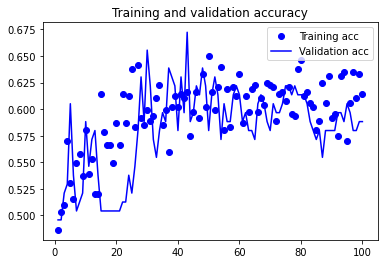

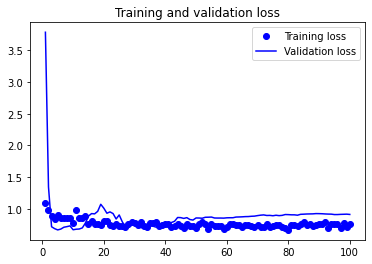

In [20]:
acc = history.history['acc']
print("keys", history.history)
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [21]:
# Using the testing generator to evaluate the model after training

test_generator = DCMDataFrameIterator(dataframe=test_set,
                             x_col='paths',
                             y_col='label',   
                             image_data_generator=test_datagen,
                             **test_consts)
test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))


Found 150 validated image filenames belonging to 2 classes.
150/150 [==============================] - 80s 536ms/step - loss: 0.8524 - acc: 0.5800


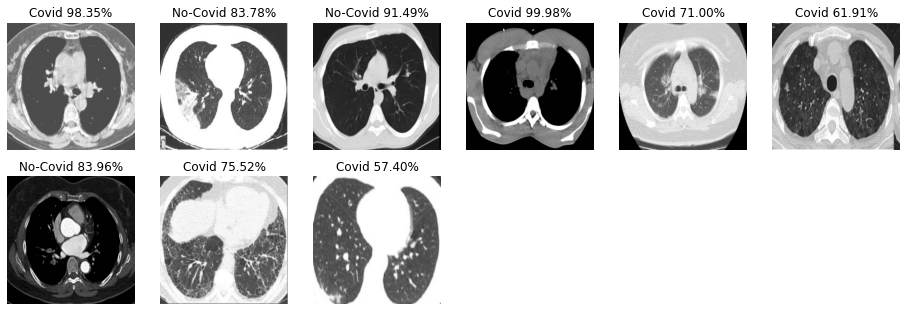

In [22]:
# show random results
import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
for i in range(9):
    x, y = test_generator.next()
    prediction = model.predict(np.expand_dims(x[0], axis=0))[0]
    
    plt.subplot(3, 6, i+1)
    if prediction[0] > prediction[1]:
        plt.title('Covid %.2f%%' % (prediction[0]*100))
    else:
        plt.title('No-Covid %.2f%%' % (prediction[1]*100))
    
    plt.axis('off')
    plt.imshow(x[0])
# x, y = test_generator.next()

 